<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/USA/Apple/Apple_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AAPL"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close     Volume
Date                                                            
2009-01-02   12.27   13.01   12.17   12.96      11.36  186503800
2009-01-05   13.31   13.74   13.24   13.51      11.84  295402100
2009-01-06   13.71   13.88   13.20   13.29      11.64  322327600
2009-01-07   13.12   13.21   12.89   13.00      11.39  188262200
2009-01-08   12.92   13.31   12.86   13.24      11.60  168375200
...            ...     ...     ...     ...        ...        ...
2018-12-24  148.15  151.55  146.59  146.83     145.64   37169200
2018-12-26  148.30  157.23  146.72  157.17     155.90   58582500
2018-12-27  155.84  156.77  150.07  156.15     154.89   53117100
2018-12-28  157.50  158.52  154.55  156.23     154.97   42291400
2018-12-31  158.53  159.36  156.48  157.74     156.46   35003500

[2516 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean     91.597266    92.406916    90.734126    91.587297    85.734845  8.632502e+07
std      50.274769    50.685944    49.855044    50.272608    50.509937  6.192304e+07
min      11.340000    11.710000    11.170000    11.170000     9.790000  1.147590e+07
25%      51.037500    51.415000    50.555000    50.965000    44.647500  3.699770e+07
50%      85.785000    86.685000    84.980000    86.105000    76.055000  7.093825e+07
75%     118.920000   119.875000   118.212500   119.145000   112.562500  1.164501e+08
max     230.780000   233.470000   229.780000   232.070000   229.390000  4.702495e+08

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close     Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-17   13.61   14.24   13.58   14.24      12.47  196661500   17          1         76             31             0               0               0                 0      3        1    12        1             2          12   13.305535   12.781631   12.148039   13.841020   13.446522   13.058383      13.055      13.000   12.331556   13.16125   14.119941   13.2255   13.533333   13.16125   13.856667   12.936450               14.726544                 13.16125               11.595956               15.509190                 13.16125               10.813310               16.291837                 13.16125               10.030663               17.074484                 13.16125                9.248016   13.446522   13.901767   12.923451               15.011816                13.446522               11.881229               15.794463                13.446522               11.098582               16.577109                13.446522               10.315935               17.359756   
2009-03-18   14.27   14.78   14.25   14.50      12.70  199009300   18          2         77             31             0               0               0                 0      3        1    12        2             3          12   13.902768   13.061915   12.357235   14.169542   13.680629   13.415679      13.185      13.290   12.484232   13.45000   14.459916   13.5310   13.830833   13.45000   14.370000   12.993175               15.044083                 13.45000               11.855917               15.841124                 13.45000               11.058876               16.638166                 13.45000               10.261834               17.435207                 13.45000                9.464793   13.680629   14.345670   12.997608               15.274711                13.680629               12.086546               16.071753                13.680629               11.289504               16.868794                13.680629               10.492463               17.665836   
2009-03-19   14.55   14.74   14.32   14.52      12.72 

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2.466000e+03  2466.000000  2466.000000  2466.000000    2466.000000   2466.000000     2466.000000     2466.000000       2466.000000  2466.000000  2466.000000  2466.000000  2466.000000   2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000   
mean     93.191229    94.011229    92.314939    93.180345    87.241926  8.397114e+07    15.760746     2.021087   186.704380      30.468775      0.034063        0.031225        0.011354          0.008516     6.641525     2.544607    27.069749     2.021087      2.021492    27.069749    93.001654    92.468671    12.780931    93.185181    92.975718    93.122548    92.922034    92.804096    92.258902    92.978779    93.178489    92.978396    93.045515    92.978779    93.136223    92.550102               95.939291                92.978779               90.018267               97.419546                92.978779               88.538011               98.899802                92.978779               87.057755              100.380058                92.978779               85.577500    92.975718    93.137748    92.616808               95.936230                92.975718               90.015206               97.416486                92.975718               88.534951               98.896742   
std      49.506679    49.915930    49.093105    49.505918    49.886451  5.971982e+07     8.748198     1.399348   103.526821       0.778018      0.181429        0.173960        0.105972          0.091906     3.389107     1.103855    14.810637     1.399348      1.414480    14.810637    49.613260    49.550653   104.121287    49.530259    49.482176    49.691948    49.513624    49.448588    49.485372    49.504887    49.510014    49.511990    49.497959    49.504887    49.509218    49.472124               50.943557                49.504887               48.141155               51.689051                49.504887               47.489422               52.451000                49.504887               46.858905               53.228695                49.504887               46.250471    49.482176    49.500618    49.481192               50.923554                49.482176               48.115614               51.670356                49.482176               47.462422               52.433579   
min      13.610000    14.240000    13.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close     Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-17  0.000000  0.000000  0.000000  0.000000   0.000000  196661500   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000000  0.000000  0.538226  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000505                 0.000000                0.000000                0.001883                 0.000000                0.000000                0.003199                 0.000000                0.000000  0.000000  0.000000  0.000000                0.000366                 0.000000                0.000000                0.001797                 0.000000                0.000000                0.003162                 0.000000                0.000000                0.004582                 0.000000   
2009-03-18  0.003039  0.002463  0.003099  0.001194   0.001060  199009300   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  0.002802  0.001332  0.538684  0.001523  0.001097  0.001667    0.000605    0.001356  0.000690  0.001349  0.001566  0.001422  0.001388  0.001349  0.002368  0.000269                0.001436                 0.001349                0.001235                0.001972                 0.001349                0.001176                0.003378                 0.001349                0.001117                0.004722                 0.001349                0.001056  0.001097  0.002046  0.000351                0.001565                 0.001097                0.000982                0.003037                 0.001097                0.000921                0.004436                 0.001097                0.000859                0.005889                 0.001097   
2009-03-19  0.004328  0.002281  0.003423  0.

140457

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx3uqbqv9
  JVM stdout: /tmp/tmpx3uqbqv9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx3uqbqv9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 5 days
H2O cluster name:           H2O_from_python_unknownUser_r2ewr5
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5  17.618971                   0.5  0.714228  0.510121
1              DeepLearning_1_AutoML_20190724_233920  0.5  16.919805                   0.5  0.699913  0.489879
2  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5  16.919805                   0.5  0.699913  0.489879
3  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5  17.618971                   0.5  0.714228  0.510121
4  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5   0.693165                   0.5  0.500009  0.250009
5  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5   0.694446                   0.5  0.500646  0.250647
6  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5   0.692946                   0.5  0.499899  0.249899
7  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5   0.693727                   0.5  0.500289  0.250289
8  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5  16.919805                   0.5  0.699913  0.489879
9  DeepLearning_grid_1_AutoML_20190724_233920_mod...  0.5  16.919805                   0.5  0.699913  0.489879

variable  relative_importance  scaled_importance  percentage
0            is_quarter_start             1.000000           1.000000    0.001456
1           CDLGRAVESTONEDOJI             0.947621           0.947621    0.001380
2           CDLINVERTEDHAMMER             0.936421           0.936421    0.001363
3                CDLTHRUSTING             0.916623           0.916623    0.001335
4             CDLSHOOTINGSTAR             0.911133           0.911133    0.001327
...                       ...                  ...                ...         ...
1038                    WMA_8             0.597264           0.597264    0.000870
1039  BBANDS_lowerband_20_7_2             0.596925           0.596925    0.000869
1040  BBANDS_lowerband_20_1_2             0.595608           0.595608    0.000867
1041  BBANDS_upperband_14_6_5             0.594657           0.594657    0.000866
1042            MINMAX_min_12             0.591783           0.591783    0.000862

[1043 rows x 4 columns]

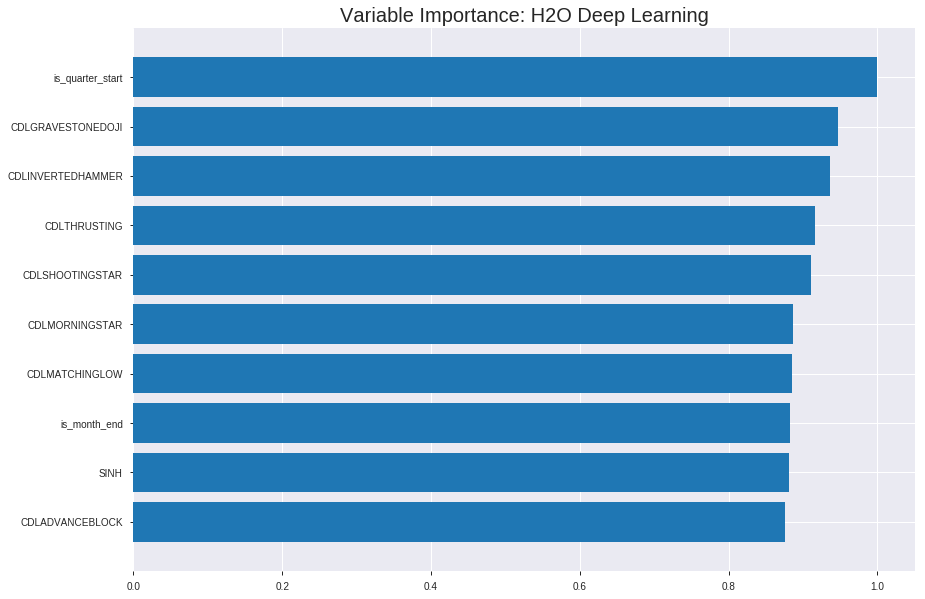

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190724_233920_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2805595674255483
RMSE: 0.529678739827783
LogLoss: 1.2288303535898744
Mean Per-Class Error: 0.33744821000841585
AUC: 0.7085794706631278
pr_auc: 0.6324885664199629
Gini: 0.41715894132625553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11726816212131397: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      287  526   0.647    (526.0/813.0)
1      112  800   0.1228   (112.0/912.0)
Total  399  1326  0.3699   (638.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.117268     0.714924  333
max f2                       0.000707081  0.849679  398
max f0point5                 0.701829     0.681239  151
max accuracy                 0.701829     0.664928  151
max precision                0.999967     0.851852  0
max recall                   9.51246e-05  1         399
max specificity              0.999967     0.98032   0
max absolute_mcc             0.701829     0.326251  151
max min_per_class_accuracy   0.788898     0.653137  120
max mean_per_class_accuracy  0.701829     0.662552  151

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 61.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.999999           1.78637   1.78637            0.944444         1           0.944444                    1                   0.0186404       0.0186404                  78.6367   78.6367
    2        0.0202899                   0.999996           1.89145   1.83741            1                0.999998    0.971429                    0.999999            0.0186404       0.0372807                  89.1447   83.7406
    3        0.0301449                   0.999982           1.55766   1.74595            0.823529         0.999988    0.923077                    0.999996            0.0153509       0.0526316                  55.7663   74.5951
    4        0.04                        0.999964           1.55766   1.69956            0.823529         0.999975    0.898551                    0.99999             0.0153509       0.0679825                  55.7663   69.9561
    5        0.0504348                   0.99993            1.36605   1.63056            0.722222         0.999949    0.862069                    0.999982            0.0142544       0.0822368                  36.6045   63.0558
    6        0.10029                     0.999359           1.42958   1.53065            0.755814         0.999717    0.809249                    0.99985             0.0712719       0.153509                   42.9582   53.0651
    7        0.150145                    0.997911           1.42958   1.49709            0.755814         0.998812    0.791506                    0.999505            0.0712719       0.224781                   42.9582   49.7092
    8        0.2                         0.9951             1.45158   1.48575            0.767442         0.996587    0.785507                    0.998778            0.0723684       0.297149                   45.1576   48.5746
    9        0.30029                     0.980529           1.23545   1.40215            0.653179         0.989617    0.741313                    0.995718            0.123904        0.421053                   23.5454   40.2154
    10       0.4                         0.932883           1.09968   1.32675            0.581395         0.960548    0.701449                    0.986951            0.109649        0.530702                   9.96787   32.6754
    11       0.50029                     0.802521           1.09332   1.27996            0.578035         0.880463    0.676709                    0.965604            0.109649        0.640351                   9.33222   27.996
    12       0.6                         0.562861           1.05569   1.24269            0.55814          0.695524    0.657005                    0.920721            0.105263        0.745614                   5.56916   24.269
    13       0.69971                     0.273283           0.835756  1.1847             0.44186          0.416839    0.626346                    0.848917            0.0833333       0.828947                   -16.4244  18.4701
    14       0.8                         0.0758018          0.666927  1.11979            0.352601         0.159398    0.592029                    0.762477            0.066886        0.895833                   -33.3073  11.9792
    15       0.89971                     0.00824217         0.58283   1.06028            0.30814          0.0312532   0.560567                    0.68144             0.058114        0.953947                   -41.717   6.0283
    16       1                           3.17693e-21        0.459195  1                  0.242775         0.00182476  0.528696    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4863983554806182
RMSE: 0.6974226519698211
LogLoss: 9.839513192082816
Mean Per-Class Error: 0.48630011949017526
AUC: 0.4948967737652682
pr_auc: 0.5430590566684029
Gini: -0.010206452469463612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.6321445538842684e-143: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold     value     idx
---------------------------  ------------  --------  -----
max f1                       2.63214e-143  0.706037  267
max f2                       2.63214e-143  0.857234  267
max f0point5                 2.63214e-143  0.600178  267
max accuracy                 2.63214e-143  0.545639  267
max precision                0.999999      0.8       3
max recall                   2.63214e-143  1         267
max specificity              1             0.995536  0
max absolute_mcc             0.102189      0.064213  188
max min_per_class_accuracy   0.0016017     0.5       245
max mean_per_class_accuracy  0.95912       0.5137    78

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 29.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.999998           1.46617   1.46617            0.8              1            0.8                         1                   0.0148699       0.0148699                  46.6171    46.6171
    2        0.020284                    0.999993           0.733086  1.09963            0.4              0.999997     0.6                         0.999998            0.00743494      0.0223048                  -26.6914   9.96283
    3        0.030426                    0.999967           0.733086  0.977447           0.4              0.999982     0.533333                    0.999993            0.00743494      0.0297398                  -26.6914   -2.25527
    4        0.040568                    0.999822           0.733086  0.916357           0.4              0.999891     0.5                         0.999967            0.00743494      0.0371747                  -26.6914   -8.36431
    5        0.0507099                   0.999168           0.733086  0.879703           0.4              0.999627     0.48                        0.999899            0.00743494      0.0446097                  -26.6914   -12.0297
    6        0.10142                     0.991559           1.24625   1.06297            0.68             0.995514     0.58                        0.997707            0.063197        0.107807                   24.6245    6.2974
    7        0.150101                    0.97035            0.99272   1.04019            0.541667         0.982479     0.567568                    0.992768            0.0483271       0.156134                   -0.728005  4.01889
    8        0.200811                    0.873787           0.806394  0.98115            0.44             0.924565     0.535354                    0.975545            0.0408922       0.197026                   -19.3606   -1.88502
    9        0.300203                    0.546802           0.897656  0.953506           0.489796         0.741829     0.52027                     0.898166            0.0892193       0.286245                   -10.2344   -4.64935
    10       0.399594                    0.0653109          0.935058  0.948918           0.510204         0.280719     0.517766                    0.744588            0.0929368       0.379182                   -6.4942    -5.10822
    11       0.501014                    0.0016017          1.20959   1.00169            0.66             0.0217872    0.546559                    0.598272            0.122677        0.501859                   20.9591    0.168566
    12       1                           0                  0.998307  1                  0.544715         3.02518e-05  0.545639                    0.299758            0.498141        1                          -0.169251  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-24 23:39:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-24 23:39:29  3.331 sec         196 obs/sec       0.162319  1             280        0.675254         8.88854             -0.829898      0.539585        0.345011           1.22688          0.471304                         0.715284           14.6194               -1.06372         0.497245          0.297339             0.986214           0.454361
    2019-07-24 23:39:46  20.438 sec        231 obs/sec       2.30087   15            3969       0.651801         5.79369             -0.704996      0.571024        0.416472           1.68129          0.471304                         0.734262           14.844                -1.17468         0.506439          0.560867             1.83271            0.454361
    2019-07-24 23:40:01  35.067 sec        236 obs/sec       4.18203   27            7214       0.62324          3.45758             -0.558848      0.614151        0.374631           1.57621          0.417971                         0.699494           11.8994               -0.973609        0.499569          0.471517             1.09963            0.454361
    2019-07-24 23:40:15  48.566 sec        237 obs/sec       5.89739   38            10173      0.636751         3.79125             -0.627165      0.591013        0.623435           1.78637          0.471304                         0.699074           9.89704               -0.971243        0.499602          0.547235             1.09963            0.454361
    2019-07-24 23:40:27  1 min  0.847 sec  239 obs/sec       7.47478   48            12894      0.673429         4.92177             -0.82002       0.536549        0.396509           1.0508           0.471304                         0.703094           13.385                -0.993977        0.498374          0.346847             1.09963            0.454361
    2019-07-24 23:40:40  1 min 13.791 sec  241 obs/sec       9.16      59            15801      0.549095         1.36649             -0.210009      0.681417        0.601641           1.57621          0.398841                         0.693476           9.84868               -0.939797        0.496117          0.541537             1.46617            0.454361
    2019-07-24 23:40:54  1 min 27.937 sec  243 obs/sec       11.0365   71            19038      0.534634         1.33968             -0.147113      0.694463        0.581345           1.68129          0.378551                         0.703283           10.0247               -0.995052        0.494283          0.539683             1.09963            0.454361
    2019-07-24 23:41:07  1 min 40.988 sec  244 obs/sec       12.7554   82            22003      0.597505         2.76929             -0.432768      0.638631        0.438543           1.36605          0.386667                         0.722949           10.5509               -1.10819         0.489545          0.529541             0.733086           0.454361
    2019-07-24 23:41:20

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
is_quarter_start         1.0                    1.0                  0.0014560415101524643
CDLGRAVESTONEDOJI        0.94762122631073       0.94762122631073     0.0013797758414100054
CDLINVERTEDHAMMER        0.9364209771156311     0.9364209771156311   0.0013634678136578897
CDLTHRUSTING             0.9166231155395508     0.9166231155395508   0.0013346413053908642
CDLSHOOTINGSTAR          0.9111332893371582     0.9111332893371582   0.001326647890556658
---                      ---                    ---                  ---
WMA_8                    0.5972635746002197     0.5972635746002197   0.0008696405571199629
BBANDS_lowerband_20_7_2  0.5969251990318298     0.5969251990318298   0.0008691478682463658
BBANDS_lowerband_20_1_2  0.5956078171730042     0.5956078171730042   0.0008672297055751938
BBANDS_upperband_14_6_5  0.5946574807167053     0.5946574807167053   0.0008658459762462115
MINMAX_min_12            0.5917832851409912     0.5917832851409912   0.0008616610281796752


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


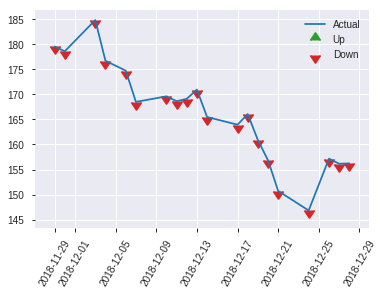


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

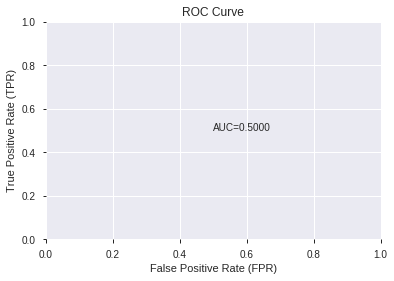

This function is available for GLM models only


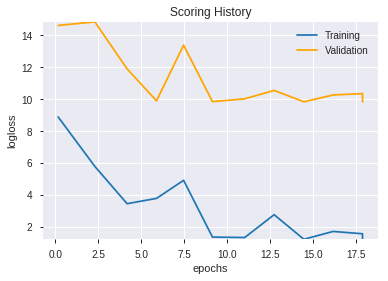

--2019-07-25 00:14:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.3MB/s    in 28s     

2019-07-25 00:15:01 (12.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190724_233920_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190724_233920_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_001516_model_8  0.5  16.919805                   0.5  0.699913  0.489879
1  DeepLearning_grid_1_AutoML_20190725_001516_model_9  0.5   0.693827                   0.5  0.500339  0.250339
2  DeepLearning_grid_1_AutoML_20190725_001516_model_4  0.5  17.618971                   0.5  0.714228  0.510121
3  DeepLearning_grid_1_AutoML_20190725_001516_model_7  0.5  16.919805                   0.5  0.699913  0.489879
4  DeepLearning_grid_1_AutoML_20190725_001516_model_6  0.5  17.618971                   0.5  0.714228  0.510121
5  DeepLearning_grid_1_AutoML_20190725_001516_model_3  0.5  16.919805                   0.5  0.699913  0.489879
6  DeepLearning_grid_1_AutoML_20190725_001516_model_5  0.5  17.618971                   0.5  0.714228  0.510121
7               DeepLearning_1_AutoML_20190725_001516  0.5  17.618971                   0.5  0.714228  0.510121
8  DeepLearning_grid_1_AutoML_20190725_001516_model_2  0.5  16.919805                   0.5  0.699913  0.489879
9  DeepLearning_grid_1_AutoML_20190725_001516_model_1  0.5  16.919805                   0.5  0.699913  0.489879

variable  relative_importance  scaled_importance  percentage
0          is_month_end             1.000000           1.000000    0.021683
1        CDLEVENINGSTAR             0.982748           0.982748    0.021309
2             CDLTAKURI             0.975013           0.975013    0.021142
3    CDLEVENINGDOJISTAR             0.973417           0.973417    0.021107
4        is_month_start             0.972832           0.972832    0.021094
5             dayofweek             0.969455           0.969455    0.021021
6     CDL3WHITESOLDIERS             0.966908           0.966908    0.020966
7       CDLSHOOTINGSTAR             0.965377           0.965377    0.020933
8   CDLXSIDEGAP3METHODS             0.963196           0.963196    0.020885
9       CDLLADDERBOTTOM             0.957880           0.957880    0.020770
10     CDLDRAGONFLYDOJI             0.957768           0.957768    0.020768
11     is_quarter_start             0.955640           0.955640    0.020722
12            CORREL_14             0.954280           0.954280    0.020692
13            CDLONNECK             0.947710           0.947710    0.020550
14         CDLTHRUSTING             0.947646           0.947646    0.020548
15            aroonup_8             0.947024           0.947024    0.020535
16            CDLINNECK             0.943515           0.943515    0.020459
17    CDLSTALLEDPATTERN             0.941842           0.941842    0.020422
18            CDL2CROWS             0.941432           0.941432    0.020413
19   CDLMORNINGDOJISTAR             0.939576           0.939576    0.020373
20                  TAN             0.939174           0.939174    0.020364
21        CDLHANGINGMAN             0.936303           0.936303    0.020302
22            CDLHAMMER             0.935970           0.935970    0.020295
23                  EXP             0.932559           0.932559    0.020221
24        days_in_month             0.930118           0.930118    0.020168
25       CDLRICKSHAWMAN             0.930006           0.930006    0.020166
26      CDLUNIQUE3RIVER             0.928902           0.928902    0.020142
27        CDLHIKKAKEMOD             0.928010           0.928010    0.020122
28           CDL3INSIDE             0.924951           0.924951    0.020056
29              CDLDOJI             0.924466           0.924466    0.020046
30         HT_TRENDMODE             0.923765           0.923765    0.020030
31    CDLGRAVESTONEDOJI             0.923542           0.923542    0.020026
32    CDLDARKCLOUDCOVER             0.920586           0.920586    0.019961
33                 TANH             0.913742           0.913742    0.019813
34      CDLADVANCEBLOCK             0.908924           0.908924    0.019709
35       is_quarter_end             0.893993           0.893993    0.019385
36              weekday             0.891569           0.891569    0.019332
37               VAR_12             0.890306           0.890306    0.019305
38    CDLLONGLEGGEDDOJI             0.888057           0.888057    0.019256
39                 SINH             0.886290           0.886290    0.019218
40   CDLUPSIDEGAP2CROWS             0.881379           0.881379    0.019111
41     CDLSTICKSANDWICH             0.880949           0.880949    0.019102
42       CDLMATCHINGLOW             0.877774           0.877774    0.019033
43          CDLPIERCING             0.875715           0.875715    0.018988
44      CDLHOMINGPIGEON             0.872434           0.872434    0.018917
45                 COSH             0.869618           0.869618    0.018856
46                VAR_8             0.869188           0.869188    0.018847
47  CDLGAPSIDESIDEWHITE             0.821749           0.821749    0.017818
48       CDLMORNINGSTAR             0.809414           0.809414    0.017551
49    CDLINVERTEDHAMMER             0.805569           0.805569    0.017467

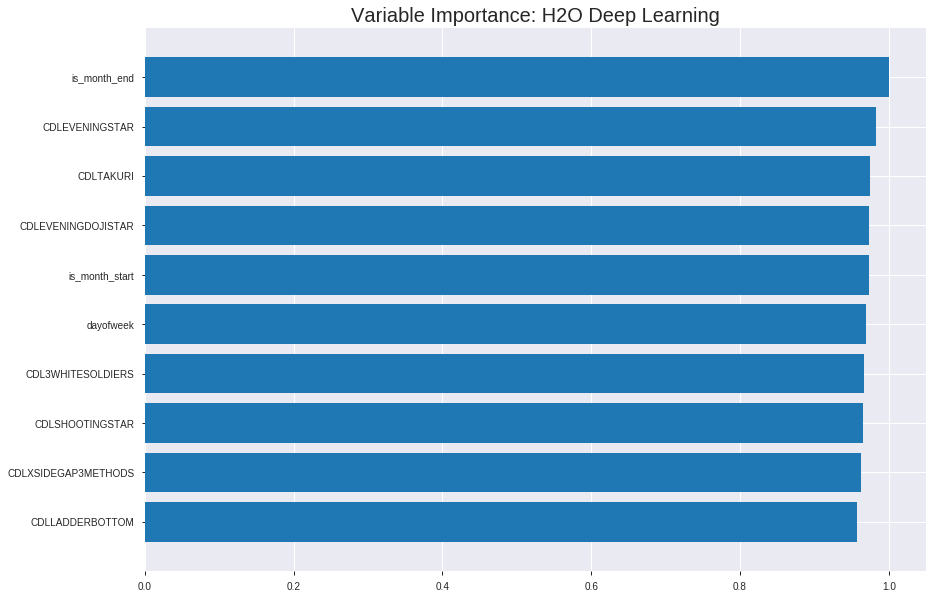

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_001516_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.31967287503675085
RMSE: 0.5653962106671311
LogLoss: 0.8746106545319118
Mean Per-Class Error: 0.4700144040914094
AUC: 0.5177191903497983
pr_auc: 0.5426681526858133
Gini: 0.035438380699596594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6623969116695246: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    810   0.9963   (810.0/813.0)
1      1    911   0.0011   (1.0/912.0)
Total  4    1721  0.4701   (811.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.662397     0.691986  395
max f2                       0.648694     0.848846  398
max f0point5                 0.712516     0.584898  369
max accuracy                 0.712516     0.532174  369
max precision                0.919761     0.692308  11
max recall                   0.648694     1         398
max specificity              0.952332     0.99877   0
max absolute_mcc             0.800895     0.060737  182
max min_per_class_accuracy   0.79039      0.515375  209
max mean_per_class_accuracy  0.797483     0.529986  192

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 79.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.915911           1.26096   1.26096            0.666667         0.932424  0.666667                    0.932424            0.0131579       0.0131579                  26.0965   26.0965
    2        0.0202899                   0.901873           0.778831  1.02679            0.411765         0.908522  0.542857                    0.920814            0.00767544      0.0208333                  -22.1169  2.67857
    3        0.0301449                   0.889016           0.778831  0.945724           0.411765         0.894654  0.5                         0.912262            0.00767544      0.0285088                  -22.1169  -5.42763
    4        0.04                        0.885521           1.00135   0.95943            0.529412         0.887179  0.507246                    0.906082            0.00986842      0.0383772                  0.135449  -4.05702
    5        0.0504348                   0.881861           1.15588   1.00008            0.611111         0.883789  0.528736                    0.90147             0.0120614       0.0504386                  15.5885   0.00756201
    6        0.10029                     0.849361           1.14367   1.07146            0.604651         0.86303   0.566474                    0.882361            0.0570175       0.107456                   14.3666   7.14557
    7        0.150145                    0.834347           1.09968   1.08083            0.581395         0.839857  0.571429                    0.868248            0.0548246       0.162281                   9.96787   8.08271
    8        0.2                         0.826099           1.0337    1.06908            0.546512         0.830428  0.565217                    0.85882             0.0515351       0.213816                   3.3698    6.90789
    9        0.30029                     0.81163            0.962124  1.03336            0.508671         0.817888  0.546332                    0.84515             0.0964912       0.310307                   -3.78765  3.33583
    10       0.4                         0.799967           1.15466   1.0636             0.610465         0.805742  0.562319                    0.835326            0.115132        0.425439                   15.4663   6.35965
    11       0.50029                     0.790378           0.907457  1.0323             0.479769         0.795747  0.545771                    0.827392            0.0910088       0.516447                   -9.25426  3.22963
    12       0.6                         0.781054           0.95672   1.01974            0.505814         0.785724  0.53913                     0.820468            0.0953947       0.611842                   -4.32795  1.97368
    13       0.69971                     0.769223           0.934727  1.00762            0.494186         0.775753  0.532726                    0.814096            0.0932018       0.705044                   -6.52731  0.762275
    14       0.8                         0.755305           0.918391  0.996436           0.485549         0.762312  0.526812                    0.807604            0.0921053       0.797149                   -8.16094  -0.35636
    15       0.89971                     0.736969           1.0227    0.999347           0.540698         0.745929  0.528351                    0.800769            0.101974        0.899123                   2.27012   -0.0652808
    16       1                           0.608032           1.00586   1                  0.531792         0.719     0.528696                    0.79256



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3770859162773058
RMSE: 0.6140732173587331
LogLoss: 7.636313237461742
Mean Per-Class Error: 0.4708327801380775
AUC: 0.4965978491768454
pr_auc: 0.30487267002907986
Gini: -0.0068043016463091854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.648176314137494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.648176     0.706037  272
max f2                       0.648176     0.857234  272
max f0point5                 0.648176     0.600178  272
max accuracy                 0.648176     0.545639  272
max precision                0.824562     0.570922  61
max recall                   0.648176     1         272
max specificity              1            0.544643  0
max absolute_mcc             0.722723     0.110272  261
max min_per_class_accuracy   0.862758     0.495536  26
max mean_per_class_accuracy  0.824562     0.529167  61

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 88.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.446247                    1                  0.983001  0.983001           0.536364         1         0.536364                    1                   0.438662        0.438662                   -1.6999   -1.6999
    2        0.501014                    0.862758           1.08605   0.994266           0.592593         0.91113   0.54251                     0.990286            0.0594796       0.498141                   8.60526   -0.573424
    3        0.600406                    0.816129           1.19687   1.02781            0.653061         0.834399  0.560811                    0.96448             0.118959        0.6171                     19.6874   2.78057
    4        0.699797                    0.795229           0.935058  1.01463            0.510204         0.805446  0.553623                    0.941892            0.0929368       0.710037                   -6.4942   1.46328
    5        0.799189                    0.7766             0.748046  0.981479           0.408163         0.786491  0.535533                    0.922566            0.0743494       0.784387                   -25.1954  -1.85213
    6        0.89858                     0.751621           1.04727   0.988755           0.571429         0.763626  0.539503                    0.904986            0.104089        0.888476                   4.7265    -1.12447
    7        1                           0.648176           1.09963   1                  0.6              0.728614  0.545639                    0.887098            0.111524        1                          9.96283   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:20:53  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:20:55  1 min 11.954 sec  714 obs/sec       0.764638  1             1319       0.565396         0.874611            -0.282917      0.517719        0.542668           1.26096          0.470145                         0.614073           7.63631               -0.521016        0.496598          0.304873             0.983001           0.454361
    2019-07-25 00:21:07  1 min 24.111 sec  1112 obs/sec      8.31072   11            14336      0.499047         0.69117             0.000518228    0.52187         0.612127           1.57621          0.46029                          0.620238           8.80128               -0.551708        0.494805          0.523855             0.733086           0.454361
    2019-07-25 00:21:19  1 min 36.110 sec  1203 obs/sec      16.5722   22            28587      0.494049         0.680752            0.0204364      0.573197        0.625825           1.57621          0.458551                         0.623649           8.97717               -0.568823        0.499776          0.542292             1.09963            0.454361
    2019-07-25 00:21:31  1 min 47.833 sec  1289 obs/sec      25.673    34            44286      0.488502         0.667964            0.0423077      0.587666        0.643785           1.78637          0.43942                          0.623963           8.95347               -0.570402        0.506871          0.549322             1.09963            0.454361
    2019-07-25 00:21:42  1 min 59.222 sec  1371 obs/sec      35.4725   47            61190      0.484212         0.657905            0.0590564      0.60408         0.65666            1.89145          0.432464                         0.623045           8.98159               -0.565785        0.51594           0.574207             1.46617            0.454361
    2019-07-25 00:21:54  2 min 10.726 sec  1466 obs/sec      46.7977   62            80726      0.478426         0.642635            0.0814071      0.619642        0.687582           1.89145          0.428406                         0.625584           9.01429               -0.578572        0.498249          0.552429             0.733086           0.454361
    2019-07-25 00:21:55  2 min 11.880 sec  1465 obs/sec      46.7977   62            80726      0.565396         0.874611            -0.282917      0.517719        0.542668           1.26096          0.470145                         0.614073           7.63631               -0.521016        0.496598          0.304873             0.983001           0.454361

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
is_month_end         1.0                    1.0                  0.021683376355569026
CDLEVENINGSTAR       0.9827482104301453     0.9827482104301453   0.021309299309518786
CDLTAKURI            0.9750130772590637     0.9750130772590637   0.02114157550580978
CDLEVENINGDOJISTAR   0.9734166860580444     0.9734166860580444   0.021106960354587357
is_month_start       0.9728322625160217     0.9728322625160217   0.021094288078974625
---                  ---                    ---                  ---
COSH                 0.8696178197860718     0.8696178197860718   0.018856250471930795
VAR_8                0.8691883087158203     0.8691883087158203   0.018846937221745647
CDLGAPSIDESIDEWHITE  0.8217491507530212     0.8217491507530212   0.01781829610564699
CDLMORNINGSTAR       0.8094136118888855     0.8094136118888855   0.017550819973907183
CDLINVERTEDHAMMER    0.8055694103240967     0.8055694103240967   0.0174674647045912


See the whole table with table.as_data_frame()


('accuracy', 0.5101214574898786)

('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 16.919805440421822)

('mean_per_class_error', 0.5)

('rmse', 0.6999132392733556)

('mse', 0.4898785425101215)

deeplearning prediction progress: |███████████████████████████████████████| 100%


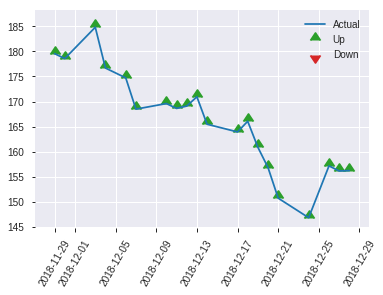


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4898785425101215
RMSE: 0.6999132392733556
LogLoss: 16.919805440421822
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.675603  0
max f2                       1            0.838881  0
max f0point5                 1            0.56553   0
max accuracy                 1            0.510121  0
max precision                1            0.510121  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.510121         1        0.510121                    1                   1               1                          0       0

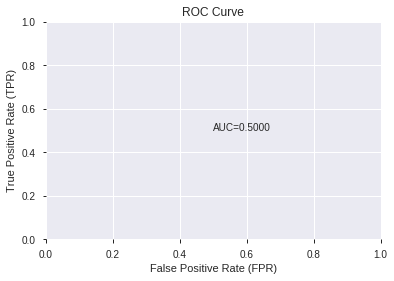

This function is available for GLM models only


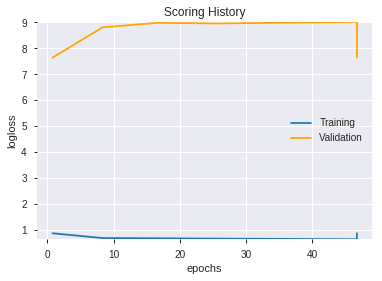

--2019-07-25 00:23:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_001516_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_001516_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['is_month_end',
 'CDLEVENINGSTAR',
 'CDLTAKURI',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'dayofweek',
 'CDL3WHITESOLDIERS',
 'CDLSHOOTINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'CDLDRAGONFLYDOJI',
 'is_quarter_start',
 'CORREL_14',
 'CDLONNECK',
 'CDLTHRUSTING',
 'aroonup_8',
 'CDLINNECK',
 'CDLSTALLEDPATTERN',
 'CDL2CROWS',
 'CDLMORNINGDOJISTAR',
 'TAN',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'EXP',
 'days_in_month',
 'CDLRICKSHAWMAN',
 'CDLUNIQUE3RIVER',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'TANH',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'weekday',
 'VAR_12',
 'CDLLONGLEGGEDDOJI',
 'SINH',
 'CDLUPSIDEGAP2CROWS',
 'CDLSTICKSANDWICH',
 'CDLMATCHINGLOW',
 'CDLPIERCING',
 'CDLHOMINGPIGEON',
 'COSH',
 'VAR_8',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLINVERTEDHAMMER']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_002329_model_1  0.5  17.618971                   0.5  0.714228  0.510121

variable  relative_importance  scaled_importance  percentage
0               weekday             0.008707           1.000000    0.056246
1             dayofweek             0.008689           0.997839    0.056124
2             aroonup_8             0.007908           0.908219    0.051084
3                   EXP             0.007562           0.868441    0.048846
4                  SINH             0.007555           0.867614    0.048800
5                  COSH             0.007553           0.867434    0.048790
6     CDLSTALLEDPATTERN             0.005277           0.606056    0.034088
7             CDLINNECK             0.004823           0.553922    0.031156
8   CDLXSIDEGAP3METHODS             0.004659           0.535036    0.030094
9       CDLLADDERBOTTOM             0.004657           0.534865    0.030084
10                 TANH             0.004258           0.488949    0.027501
11    CDLINVERTEDHAMMER             0.003961           0.454847    0.025583
12         CDLTHRUSTING             0.003808           0.437306    0.024597
13     is_quarter_start             0.003604           0.413918    0.023281
14    CDLGRAVESTONEDOJI             0.003572           0.410278    0.023076
15           CDL3INSIDE             0.003496           0.401443    0.022580
16        CDLHIKKAKEMOD             0.003392           0.389518    0.021909
17       is_month_start             0.003377           0.387857    0.021815
18      CDLSHOOTINGSTAR             0.003166           0.363558    0.020449
19       CDLMORNINGSTAR             0.003141           0.360757    0.020291
20   CDLMORNINGDOJISTAR             0.003136           0.360122    0.020255
21            CDL2CROWS             0.003083           0.354034    0.019913
22               VAR_12             0.003064           0.351907    0.019793
23    CDL3WHITESOLDIERS             0.003060           0.351437    0.019767
24            CORREL_14             0.002741           0.314792    0.017706
25  CDLGAPSIDESIDEWHITE             0.002715           0.311818    0.017539
26    CDLLONGLEGGEDDOJI             0.002712           0.311483    0.017520
27              CDLDOJI             0.002710           0.311220    0.017505
28   CDLEVENINGDOJISTAR             0.002700           0.310105    0.017442
29        CDLHANGINGMAN             0.002611           0.299856    0.016866
30                  TAN             0.002548           0.292580    0.016456
31       CDLRICKSHAWMAN             0.002243           0.257575    0.014488
32        days_in_month             0.002232           0.256374    0.014420
33       CDLMATCHINGLOW             0.002224           0.255421    0.014366
34   CDLUPSIDEGAP2CROWS             0.002201           0.252785    0.014218
35            CDLHAMMER             0.002095           0.240579    0.013532
36    CDLDARKCLOUDCOVER             0.001704           0.195653    0.011005
37      CDLHOMINGPIGEON             0.001230           0.141206    0.007942
38       CDLEVENINGSTAR             0.001186           0.136153    0.007658
39          CDLPIERCING             0.001093           0.125514    0.007060
40      CDLADVANCEBLOCK             0.000730           0.083836    0.004715
41                VAR_8             0.000725           0.083268    0.004683
42         HT_TRENDMODE             0.000554           0.063618    0.003578
43       is_quarter_end             0.000518           0.059449    0.003344
44            CDLTAKURI             0.000406           0.046574    0.002620
45            CDLONNECK             0.000351           0.040332    0.002269
46     CDLDRAGONFLYDOJI             0.000313           0.035947    0.002022
47      CDLUNIQUE3RIVER             0.000265           0.030412    0.001711
48         is_month_end             0.000255           0.029266    0.001646
49     CDLSTICKSANDWICH             0.000243           0.027851    0.001567

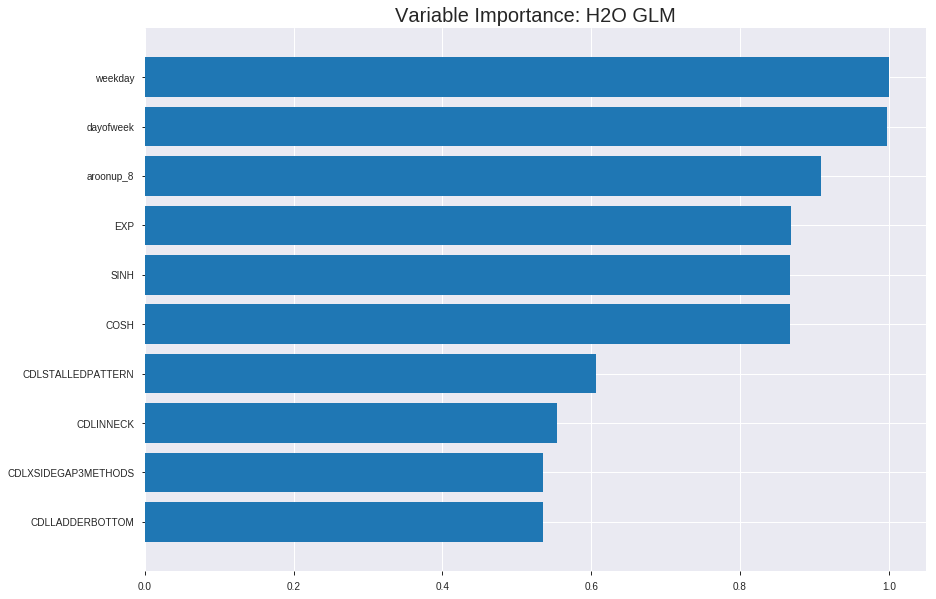

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_002329_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24783075562699075
RMSE: 0.49782602947916527
LogLoss: 0.6887963646697028
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2385.6729106355115
Residual deviance: 2376.3474581104747
AIC: 2478.3474581104747
AUC: 0.5803729418873136
pr_auc: 0.6065952654975323
Gini: 0.16074588377462717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5122306332433035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      30   783   0.9631   (783.0/813.0)
1      5    907   0.0055   (5.0/912.0)
Total  35   1690  0.4568   (788.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512231     0.697156  370
max f2                       0.504671     0.851064  385
max f0point5                 0.521002     0.596526  310
max accuracy                 0.526564     0.55942   233
max precision                0.567352     1         0
max recall                   0.504671     1         385
max specificity              0.567352     1         0
max absolute_mcc             0.532128     0.130493  145
max min_per_class_accuracy   0.529093     0.548585  192
max mean_per_class_accuracy  0.532128     0.561371  145

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.549159           1.57621   1.57621            0.833333         0.555905  0.833333                    0.555905            0.0164474       0.0164474                  57.6206   57.6206
    2        0.0202899                   0.542353           1.22388   1.40508            0.647059         0.545208  0.742857                    0.550709            0.0120614       0.0285088                  22.3878   40.5075
    3        0.0301449                   0.540405           1.33514   1.38221            0.705882         0.541313  0.730769                    0.547637            0.0131579       0.0416667                  33.5139   38.2212
    4        0.04                        0.539264           1.4464    1.39803            0.764706         0.539746  0.73913                     0.545693            0.0142544       0.0559211                  44.6401   39.8026
    5        0.0504348                   0.538627           0.945724  1.30445            0.5              0.538986  0.689655                    0.544305            0.00986842      0.0657895                  -5.42763  30.4446
    6        0.10029                     0.536879           1.27563   1.29012            0.674419         0.537835  0.682081                    0.541089            0.0635965       0.129386                   27.5627   29.012
    7        0.150145                    0.535533           1.18765   1.2561             0.627907         0.536189  0.664093                    0.539462            0.0592105       0.188596                   18.7653   25.6096
    8        0.2                         0.53442            1.12167   1.22259            0.593023         0.534988  0.646377                    0.538346            0.0559211       0.244518                   12.1672   22.2588
    9        0.30029                     0.532626           1.08239   1.17576            0.572254         0.53345   0.621622                    0.536711            0.108553        0.35307                    8.2389    17.5765
    10       0.4                         0.530906           0.989711  1.12939            0.523256         0.531731  0.597101                    0.53547             0.0986842       0.451754                   -1.02892  12.9386
    11       0.50029                     0.5291             0.940257  1.09147            0.49711          0.530006  0.577057                    0.534374            0.0942982       0.546053                   -5.97429  9.14725
    12       0.6                         0.527584           0.989711  1.07456            0.523256         0.528378  0.568116                    0.533378            0.0986842       0.644737                   -1.02892  7.45614
    13       0.69971                     0.525808           0.989711  1.06247            0.523256         0.526605  0.561723                    0.532413            0.0986842       0.743421                   -1.02892  6.247
    14       0.8                         0.523729           0.841858  1.03481            0.445087         0.524869  0.547101                    0.531467            0.0844298       0.827851                   -15.8142  3.48136
    15       0.89971                     0.520615           1.0227    1.03347            0.540698         0.5222    0.546392                    0.53044             0.101974        0.929825                   2.27012   3.34712
    16       1                           0.380332           0.699726  1                  0.369942         0.513046  0.528696                    0.528696            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38292114221810053
RMSE: 0.6188062234804208
LogLoss: 8.660796714698645
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 679.8987251155328
Residual deviance: 157117.5761601873
AIC: 157219.5761601873
AUC: 0.5010621348911312
pr_auc: 0.5432858726163489
Gini: 0.0021242697822623224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.288118859815988e-78: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       8.28812e-78  0.706037   278
max f2                       8.28812e-78  0.857234   278
max f0point5                 8.28812e-78  0.600178   278
max accuracy                 8.28812e-78  0.545639   278
max precision                0.538319     0.666667   8
max recall                   8.28812e-78  1          278
max specificity              0.561404     0.995536   0
max absolute_mcc             0.529784     0.0608548  134
max min_per_class_accuracy   0.519849     0.5        246
max mean_per_class_accuracy  1.73051e-14  0.515783   276

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 28.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.541677           0.733086  0.733086           0.4              0.549462   0.4                         0.549462            0.00743494      0.00743494                 -26.6914   -26.6914
    2        0.020284                    0.538094           1.46617   1.09963            0.8              0.539608   0.6                         0.544535            0.0148699       0.0223048                  46.6171    9.96283
    3        0.030426                    0.537684           0.733086  0.977447           0.4              0.537918   0.533333                    0.542329            0.00743494      0.0297398                  -26.6914   -2.25527
    4        0.040568                    0.537233           0.733086  0.916357           0.4              0.537485   0.5                         0.541118            0.00743494      0.0371747                  -26.6914   -8.36431
    5        0.0507099                   0.536596           1.83271   1.09963            1                0.536931   0.6                         0.540281            0.0185874       0.0557621                  83.2714    9.96283
    6        0.10142                     0.534935           0.879703  0.989665           0.48             0.535772   0.54                        0.538026            0.0446097       0.100372                   -12.0297   -1.03346
    7        0.150101                    0.533337           0.99272   0.990656           0.541667         0.534259   0.540541                    0.536805            0.0483271       0.148699                   -0.728005  -0.934392
    8        0.200811                    0.531924           0.953011  0.98115            0.52             0.532667   0.535354                    0.53576             0.0483271       0.197026                   -4.69888   -1.88502
    9        0.300203                    0.528484           0.935058  0.96589            0.510204         0.530261   0.527027                    0.533939            0.0929368       0.289963                   -6.4942    -3.41103
    10       0.399594                    0.525433           1.04727   0.98613            0.571429         0.527178   0.538071                    0.532257            0.104089        0.394052                   4.7265     -1.38698
    11       0.501014                    0.519849           1.06297   1.00169            0.58             0.523177   0.546559                    0.530419            0.107807        0.501859                   6.2974     0.168566
    12       1                           0                  0.998307  1                  0.544715         0.0426712  0.545639                    0.28704             0.498141        1                          -0.169251  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:23:29  0.000 sec   2            3.5       51            1.37759           318.697
    2019-07-25 00:23:29  0.024 sec   4            2.2       51            1.3751            322.212
    2019-07-25 00:23:29  0.048 sec   6            1.3       51            1.37189           325.576
    2019-07-25 00:23:29  0.071 sec   8            0.83      51            1.3681            328.6
    2019-07-25 00:23:29  0.088 sec   10           0.52      51            1.36401           330.233

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

glm prediction progress: |████████████████████████████████████████████████| 100%


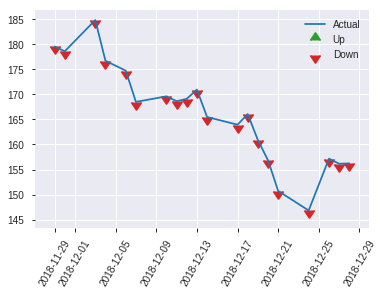


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 342.65506474663505
Residual deviance: 178515.89747013059
AIC: 178617.89747013059
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

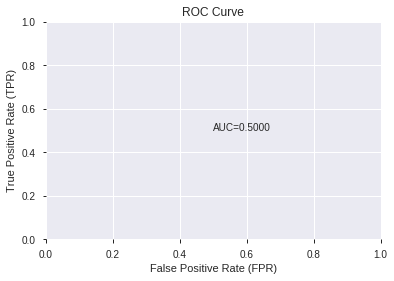

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


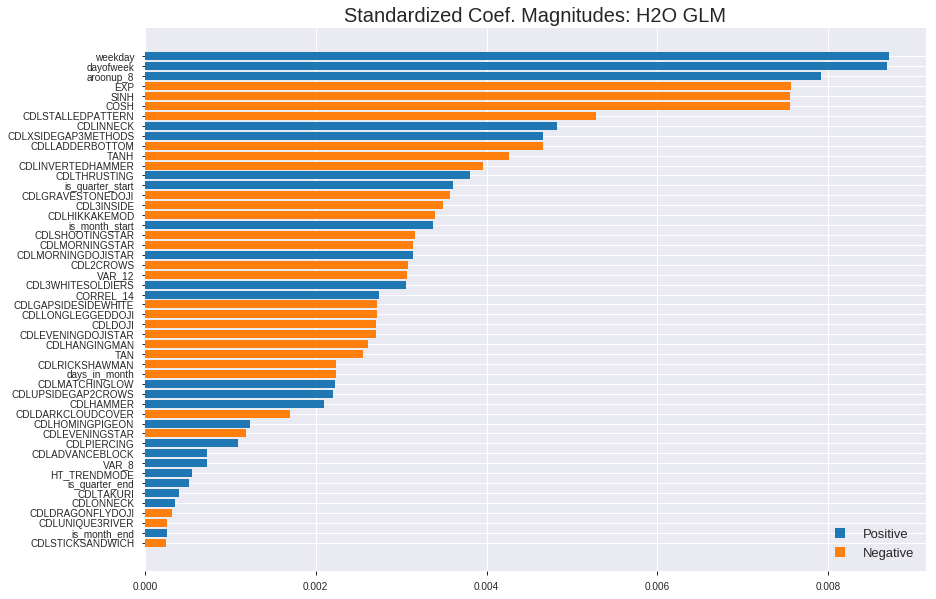

'log_likelihood'
--2019-07-25 00:23:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_002329_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_002329_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['weekday',
 'dayofweek',
 'aroonup_8',
 'EXP',
 'SINH',
 'COSH',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'TANH',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CDLHIKKAKEMOD',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDL2CROWS',
 'VAR_12',
 'CDL3WHITESOLDIERS',
 'CORREL_14',
 'CDLGAPSIDESIDEWHITE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLHANGINGMAN',
 'TAN',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLUPSIDEGAP2CROWS',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'VAR_8',
 'HT_TRENDMODE',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLUNIQUE3RIVER',
 'is_month_end',
 'CDLSTICKSANDWICH']

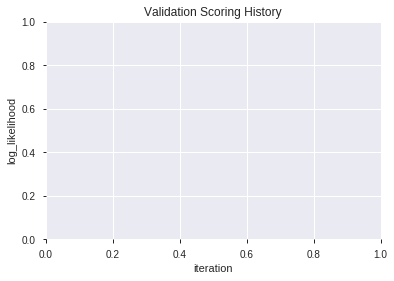

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_002348_model_5  0.481241  0.850424              0.500000  0.560012  0.313613
1  XGBoost_grid_1_AutoML_20190725_002348_model_6  0.480454  0.756893              0.500000  0.528426  0.279234
2  XGBoost_grid_1_AutoML_20190725_002348_model_3  0.479273  0.744590              0.491736  0.523455  0.274005
3               XGBoost_3_AutoML_20190725_002348  0.478289  0.743973              0.500000  0.523066  0.273598
4  XGBoost_grid_1_AutoML_20190725_002348_model_2  0.476453  0.709964              0.500000  0.508127  0.258193
5  XGBoost_grid_1_AutoML_20190725_002348_model_1  0.473140  0.726247              0.500000  0.515478  0.265718
6               XGBoost_2_AutoML_20190725_002348  0.457431  0.723676              0.500000  0.514457  0.264666
7  XGBoost_grid_1_AutoML_20190725_002348_model_7  0.457104  0.734626              0.500000  0.519103  0.269468
8  XGBoost_grid_1_AutoML_20190725_002348_model_4  0.454545  0.715190              0.500000  0.510635  0.260748
9               XGBoost_1_AutoML_20190725_002348  0.451331  0.728651              0.500000  0.516564  0.266838

variable  relative_importance  scaled_importance  percentage
0             CORREL_14          4111.833496           1.000000    0.203442
1                   TAN          3767.242920           0.916195    0.186392
2                VAR_12          3313.143799           0.805758    0.163925
3                 VAR_8          3193.685059           0.776706    0.158014
4             aroonup_8          1309.017822           0.318354    0.064766
5             dayofweek          1026.709839           0.249696    0.050799
6         days_in_month           609.298401           0.148182    0.030146
7               weekday           530.263977           0.128960    0.026236
8          HT_TRENDMODE           367.681427           0.089420    0.018192
9               CDLDOJI           274.280609           0.066705    0.013571
10       is_month_start           167.719284           0.040789    0.008298
11         is_month_end           133.671707           0.032509    0.006614
12       CDLRICKSHAWMAN           131.009857           0.031862    0.006482
13    CDLLONGLEGGEDDOJI           108.004211           0.026267    0.005344
14    CDLDARKCLOUDCOVER           107.116852           0.026051    0.005300
15                 TANH           100.328514           0.024400    0.004964
16        CDLHANGINGMAN            88.039635           0.021411    0.004356
17     CDLDRAGONFLYDOJI            70.765129           0.017210    0.003501
18      CDLHOMINGPIGEON            62.661320           0.015239    0.003100
19            CDLHAMMER            62.568039           0.015217    0.003096
20                 COSH            58.614788           0.014255    0.002900
21           CDL3INSIDE            55.302040           0.013449    0.002736
22     is_quarter_start            53.318123           0.012967    0.002638
23         CDLTHRUSTING            49.765625           0.012103    0.002462
24                  EXP            47.897873           0.011649    0.002370
25    CDLGRAVESTONEDOJI            39.740471           0.009665    0.001966
26      CDLADVANCEBLOCK            39.262951           0.009549    0.001943
27    CDLINVERTEDHAMMER            35.973099           0.008749    0.001780
28       CDLMORNINGSTAR            34.803898           0.008464    0.001722
29       CDLEVENINGSTAR            33.834908           0.008229    0.001674
30                 SINH            33.476204           0.008141    0.001656
31      CDLSHOOTINGSTAR            31.749939           0.007722    0.001571
32       CDLMATCHINGLOW            28.171188           0.006851    0.001394
33  CDLXSIDEGAP3METHODS            26.157145           0.006361    0.001294
34       is_quarter_end            23.512075           0.005718    0.001163
35            CDLTAKURI            19.262634           0.004685    0.000953
36            CDLONNECK            13.539381           0.003293    0.000670
37      CDLLADDERBOTTOM            10.077319           0.002451    0.000499
38  CDLGAPSIDESIDEWHITE             9.339795           0.002271    0.000462
39   CDLEVENINGDOJISTAR             6.701955           0.001630    0.000332
40          CDLPIERCING             5.504892           0.001339    0.000272
41            CDLINNECK             5.381056           0.001309    0.000266
42      CDLUNIQUE3RIVER             4.835206           0.001176    0.000239
43   CDLUPSIDEGAP2CROWS             2.878862           0.000700    0.000142
44    CDLSTALLEDPATTERN             2.762006           0.000672    0.000137
45        CDLHIKKAKEMOD             2.347239           0.000571    0.000116
46     CDLSTICKSANDWICH             2.126527           0.000517    0.000105

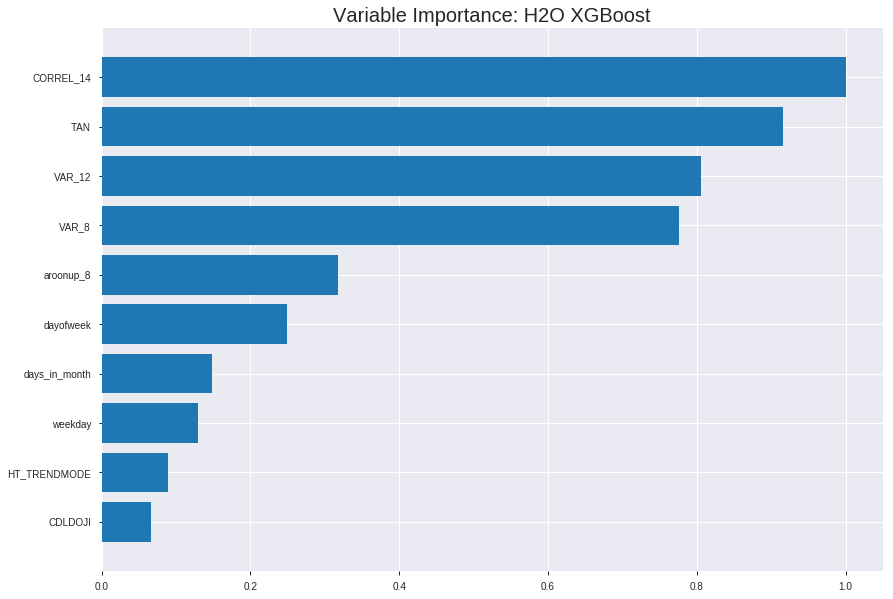

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_002348_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08143925018322833
RMSE: 0.28537562997429955
LogLoss: 0.3270017964125191
Mean Per-Class Error: 0.004519485984333493
AUC: 0.9998840119980147
pr_auc: 0.9977036464792568
Gini: 0.9997680239960294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5317506194114685: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      811  2    0.0025   (2.0/813.0)
1      6    906  0.0066   (6.0/912.0)
Total  817  908  0.0046   (8.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531751     0.995604  206
max f2                       0.471534     0.997594  217
max f0point5                 0.531751     0.996919  206
max accuracy                 0.531751     0.995362  206
max precision                0.909017     1         0
max recall                   0.471534     1         217
max specificity              0.909017     1         0
max absolute_mcc             0.531751     0.990707  206
max min_per_class_accuracy   0.51913      0.99385   209
max mean_per_class_accuracy  0.531751     0.995481  206

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.875338           1.89145   1.89145            1                0.886649  1                           0.886649            0.0197368       0.0197368                  89.1447   89.1447
    2        0.0202899                   0.863914           1.89145   1.89145            1                0.869251  1                           0.878198            0.0186404       0.0383772                  89.1447   89.1447
    3        0.0301449                   0.853825           1.89145   1.89145            1                0.858747  1                           0.871839            0.0186404       0.0570175                  89.1447   89.1447
    4        0.04                        0.843645           1.89145   1.89145            1                0.850594  1                           0.866605            0.0186404       0.0756579                  89.1447   89.1447
    5        0.0504348                   0.833774           1.89145   1.89145            1                0.839733  1                           0.861045            0.0197368       0.0953947                  89.1447   89.1447
    6        0.10029                     0.80912            1.89145   1.89145            1                0.820199  1                           0.84074             0.0942982       0.189693                   89.1447   89.1447
    7        0.150145                    0.789843           1.89145   1.89145            1                0.799063  1                           0.826901            0.0942982       0.283991                   89.1447   89.1447
    8        0.2                         0.766485           1.89145   1.89145            1                0.777817  1                           0.814666            0.0942982       0.378289                   89.1447   89.1447
    9        0.30029                     0.729083           1.89145   1.89145            1                0.747829  1                           0.792344            0.189693        0.567982                   89.1447   89.1447
    10       0.4                         0.680513           1.89145   1.89145            1                0.704809  1                           0.770524            0.188596        0.756579                   89.1447   89.1447
    11       0.50029                     0.601442           1.89145   1.89145            1                0.646003  1                           0.745562            0.189693        0.946272                   89.1447   89.1447
    12       0.6                         0.359921           0.538843  1.66667            0.284884         0.451511  0.881159                    0.696695            0.0537281       1                          -46.1157  66.6667
    13       0.69971                     0.308112           0         1.42916            0                0.332116  0.755592                    0.644742            0               1                          -100      42.9163
    14       0.8                         0.266458           0         1.25               0                0.28754   0.66087                     0.599962            0               1                          -100      25
    15       0.89971                     0.226826           0         1.11147            0                0.246692  0.587629                    0.560811            0               1                          -100      11.1469
    16       1                           0.102869           0         1                  0                0.19103   0.528696                    0.523726            0 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.29847200933262297
RMSE: 0.5463259185986172
LogLoss: 0.815266890501974
Mean Per-Class Error: 0.45401287838555493
AUC: 0.5201639670738184
pr_auc: 0.557722694122783
Gini: 0.0403279341476368
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12261325120925903: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    221  0.9866   (221.0/224.0)
1      1    268  0.0037   (1.0/269.0)
Total  4    489  0.4503   (222.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.122613     0.707124   395
max f2                       0.108011     0.857781   398
max f0point5                 0.122613     0.602247   395
max accuracy                 0.293238     0.549696   259
max precision                0.732561     0.692308   23
max recall                   0.108011     1          398
max specificity              0.894575     0.995536   0
max absolute_mcc             0.472159     0.0963475  150
max min_per_class_accuracy   0.382575     0.509294   209
max mean_per_class_accuracy  0.472159     0.545987   150

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 39.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.834657           0.366543  0.366543           0.2              0.869516  0.2                         0.869516            0.00371747      0.00371747                 -63.3457  -63.3457
    2        0.020284                    0.789637           1.09963   0.733086           0.6              0.816688  0.4                         0.843102            0.0111524       0.0148699                  9.96283   -26.6914
    3        0.030426                    0.77046            1.46617   0.977447           0.8              0.779477  0.533333                    0.821893            0.0148699       0.0297398                  46.6171   -2.25527
    4        0.040568                    0.751584           1.46617   1.09963            0.8              0.766001  0.6                         0.80792             0.0148699       0.0446097                  46.6171   9.96283
    5        0.0507099                   0.733774           1.83271   1.24625            1                0.740987  0.68                        0.794534            0.0185874       0.063197                   83.2714   24.6245
    6        0.10142                     0.666296           0.806394  1.02632            0.44             0.703403  0.56                        0.748969            0.0408922       0.104089                   -19.3606  2.63197
    7        0.150101                    0.612667           0.839994  0.96589            0.458333         0.638041  0.527027                    0.712992            0.0408922       0.144981                   -16.0006  -3.41103
    8        0.200811                    0.572596           1.17294   1.01817            0.64             0.595475  0.555556                    0.683316            0.0594796       0.204461                   17.2937   1.81743
    9        0.300203                    0.496966           1.27168   1.1021             0.693878         0.532752  0.601351                    0.633467            0.126394        0.330855                   27.1679   10.2105
    10       0.399594                    0.439073           0.97246   1.06986            0.530612         0.468252  0.583756                    0.592373            0.0966543       0.427509                   -2.75396  6.98583
    11       0.501014                    0.382101           0.806394  1.01653            0.44             0.406989  0.554656                    0.554846            0.0817844       0.509294                   -19.3606  1.65254
    12       0.600406                    0.307077           1.15947   1.04019            0.632653         0.345946  0.567568                    0.520264            0.115242        0.624535                   15.9472   4.01889
    13       0.699797                    0.264323           0.822851  1.00932            0.44898          0.283256  0.550725                    0.486602            0.0817844       0.70632                    -17.7149  0.932062
    14       0.799189                    0.210579           0.897656  0.995433           0.489796         0.23747   0.543147                    0.455619            0.0892193       0.795539                   -10.2344  -0.456664
    15       0.89858                     0.171833           0.860253  0.980481           0.469388         0.188945  0.534989                    0.426122            0.0855019       0.881041                   -13.9747  -1.95188
    16       1                           0.103556           1.17294   1                  0.64             0.149105  0.545639                    0.398027 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:24:03  2.900 sec   0                  0.5              0.693147            0.5             0                  1                0.471304                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:24:03  3.227 sec   5                  0.460219         0.616263            0.948457        0.952167           1.89145          0.125797                         0.502671           0.698576              0.511683          0.542425             0.733086           0.454361
    2019-07-25 00:24:03  3.447 sec   10                 0.430318         0.561514            0.978699        0.980367           1.89145          0.0782609                        0.507675           0.709119              0.515335          0.54248              0.305452           0.452333
    2019-07-25 00:24:04  3.659 sec   15                 0.402739         0.513104            0.99047         0.989888           1.89145          0.0469565                        0.513474           0.722193              0.519334          0.552671             0                  0.454361
    2019-07-25 00:24:04  3.860 sec   20                 0.383372         0.480053            0.994346        0.992804           1.89145          0.035942                         0.519598           0.73677               0.516903          0.552273             0                  0.454361
    2019-07-25 00:24:04  4.115 sec   25                 0.35998          0.441461            0.997075        0.996228           1.89145          0.0243478                        0.52604            0.753602              0.520952          0.555918             0                  0.454361
    2019-07-25 00:24:04  4.375 sec   30                 0.342222         0.413087            0.998876        0.997913           1.89145          0.0144928                        0.530487           0.76611               0.522064          0.554588             0.366543           0.454361
    2019-07-25 00:24:05  4.617 sec   35                 0.325616         0.387257            0.999444        0.998408           1.89145          0.0110145                        0.537391           0.784991              0.517343          0.55486              0.366543           0.454361
    2019-07-25 00:24:05  4.859 sec   40                 0.313085         0.36797             0.99963         0.997477           1.89145          0.00811594                       0.538897           0.790551              0.519284          0.557132             0.366543           0.448276
    2019-07-25 00:24:05  5.133 sec   45                 0.298105         0.345444            0.999817        0.998741           1.89145          0.00695652                       0.543446           0.805654              0.518629          0.556466             0.366543           0.452333
    2019-07-25 00:24:05  5.465 sec   50                 0.285376         0.327002            0.999884        0.997704           1.89145          0.00463768                       0.546326           0.815267              0.520164          0.557723             0.366543           0.450304

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
CORREL_14           4111.83349609375       1.0                    0.2034415106856163
TAN                 3767.242919921875      0.9161953964091112     0.18639217552867668
VAR_12              3313.143798828125      0.8057582589313547     0.16392467744440678
VAR_8               3193.68505859375       0.7767058324778368     0.15801420791762033
aroonup_8           1309.017822265625      0.3183538009282707     0.06476637819335535
---                 ---                    ---                    ---
CDLUNIQUE3RIVER     4.835205554962158      0.0011759244530586204  0.00023923184718240286
CDLUPSIDEGAP2CROWS  2.8788623809814453     0.0007001407969744811  0.00014243770142911982
CDLSTALLEDPATTERN   2.7620058059692383     0.0006717212184280198  0.0001366559794365792
CDLHIKKAKEMOD       2.347238540649414      0.0005708496083023049  0.00011613450668731324
CDLSTICKSANDWICH    2.1265270709991455     0.000517172466496844   0.00010521434786912421


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5384615384615384)

('F1', 0.675603217158177)

('auc', 0.48124098124098125)

('logloss', 0.8504235615630744)

('mean_per_class_error', 0.46812278630460447)

('rmse', 0.5600117177748808)

('mse', 0.3136131240451728)

xgboost prediction progress: |████████████████████████████████████████████| 100%


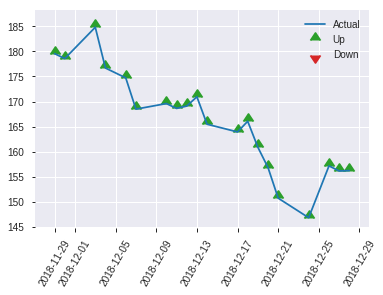


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3136131240451728
RMSE: 0.5600117177748808
LogLoss: 0.8504235615630744
Mean Per-Class Error: 0.46812278630460447
AUC: 0.48124098124098125
pr_auc: 0.4988932923407729
Gini: -0.037518037518037506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09237360954284668: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0923736    0.675603  246
max f2                       0.0923736    0.838881  246
max f0point5                 0.173453     0.574949  211
max accuracy                 0.17894      0.538462  203
max precision                0.565921     0.666667  5
max recall                   0.0923736    1         246
max specificity              0.759628     0.991736  0
max absolute_mcc             0.38827      0.109783  51
max min_per_class_accuracy   0.280566     0.46281   123
max mean_per_class_accuracy  0.17894      0.531877  203

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 29.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.590796           0.653439  0.653439           0.333333         0.666683  0.333333                    0.666683            0.00793651      0.00793651                 -34.6561  -34.6561
    2        0.0202429                   0.567217           1.96032   1.17619            1                0.58548   0.6                         0.634202            0.015873        0.0238095                  96.0317   17.619
    3        0.0323887                   0.54403            1.30688   1.2252             0.666667         0.553535  0.625                       0.603952            0.015873        0.0396825                  30.6878   22.5198
    4        0.0404858                   0.538058           0.980159  1.17619            0.5              0.543346  0.6                         0.591831            0.00793651      0.047619                   -1.98413  17.619
    5        0.0526316                   0.523728           0.653439  1.05556            0.333333         0.531879  0.538462                    0.577996            0.00793651      0.0555556                  -34.6561  5.55556
    6        0.101215                    0.465521           1.14352   1.09778            0.583333         0.494909  0.56                        0.538114            0.0555556       0.111111                   14.3519   9.77778
    7        0.149798                    0.407839           0.490079  0.900686           0.25             0.437644  0.459459                    0.505529            0.0238095       0.134921                   -50.9921  -9.93136
    8        0.202429                    0.38878            0.603175  0.823333           0.307692         0.398313  0.42                        0.477653            0.031746        0.166667                   -39.6825  -17.6667
    9        0.299595                    0.342756           1.2252    0.953668           0.625            0.367021  0.486486                    0.441772            0.119048        0.285714                   22.5198   -4.6332
    10       0.40081                     0.30984            1.01937   0.970258           0.52             0.324049  0.494949                    0.412044            0.103175        0.388889                   1.93651   -2.97419
    11       0.502024                    0.280566           0.784127  0.932732           0.4              0.294551  0.475806                    0.388356            0.0793651       0.468254                   -21.5873  -6.72683
    12       0.59919                     0.242633           1.06184   0.953668           0.541667         0.261721  0.486486                    0.367821            0.103175        0.571429                   6.18386   -4.6332
    13       0.700405                    0.21974            1.17619   0.985824           0.6              0.230457  0.50289                     0.34797             0.119048        0.690476                   17.619    -1.41756
    14       0.797571                    0.188199           1.30688   1.02494            0.666667         0.201075  0.522843                    0.330075            0.126984        0.81746                    30.6878   2.49376
    15       0.898785                    0.159564           0.940952  1.01548            0.48             0.174464  0.518018                    0.312551            0.0952381       0.912698                   -5.90476  1.54798
    16       1                           0.0923736          0.86254   1                  0.44             0.138101  0.510121                    0.294894     

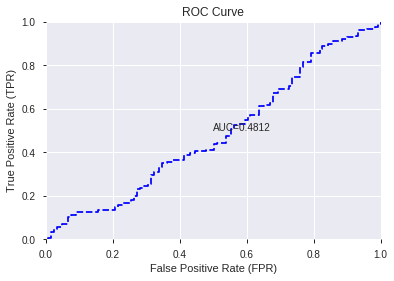

This function is available for GLM models only


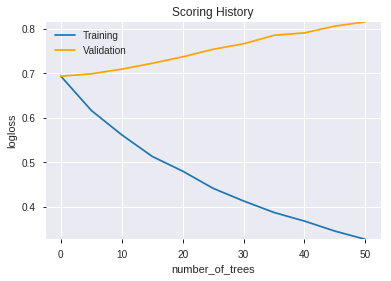

--2019-07-25 00:24:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_002348_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_002348_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_14',
 'TAN',
 'VAR_12',
 'VAR_8',
 'aroonup_8',
 'dayofweek',
 'days_in_month',
 'weekday',
 'HT_TRENDMODE',
 'CDLDOJI',
 'is_month_start',
 'is_month_end',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDARKCLOUDCOVER',
 'TANH',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLHAMMER',
 'COSH',
 'CDL3INSIDE',
 'is_quarter_start',
 'CDLTHRUSTING',
 'EXP',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'SINH',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLSTALLEDPATTERN',
 'CDLHIKKAKEMOD',
 'CDLSTICKSANDWICH']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_002424_model_1  0.5  17.618971                   0.5  0.714228  0.510121

variable  relative_importance  scaled_importance    percentage
0                 weekday_name         9.514869e-03           1.000000  1.614819e-02
1                      weekday         7.052485e-03           0.741207  1.196914e-02
2                    dayofweek         7.048235e-03           0.740760  1.196193e-02
3                         SINH         5.363361e-03           0.563682  9.102443e-03
4                          EXP         5.362999e-03           0.563644  9.101828e-03
...                        ...                  ...                ...           ...
1038   BBANDS_middleband_8_1_4         5.184798e-07           0.000054  8.799395e-07
1039   BBANDS_upperband_20_3_2         4.779191e-07           0.000050  8.111017e-07
1040   BBANDS_middleband_8_2_3         4.704846e-07           0.000049  7.984842e-07
1041                  MAVP_8_2         2.906653e-07           0.000031  4.933034e-07
1042  BBANDS_middleband_24_3_5         4.051123e-08           0.000004  6.875374e-08

[1043 rows x 4 columns]

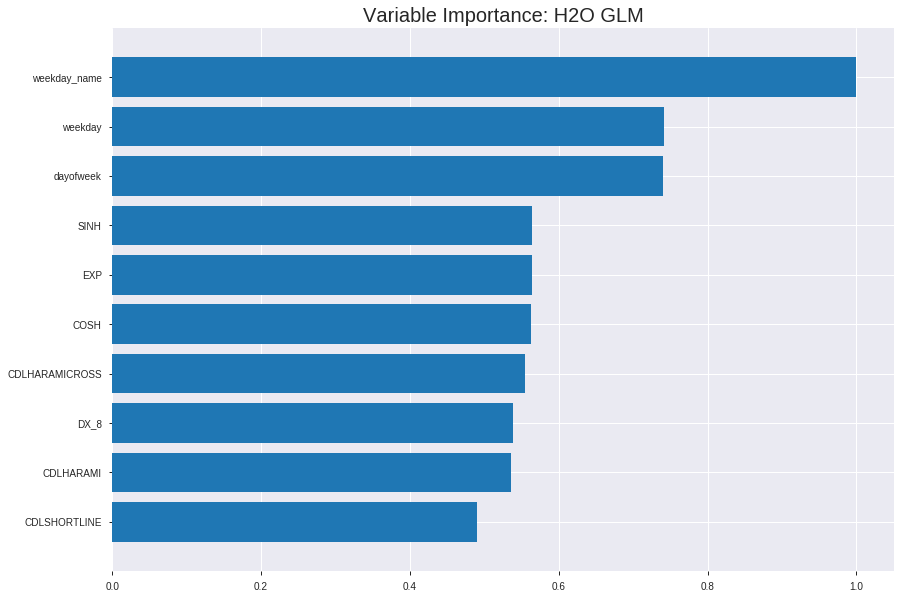

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_002424_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24497428016608094
RMSE: 0.49494876519300557
LogLoss: 0.6830330218077137
Null degrees of freedom: 1724
Residual degrees of freedom: 681
Null deviance: 2385.6729106355115
Residual deviance: 2356.4639252366123
AIC: 4444.463925236612
AUC: 0.5798644828553549
pr_auc: 0.5929111426150313
Gini: 0.1597289657107097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44535919278037306: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   788   0.9692   (788.0/813.0)
1      6    906   0.0066   (6.0/912.0)
Total  31   1694  0.4603   (794.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445359     0.695318  381
max f2                       0.434927     0.850112  392
max f0point5                 0.478892     0.597636  318
max accuracy                 0.524658     0.563478  210
max precision                0.622111     1         0
max recall                   0.434927     1         392
max specificity              0.622111     1         0
max absolute_mcc             0.55677      0.133618  117
max min_per_class_accuracy   0.531057     0.554825  190
max mean_per_class_accuracy  0.524658     0.560133  210

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.608131           1.26096   1.26096            0.666667         0.611985  0.666667                    0.611985            0.0131579       0.0131579                  26.0965    26.0965
    2        0.0202899                   0.602973           1.22388   1.24295            0.647059         0.605049  0.657143                    0.608616            0.0120614       0.0252193                  22.3878    24.2951
    3        0.0301449                   0.600506           0.890093  1.12759            0.470588         0.601878  0.596154                    0.606413            0.00877193      0.0339912                  -10.9907   12.7594
    4        0.04                        0.596625           1.22388   1.15132            0.647059         0.598425  0.608696                    0.604445            0.0120614       0.0460526                  22.3878    15.1316
    5        0.0504348                   0.594164           1.68129   1.26096            0.888889         0.595433  0.666667                    0.602581            0.0175439       0.0635965                  68.1287    26.0965
    6        0.10029                     0.581872           1.12167   1.19172            0.593023         0.587178  0.630058                    0.594924            0.0559211       0.119518                   12.1672    19.1721
    7        0.150145                    0.572147           1.18765   1.19037            0.627907         0.576617  0.629344                    0.588845            0.0592105       0.178728                   18.7653    19.037
    8        0.2                         0.565429           1.16566   1.18421            0.616279         0.568873  0.626087                    0.583866            0.058114        0.236842                   16.5659    18.4211
    9        0.30029                     0.552527           1.09332   1.15386            0.578035         0.558467  0.610039                    0.575384            0.109649        0.346491                   9.33222    15.3856
    10       0.4                         0.541989           1.05569   1.12939            0.55814          0.547522  0.597101                    0.568438            0.105263        0.451754                   5.56916    12.9386
    11       0.50029                     0.53136            0.994923  1.10243            0.526012         0.535988  0.582851                    0.561933            0.0997807       0.551535                   -0.507682  10.2431
    12       0.6                         0.519876           0.978714  1.08187            0.517442         0.525623  0.571981                    0.555899            0.0975877       0.649123                   -2.1286    8.18713
    13       0.69971                     0.508362           0.92373   1.05934            0.488372         0.514462  0.560066                    0.549994            0.0921053       0.741228                   -7.62699   5.93359
    14       0.8                         0.491934           0.929324  1.04304            0.491329         0.500829  0.551449                    0.543831            0.0932018       0.83443                    -7.06761   4.30373
    15       0.89971                     0.470714           0.934727  1.03103            0.494186         0.481392  0.545103                    0.536911            0.0932018       0.927632                   -6.52731   3.10338
    16       1                           0.396972           0.721593  1                  0.381503         0.454995  0.528696                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38441648380114685
RMSE: 0.6200132932455132
LogLoss: 8.578927880245645
Null degrees of freedom: 492
Residual degrees of freedom: -551
Null deviance: 679.8987251155328
Residual deviance: 155628.35466432944
AIC: 157716.35466432944
AUC: 0.500431492299522
pr_auc: 0.5312825520962094
Gini: 0.0008629845990439922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.429118359615254e-56: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.42912e-56  0.706037  278
max f2                       3.42912e-56  0.857234  278
max f0point5                 3.42912e-56  0.600178  278
max accuracy                 3.42912e-56  0.545639  278
max precision                0.53826      1         0
max recall                   3.42912e-56  1         278
max specificity              0.53826      1         0
max absolute_mcc             0.511925     0.142619  29
max min_per_class_accuracy   0.466118     0.508929  246
max mean_per_class_accuracy  0.464078     0.520264  252

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 26.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.52698            1.46617   1.46617            0.8              0.533511   0.8                         0.533511            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.521671           0.366543  0.916357           0.2              0.523901   0.5                         0.528706            0.00371747      0.0185874                  -63.3457  -8.36431
    3        0.030426                    0.515885           0         0.610905           0                0.518919   0.333333                    0.525444            0               0.0185874                  -100      -38.9095
    4        0.040568                    0.514267           0.366543  0.549814           0.2              0.515445   0.3                         0.522944            0.00371747      0.0223048                  -63.3457  -45.0186
    5        0.0507099                   0.513279           0.366543  0.51316            0.2              0.51363    0.28                        0.521081            0.00371747      0.0260223                  -63.3457  -48.684
    6        0.10142                     0.505103           1.24625   0.879703           0.68             0.508925   0.48                        0.515003            0.063197        0.0892193                  24.6245   -12.0297
    7        0.150101                    0.498535           0.763631  0.842058           0.416667         0.501879   0.459459                    0.510746            0.0371747       0.126394                   -23.6369  -15.7942
    8        0.200811                    0.495328           1.09963   0.907101           0.6              0.497112   0.494949                    0.507303            0.0557621       0.182156                   9.96283   -9.28993
    9        0.300203                    0.487321           1.15947   0.990656           0.632653         0.491038   0.540541                    0.501918            0.115242        0.297398                   15.9472   -0.934392
    10       0.399594                    0.479738           1.15947   1.03265            0.632653         0.483829   0.563452                    0.497419            0.115242        0.412639                   15.9472   3.26458
    11       0.501014                    0.466118           0.953011  1.01653            0.52             0.475138   0.554656                    0.492909            0.0966543       0.509294                   -4.69888  1.65254
    12       1                           0                  0.983407  1                  0.536585         0.0390994  0.545639                    0.266464            0.490706        1                          -1.65926  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:24:28  0.000 sec   2            4.4       1044          1.36607           315.676
    2019-07-25 00:24:30  1.847 sec   4            3.2       1044          1.36286           318.029
    2019-07-25 00:24:31  3.655 sec   6            2.3       1044          1.35895           320.689
    2019-07-25 00:24:33  5.491 sec   8            1.7       1044          1.35432           322.779
    2019-07-25 00:24:35  7.288 sec   10           1.2       1044          1.34897           325.085

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

glm prediction progress: |████████████████████████████████████████████████| 100%


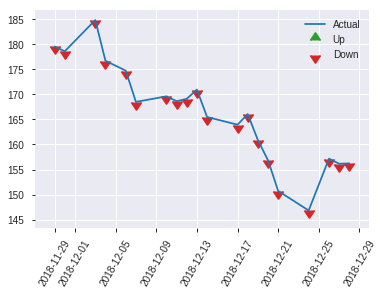


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Null degrees of freedom: 246
Residual degrees of freedom: -797
Null deviance: 342.65506474663505
Residual deviance: 178515.89747013059
AIC: 180603.89747013059
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

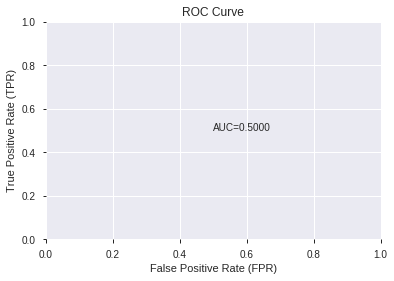

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


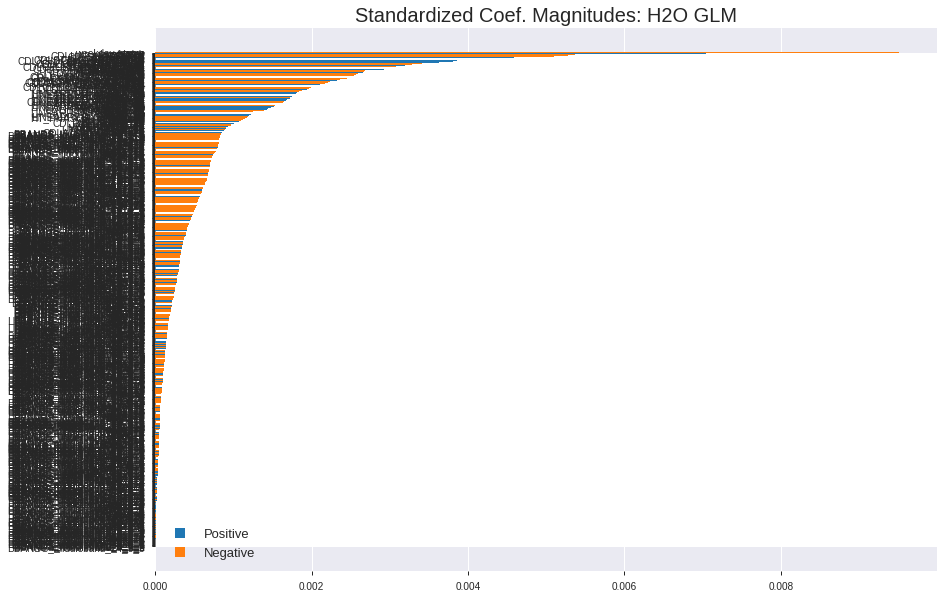

'log_likelihood'
--2019-07-25 00:24:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_002424_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_002424_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

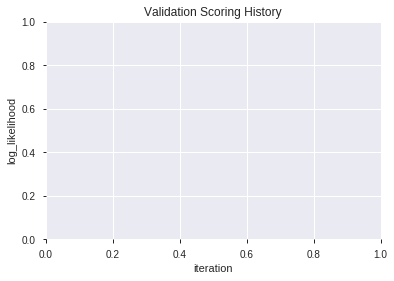

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190725_002510  0.546307  0.701769              0.444805  0.504116  0.254133
1               XGBoost_2_AutoML_20190725_002510  0.520464  0.710003              0.500000  0.507851  0.257913
2  XGBoost_grid_1_AutoML_20190725_002510_model_4  0.516398  0.709869              0.470746  0.508095  0.258160
3  XGBoost_grid_1_AutoML_20190725_002510_model_7  0.515873  0.709698              0.482979  0.507892  0.257954
4  XGBoost_grid_1_AutoML_20190725_002510_model_1  0.515283  0.750714              0.457202  0.526129  0.276812
5  XGBoost_grid_1_AutoML_20190725_002510_model_2  0.512659  0.707459              0.491736  0.506878  0.256925
6               XGBoost_3_AutoML_20190725_002510  0.509445  0.720648              0.478519  0.512939  0.263107
7  XGBoost_grid_1_AutoML_20190725_002510_model_5  0.492785  0.749172              0.483307  0.524611  0.275217
8  XGBoost_grid_1_AutoML_20190725_002510_model_3  0.491670  0.746119              0.500000  0.523978  0.274553
9  XGBoost_grid_1_AutoML_20190725_002510_model_6  0.455529  0.772370              0.487603  0.534902  0.286120

variable  relative_importance  scaled_importance    percentage
0               STOCHF_fastk           141.003845           1.000000  1.614163e-02
1                        TAN           135.630035           0.961889  1.552645e-02
2       HT_PHASOR_quadrature           132.385529           0.938879  1.515503e-02
3                  dayofweek           121.216011           0.859665  1.387638e-02
4                  CORREL_30           118.623978           0.841282  1.357966e-02
..                       ...                  ...                ...           ...
293   BBANDS_lowerband_8_1_5             1.232623           0.008742  1.411064e-04
294  BBANDS_upperband_12_0_4             1.050007           0.007447  1.202011e-04
295                    VAR_8             1.012764           0.007183  1.159377e-04
296  BBANDS_lowerband_30_0_2             0.975512           0.006918  1.116731e-04
297   BBANDS_lowerband_8_0_5             0.004335           0.000031  4.963018e-07

[298 rows x 4 columns]

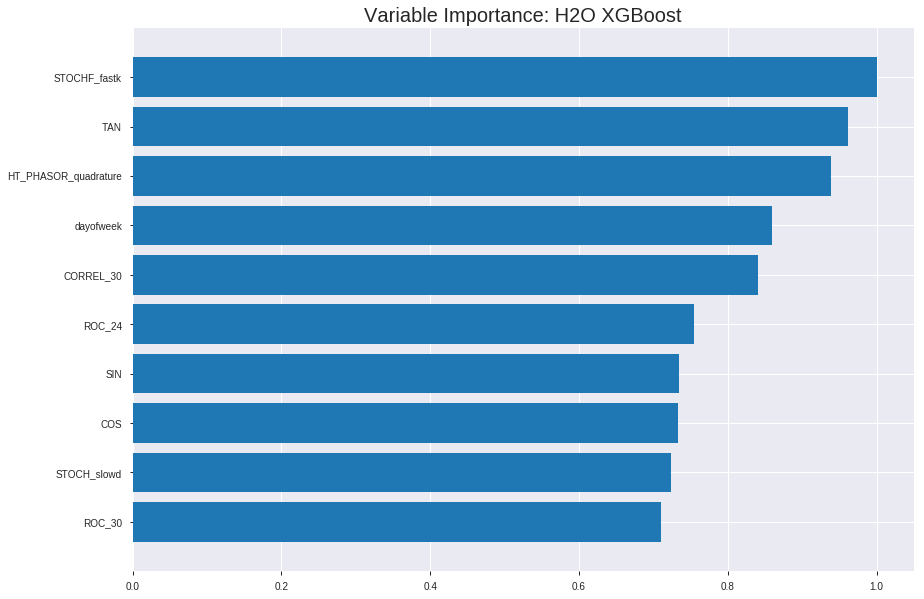

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190725_002510


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13651291349933065
RMSE: 0.36947653984973206
LogLoss: 0.4541350065685518
Mean Per-Class Error: 0.06497013983297728
AUC: 0.981267263330528
pr_auc: 0.9834752735971414
Gini: 0.9625345266610561
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5415639281272888: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      775  38   0.0467   (38.0/813.0)
1      76   836  0.0833   (76.0/912.0)
Total  851  874  0.0661   (114.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.541564     0.93617   186
max f2                       0.489257     0.949299  215
max f0point5                 0.543287     0.948864  185
max accuracy                 0.543287     0.933913  185
max precision                0.848614     1         0
max recall                   0.369889     1         292
max specificity              0.848614     1         0
max absolute_mcc             0.543287     0.868678  185
max min_per_class_accuracy   0.526357     0.932018  194
max mean_per_class_accuracy  0.543287     0.93503   185

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.803711           1.89145    1.89145            1                0.816926  1                           0.816926            0.0197368       0.0197368                  89.1447   89.1447
    2        0.0202899                   0.788              1.89145    1.89145            1                0.795531  1                           0.806534            0.0186404       0.0383772                  89.1447   89.1447
    3        0.0301449                   0.772992           1.89145    1.89145            1                0.780287  1                           0.797953            0.0186404       0.0570175                  89.1447   89.1447
    4        0.04                        0.766422           1.89145    1.89145            1                0.769866  1                           0.791033            0.0186404       0.0756579                  89.1447   89.1447
    5        0.0504348                   0.761709           1.89145    1.89145            1                0.764012  1                           0.785442            0.0197368       0.0953947                  89.1447   89.1447
    6        0.10029                     0.726762           1.89145    1.89145            1                0.742098  1                           0.763895            0.0942982       0.189693                   89.1447   89.1447
    7        0.150145                    0.707388           1.89145    1.89145            1                0.715899  1                           0.747958            0.0942982       0.283991                   89.1447   89.1447
    8        0.2                         0.687327           1.89145    1.89145            1                0.69755   1                           0.735393            0.0942982       0.378289                   89.1447   89.1447
    9        0.30029                     0.653194           1.88051    1.8878             0.99422          0.670122  0.998069                    0.713594            0.188596        0.566886                   88.0514   88.7796
    10       0.4                         0.603633           1.84746    1.87774            0.976744         0.63109   0.992754                    0.693028            0.184211        0.751096                   84.746    87.7741
    11       0.50029                     0.545234           1.55252    1.81255            0.820809         0.575038  0.958285                    0.669375            0.155702        0.906798                   55.2517   81.2546
    12       0.6                         0.467121           0.61582    1.61367            0.325581         0.505278  0.85314                     0.642105            0.0614035       0.968202                   -38.418   61.367
    13       0.69971                     0.406987           0.252926   1.41976            0.133721         0.435496  0.750621                    0.612663            0.0252193       0.993421                   -74.7074  41.9761
    14       0.8                         0.342712           0.0655993  1.25               0.0346821        0.375621  0.66087                     0.582947            0.00657895      1                          -93.4401  25
    15       0.89971                     0.287528           0          1.11147            0                0.316763  0.587629                    0.553447            0               1                          -100      11.1469
    16       1                           0.152421           0          1                  0                0.248944  0.528696                    0.522



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2683731300046561
RMSE: 0.5180474206138431
LogLoss: 0.7322144943850547
Mean Per-Class Error: 0.46493295273499735
AUC: 0.5016097981943707
pr_auc: 0.5387605526068368
Gini: 0.0032195963887413637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19566334784030914: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.195663     0.706037   399
max f2                       0.195663     0.857234   399
max f0point5                 0.314614     0.60643    359
max accuracy                 0.314614     0.559838   359
max precision                0.691215     0.727273   10
max recall                   0.195663     1          399
max specificity              0.771795     0.995536   0
max absolute_mcc             0.756624     0.0857462  2
max min_per_class_accuracy   0.450437     0.491071   204
max mean_per_class_accuracy  0.387449     0.535067   280

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.723478           0.733086  0.733086           0.4              0.750952  0.4                         0.750952            0.00743494      0.00743494                 -26.6914  -26.6914
    2        0.020284                    0.691557           1.83271   1.2829             1                0.705157  0.7                         0.728055            0.0185874       0.0260223                  83.2714   28.29
    3        0.030426                    0.675335           0.733086  1.09963            0.4              0.686783  0.6                         0.714297            0.00743494      0.0334572                  -26.6914  9.96283
    4        0.040568                    0.661743           1.46617   1.19126            0.8              0.668107  0.65                        0.70275             0.0148699       0.0483271                  46.6171   19.1264
    5        0.0507099                   0.652223           0.366543  1.02632            0.2              0.656766  0.56                        0.693553            0.00371747      0.0520446                  -63.3457  2.63197
    6        0.10142                     0.610705           0.733086  0.879703           0.4              0.631016  0.48                        0.662285            0.0371747       0.0892193                  -26.6914  -12.0297
    7        0.150101                    0.584197           1.06908   0.941123           0.583333         0.59845   0.513514                    0.641582            0.0520446       0.141264                   6.9083    -5.88767
    8        0.200811                    0.557993           0.733086  0.888588           0.4              0.572115  0.484848                    0.624039            0.0371747       0.178439                   -26.6914  -11.1412
    9        0.300203                    0.515451           0.935058  0.903974           0.510204         0.535573  0.493243                    0.59475             0.0929368       0.271375                   -6.4942   -9.60263
    10       0.399594                    0.48304            1.23428   0.98613            0.673469         0.500217  0.538071                    0.571237            0.122677        0.394052                   23.4277   -1.38698
    11       0.501014                    0.450401           0.989665  0.986846           0.54             0.467702  0.538462                    0.550278            0.100372        0.494424                   -1.03346  -1.31541
    12       0.600406                    0.422594           1.19687   1.02161            0.653061         0.43634   0.557432                    0.531417            0.118959        0.613383                   19.6874   2.16141
    13       0.699797                    0.389699           1.12207   1.03588            0.612245         0.404868  0.565217                    0.513443            0.111524        0.724907                   12.207    3.58817
    14       0.799189                    0.356557           0.860253  1.01404            0.469388         0.372739  0.553299                    0.495944            0.0855019       0.810409                   -13.9747  1.40396
    15       0.89858                     0.317277           1.04727   1.01771            0.571429         0.338185  0.555305                    0.478495            0.104089        0.914498                   4.7265    1.77146
    16       1                           0.195663           0.843048  1                  0.46             0.277271  0.545639                    0.458087    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:25:10  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.471304                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:25:11  0.937 sec   5                  0.480839         0.655435            0.83507         0.835911           1.68129          0.250435                         0.501362           0.695886              0.500224          0.555496             1.09963            0.454361
    2019-07-25 00:25:12  1.212 sec   10                 0.465037         0.625112            0.877337        0.88132            1.78637          0.213913                         0.504102           0.701454              0.484201          0.545643             0.733086           0.454361
    2019-07-25 00:25:12  1.473 sec   15                 0.449113         0.595184            0.913297        0.921563           1.89145          0.171014                         0.503858           0.701024              0.513434          0.557109             0.733086           0.452333
    2019-07-25 00:25:12  1.701 sec   20                 0.434196         0.567768            0.936194        0.942003           1.89145          0.13913                          0.507332           0.708308              0.50785           0.546338             0.733086           0.452333
    2019-07-25 00:25:12  1.912 sec   25                 0.421864         0.545371            0.947199        0.952834           1.89145          0.129275                         0.50717            0.70803               0.509161          0.549216             1.09963            0.452333
    2019-07-25 00:25:12  2.120 sec   30                 0.409475         0.523181            0.955681        0.961206           1.89145          0.113043                         0.507613           0.709027              0.511094          0.547678             1.09963            0.452333
    2019-07-25 00:25:13  2.337 sec   35                 0.399139         0.504976            0.963133        0.967309           1.89145          0.108986                         0.510711           0.715674              0.512381          0.546598             1.09963            0.454361
    2019-07-25 00:25:13  2.566 sec   40                 0.388639         0.486713            0.970474        0.974448           1.89145          0.0898551                        0.51261            0.719949              0.510978          0.549688             0.733086           0.452333
    2019-07-25 00:25:13  2.779 sec   45                 0.379342         0.470766            0.976382        0.979495           1.89145          0.0776812                        0.515783           0.727065              0.504838          0.544488             0.733086           0.450304
    2019-07-25 00:25:13  3.005 sec   50                 0.369477         0.454135            0.981267        0.983475           1.89145          0.066087                         0.518047           0.732214              0.50161           0.538761             0.733086           0.454361

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
STOCHF_fastk             141.00384521484375     1.0                    0.01614162568773765
TAN                      135.63003540039062     0.9618889129848537     0.015526450786586363
HT_PHASOR_quadrature     132.38552856445312     0.9388788537131089     0.015155031022769199
dayofweek                121.21601104736328     0.8596645776763727     0.013876383829859078
CORREL_30                118.62397766113281     0.8412818634866919     0.013579656938284586
---                      ---                    ---                    ---
BBANDS_lowerband_8_1_5   1.2326233386993408     0.008741771097243667   0.00014110639689959094
BBANDS_upperband_12_0_4  1.0500068664550781     0.007446654130993456   0.00012020110360854168
VAR_8                    1.0127639770507812     0.007182527366595288   0.00011593766824351318
BBANDS_lowerband_30_0_2  0.9755115509033203     0.006918332967565244   0.0001116731411455734
BBANDS_lowerband_8_0_5   0.0043354034423828125  3.074670365036553e-05  4.963017814559972e-07


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6842105263157894)

('auc', 0.54630722812541)

('logloss', 0.7017689542885338)

('mean_per_class_error', 0.44480519480519476)

('rmse', 0.5041156741856685)

('mse', 0.2541326129596711)

xgboost prediction progress: |████████████████████████████████████████████| 100%


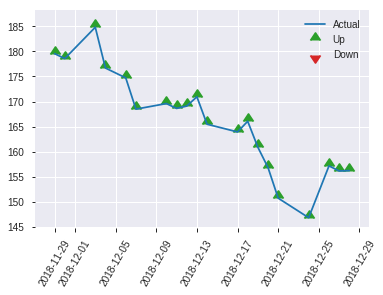


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541326129596711
RMSE: 0.5041156741856685
LogLoss: 0.7017689542885338
Mean Per-Class Error: 0.44480519480519476
AUC: 0.54630722812541
pr_auc: 0.5386558404419272
Gini: 0.09261445625081999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34878790378570557: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   99   0.8182   (99.0/121.0)
1      9    117  0.0714   (9.0/126.0)
Total  31   216  0.4372   (108.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348788     0.684211  215
max f2                       0.260309     0.84      245
max f0point5                 0.348788     0.590909  215
max accuracy                 0.348788     0.562753  215
max precision                0.68094      1         0
max recall                   0.260309     1         245
max specificity              0.68094      1         0
max absolute_mcc             0.348788     0.166571  215
max min_per_class_accuracy   0.456316     0.52381   120
max mean_per_class_accuracy  0.348788     0.555195  215

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.664922           1.30688   1.30688            0.666667         0.676403  0.666667                    0.676403            0.015873        0.015873                   30.6878   30.6878
    2        0.0202429                   0.64916            0.980159  1.17619            0.5              0.653322  0.6                         0.66717             0.00793651      0.0238095                  -1.98413  17.619
    3        0.0323887                   0.641466           0.653439  0.980159           0.333333         0.645921  0.5                         0.659202            0.00793651      0.031746                   -34.6561  -1.98413
    4        0.0404858                   0.6383             0.980159  0.980159           0.5              0.63871   0.5                         0.655104            0.00793651      0.0396825                  -1.98413  -1.98413
    5        0.0526316                   0.634117           1.30688   1.05556            0.666667         0.636357  0.538462                    0.650777            0.015873        0.0555556                  30.6878   5.55556
    6        0.101215                    0.591708           1.47024   1.2546             0.75             0.613014  0.64                        0.632651            0.0714286       0.126984                   47.0238   25.4603
    7        0.149798                    0.552243           0.816799  1.11261            0.416667         0.573668  0.567568                    0.613521            0.0396825       0.166667                   -18.3201  11.2613
    8        0.202429                    0.538727           0.904762  1.05857            0.461538         0.544645  0.54                        0.595613            0.047619        0.214286                   -9.52381  5.85714
    9        0.299595                    0.504759           1.06184   1.05963            0.541667         0.519581  0.540541                    0.570954            0.103175        0.31746                    6.18386   5.96311
    10       0.40081                     0.475947           1.09778   1.06926            0.56             0.487617  0.545455                    0.549909            0.111111        0.428571                   9.77778   6.92641
    11       0.502024                    0.454924           0.940952  1.04339            0.48             0.464175  0.532258                    0.532624            0.0952381       0.52381                    -5.90476  4.33948
    12       0.59919                     0.42452            0.898479  1.01989            0.458333         0.44213   0.52027                     0.51795             0.0873016       0.611111                   -10.1521  1.98949
    13       0.700405                    0.395006           1.2546    1.05381            0.64             0.408731  0.537572                    0.502167            0.126984        0.738095                   25.4603   5.38123
    14       0.797571                    0.363908           0.980159  1.04484            0.5              0.377828  0.532995                    0.487019            0.0952381       0.833333                   -1.98413  4.48393
    15       0.898785                    0.337419           1.01937   1.04197            0.52             0.35439   0.531532                    0.472083            0.103175        0.936508                   1.93651   4.19705
    16       1                           0.252739           0.627302  1                  0.32             0.308981  0.510121                    0.455575        

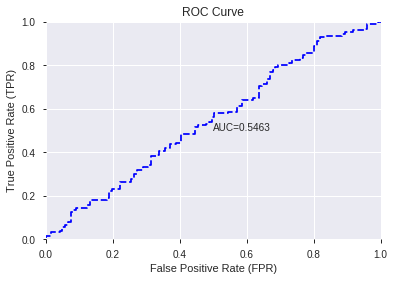

This function is available for GLM models only


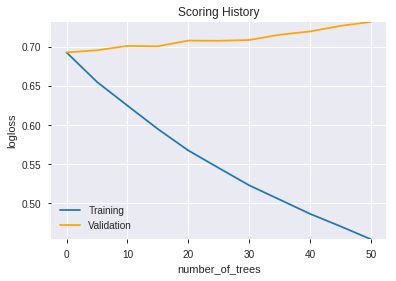

--2019-07-25 00:25:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(Shared

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190725_002510',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190725_002510',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_b977',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_002610_model_5  0.5  17.618971                   0.5  0.714228  0.510121
1  DeepLearning_grid_1_AutoML_20190725_002610_model_3  0.5  16.919805                   0.5  0.699913  0.489879
2  DeepLearning_grid_1_AutoML_20190725_002610_model_6  0.5  17.618971                   0.5  0.714228  0.510121
3  DeepLearning_grid_1_AutoML_20190725_002610_model_7  0.5  16.919805                   0.5  0.699913  0.489879
4               DeepLearning_1_AutoML_20190725_002610  0.5   0.693566                   0.5  0.500209  0.250209
5  DeepLearning_grid_1_AutoML_20190725_002610_model_8  0.5  16.919805                   0.5  0.699913  0.489879
6  DeepLearning_grid_1_AutoML_20190725_002610_model_2  0.5  16.919805                   0.5  0.699913  0.489879
7  DeepLearning_grid_1_AutoML_20190725_002610_model_1  0.5  16.919805                   0.5  0.699913  0.489879
8  DeepLearning_grid_1_AutoML_20190725_002610_model_4  0.5  16.919805                   0.5  0.699913  0.489879

variable  relative_importance  scaled_importance  percentage
0       CDLUNIQUE3RIVER             1.000000           1.000000    0.022394
1       CDLLADDERBOTTOM             0.990558           0.990558    0.022183
2           CDLPIERCING             0.984601           0.984601    0.022049
3   CDLXSIDEGAP3METHODS             0.978938           0.978938    0.021922
4        CDLMORNINGSTAR             0.947125           0.947125    0.021210
5             CDLTAKURI             0.944443           0.944443    0.021150
6      is_quarter_start             0.937581           0.937581    0.020996
7     CDL3WHITESOLDIERS             0.936329           0.936329    0.020968
8    CDLMORNINGDOJISTAR             0.932793           0.932793    0.020889
9      CDLDRAGONFLYDOJI             0.932680           0.932680    0.020886
10      CDLSHOOTINGSTAR             0.932010           0.932010    0.020871
11      CDLHOMINGPIGEON             0.930964           0.930964    0.020848
12       CDLEVENINGSTAR             0.930234           0.930234    0.020832
13   CDLEVENINGDOJISTAR             0.928508           0.928508    0.020793
14      CDLADVANCEBLOCK             0.927367           0.927367    0.020767
15            CDLINNECK             0.923585           0.923585    0.020683
16         CDLTHRUSTING             0.918715           0.918715    0.020574
17        CDLHIKKAKEMOD             0.917600           0.917600    0.020549
18    CDLSTALLEDPATTERN             0.916434           0.916434    0.020523
19                 TANH             0.915418           0.915418    0.020500
20       CDLRICKSHAWMAN             0.912528           0.912528    0.020435
21            CDL2CROWS             0.908812           0.908812    0.020352
22   CDLUPSIDEGAP2CROWS             0.905048           0.905048    0.020268
23        days_in_month             0.897848           0.897848    0.020106
24            CORREL_14             0.897603           0.897603    0.020101
25         is_month_end             0.896808           0.896808    0.020083
26         HT_TRENDMODE             0.887551           0.887551    0.019876
27    CDLINVERTEDHAMMER             0.887210           0.887210    0.019868
28       CDLMATCHINGLOW             0.886107           0.886107    0.019844
29            CDLHAMMER             0.885567           0.885567    0.019831
30       is_quarter_end             0.880071           0.880071    0.019708
31  CDLGAPSIDESIDEWHITE             0.875197           0.875197    0.019599
32                  TAN             0.867936           0.867936    0.019437
33            aroonup_8             0.866638           0.866638    0.019408
34                 SINH             0.866092           0.866092    0.019395
35            dayofweek             0.861044           0.861044    0.019282
36              weekday             0.859365           0.859365    0.019245
37    CDLGRAVESTONEDOJI             0.856834           0.856834    0.019188
38            CDLONNECK             0.852761           0.852761    0.019097
39           CDL3INSIDE             0.847955           0.847955    0.018989
40               VAR_12             0.846371           0.846371    0.018954
41    CDLLONGLEGGEDDOJI             0.839422           0.839422    0.018798
42                  EXP             0.835393           0.835393    0.018708
43     CDLSTICKSANDWICH             0.834884           0.834884    0.018696
44              CDLDOJI             0.828141           0.828141    0.018545
45                VAR_8             0.811842           0.811842    0.018180
46    CDLDARKCLOUDCOVER             0.809162           0.809162    0.018120
47        CDLHANGINGMAN             0.809030           0.809030    0.018117
48       is_month_start             0.808717           0.808717    0.018110
49                 COSH             0.806918           0.806918    0.018070

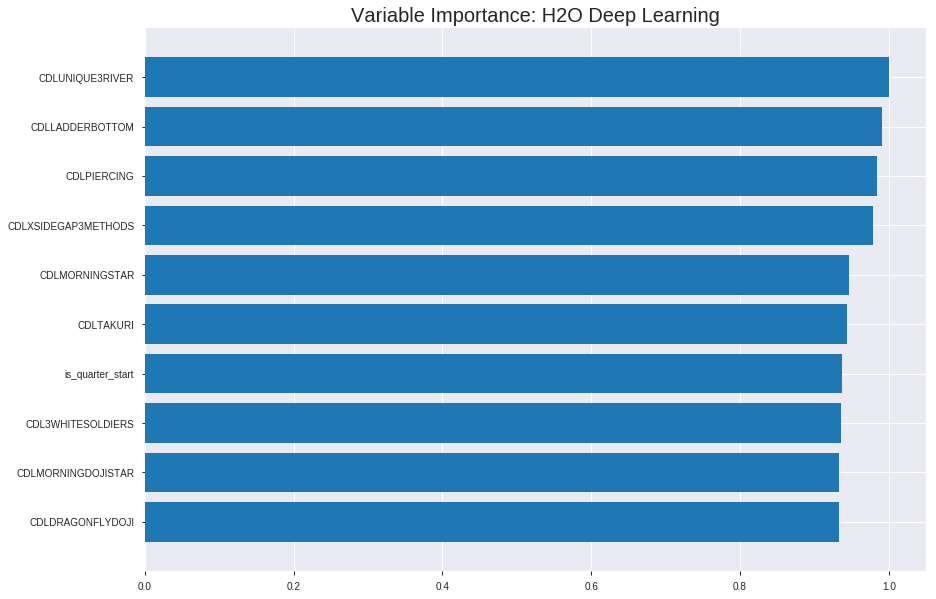

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_002610_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2542855629441519
RMSE: 0.5042673526455504
LogLoss: 0.7025850600933502
Mean Per-Class Error: 0.4509937204635204
AUC: 0.5587479230055459
pr_auc: 0.578588421069491
Gini: 0.11749584601109175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726667354310864: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   798   0.9815   (798.0/813.0)
1      3    909   0.0033   (3.0/912.0)
Total  18   1707  0.4643   (801.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.472667     0.694158   386
max f2                       0.466046     0.849496   390
max f0point5                 0.551097     0.593509   309
max accuracy                 0.551821     0.554203   308
max precision                0.827763     1          0
max recall                   0.432551     1          397
max specificity              0.827763     1          0
max absolute_mcc             0.615249     0.0980616  200
max min_per_class_accuracy   0.619782     0.539975   192
max mean_per_class_accuracy  0.615249     0.549006   200

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 61.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.757349           1.15588   1.15588            0.611111         0.775172  0.611111                    0.775172            0.0120614       0.0120614                  15.5885    15.5885
    2        0.0202899                   0.734244           1.22388   1.18891            0.647059         0.744087  0.628571                    0.760074            0.0120614       0.0241228                  22.3878    18.891
    3        0.0301449                   0.721037           1.33514   1.23672            0.705882         0.726572  0.653846                    0.749121            0.0131579       0.0372807                  33.5139    23.6716
    4        0.04                        0.712383           1.22388   1.23355            0.647059         0.716355  0.652174                    0.741048            0.0120614       0.0493421                  22.3878    23.3553
    5        0.0504348                   0.707485           1.0508    1.19574            0.555556         0.709683  0.632184                    0.734559            0.0109649       0.060307                   5.08041    19.5743
    6        0.10029                     0.690548           1.09968   1.14799            0.581395         0.698584  0.606936                    0.716676            0.0548246       0.115132                   9.96787    14.7988
    7        0.150145                    0.679529           1.12167   1.13925            0.593023         0.685049  0.602317                    0.706174            0.0559211       0.171053                   12.1672    13.925
    8        0.2                         0.668805           1.14367   1.14035            0.604651         0.674893  0.602899                    0.698377            0.0570175       0.22807                    14.3666    14.0351
    9        0.30029                     0.652117           1.04959   1.11004            0.554913         0.660325  0.586873                    0.685668            0.105263        0.333333                   4.95893    11.0039
    10       0.4                         0.635292           1.06669   1.09923            0.563953         0.643254  0.581159                    0.675096            0.10636         0.439693                   6.66883    9.92325
    11       0.50029                     0.619895           0.994923  1.07832            0.526012         0.627824  0.570104                    0.665619            0.0997807       0.539474                   -0.507682  7.83223
    12       0.6                         0.60696            0.989711  1.0636             0.523256         0.612946  0.562319                    0.656866            0.0986842       0.638158                   -1.02892   6.35965
    13       0.69971                     0.591009           0.912733  1.0421             0.482558         0.599259  0.550953                    0.648657            0.0910088       0.729167                   -8.72667   4.20982
    14       0.8                         0.56621            0.962124  1.03207            0.508671         0.579032  0.545652                    0.639929            0.0964912       0.825658                   -3.78765   3.20724
    15       0.89971                     0.531809           0.901737  1.01763            0.476744         0.549513  0.538015                    0.629908            0.0899123       0.91557                    -9.82635   1.76279
    16       1                           0.399083           0.841858  1                  0.445087         0.505485  0.528696                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3845913652594957
RMSE: 0.6201543076198824
LogLoss: 8.442474723363224
Mean Per-Class Error: 0.48084008231545405
AUC: 0.5042651354221986
pr_auc: 0.5414342841085282
Gini: 0.00853027084439728
Confusion Matrix (Act/Pred) for max f1 @ threshold = 5.7834713466923016e-55: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       5.78347e-55  0.706037   286
max f2                       5.78347e-55  0.857234   286
max f0point5                 5.78347e-55  0.600178   286
max accuracy                 5.78347e-55  0.545639   286
max precision                0.730957     1          0
max recall                   5.78347e-55  1          286
max specificity              0.730957     1          0
max absolute_mcc             0.634553     0.0621362  102
max min_per_class_accuracy   0.516877     0.509294   244
max mean_per_class_accuracy  0.53104      0.51916    236

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 33.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.715466           1.09963   1.09963            0.6              0.727878      0.6                         0.727878            0.0111524       0.0111524                  9.96283    9.96283
    2        0.020284                    0.705692           1.46617   1.2829             0.8              0.709562      0.7                         0.71872             0.0148699       0.0260223                  46.6171    28.29
    3        0.030426                    0.700298           0.366543  0.977447           0.2              0.703705      0.533333                    0.713715            0.00371747      0.0297398                  -63.3457   -2.25527
    4        0.040568                    0.694962           0.733086  0.916357           0.4              0.698177      0.5                         0.70983             0.00743494      0.0371747                  -26.6914   -8.36431
    5        0.0507099                   0.69223            1.09963   0.953011           0.6              0.693567      0.52                        0.706578            0.0111524       0.0483271                  9.96283    -4.69888
    6        0.10142                     0.667892           1.02632   0.989665           0.56             0.678556      0.54                        0.692567            0.0520446       0.100372                   2.63197    -1.03346
    7        0.150101                    0.650209           0.99272   0.990656           0.541667         0.658469      0.540541                    0.681508            0.0483271       0.148699                   -0.728005  -0.934392
    8        0.200811                    0.637236           0.659777  0.907101           0.36             0.643887      0.494949                    0.672008            0.0334572       0.182156                   -34.0223   -9.28993
    9        0.300203                    0.607324           1.12207   0.978273           0.612245         0.621041      0.533784                    0.655134            0.111524        0.29368                    12.207     -2.17271
    10       0.399594                    0.5787             1.19687   1.03265            0.653061         0.594011      0.563452                    0.639931            0.118959        0.412639                   19.6874    3.26458
    11       0.501014                    0.510952           0.953011  1.01653            0.52             0.54785       0.554656                    0.621291            0.0966543       0.509294                   -4.69888   1.65254
    12       0.600406                    1.83184e-163       1.08467   1.02781            0.591837         0.220368      0.560811                    0.554922            0.107807        0.6171                     8.46673    2.78057
    13       1                           0                  0.958221  1                  0.522843         3.05615e-188  0.545639                    0.333178            0.3829          1                          -4.17791   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:28:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:28:59  57.878 sec        1388 obs/sec      1.67304   1             2886       0.504267         0.702585            -0.0205035     0.558748        0.578588           1.15588          0.464348                         0.620154           8.44247               -0.55129         0.504265          0.541434             1.09963            0.454361
    2019-07-25 00:29:05  1 min  3.967 sec  2281 obs/sec      9.98667   6             17227      0.500893         0.693628            -0.006893      0.613373        0.638297           1.57621          0.449275                         0.631139           8.98715               -0.606731        0.508315          0.547752             0.733086           0.454361
    2019-07-25 00:29:12  1 min 10.251 sec  2599 obs/sec      19.9339   12            34386      0.484376         0.658804            0.0584187      0.652385        0.678938           1.89145          0.408696                         0.627028           8.99553               -0.585871        0.509153          0.550382             0.733086           0.454361
    2019-07-25 00:29:18  1 min 16.313 sec  2764 obs/sec      29.9548   18            51672      0.478671         0.643636            0.0804677      0.670846        0.704392           1.89145          0.404638                         0.633981           9.03263               -0.621235        0.500813          0.537161             0.366543           0.454361
    2019-07-25 00:29:24  1 min 22.964 sec  2904 obs/sec      41.5235   25            71628      0.466765         0.617648            0.125642       0.689503        0.73565            1.89145          0.391304                         0.632419           9.03408               -0.613255        0.512505          0.548452             0.733086           0.454361
    2019-07-25 00:29:32  1 min 30.356 sec  3008 obs/sec      54.8499   33            94616      0.457917         0.597234            0.158475       0.742245        0.773813           1.89145          0.347826                         0.637968           9.1129                -0.641689        0.507941          0.546779             1.09963            0.454361
    2019-07-25 00:29:32  1 min 30.983 sec  3006 obs/sec      54.8499   33            94616      0.504267         0.702585            -0.0205035     0.558748        0.578588           1.15588          0.464348                         0.620154           8.44247               -0.55129         0.504265          0.541434             1.09963            0.454361

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLUNIQUE3RIVER      1.0                    1.0                  0.022394039166607507
CDLLADDERBOTTOM      0.9905581474304199     0.9905581474304199   0.022182597950358995
CDLPIERCING          0.9846013784408569     0.9846013784408569   0.02204920183230029
CDLXSIDEGAP3METHODS  0.9789384007453918     0.9789384007453918   0.02192238488798842
CDLMORNINGSTAR       0.947124719619751      0.947124719619751    0.021209948066826856
---                  ---                    ---                  ---
VAR_8                0.8118423223495483     0.8118423223495483   0.018180428763805382
CDLDARKCLOUDCOVER    0.8091623783111572     0.8091623783111572   0.018120413992045333
CDLHANGINGMAN        0.8090304732322693     0.8090304732322693   0.018117460104542443
is_month_start       0.8087173104286194     0.8087173104286194   0.01811044712445198
COSH                 0.806918203830719      0.806918203830719    0.0180701578608337


See the whole table with table.as_data_frame()


Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

deeplearning prediction progress: |███████████████████████████████████████| 100%


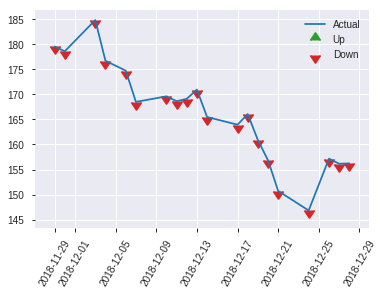


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Could not find exact threshold 0.0; using closest threshold found 0.0.
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

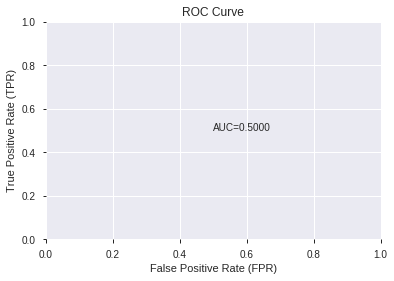

This function is available for GLM models only


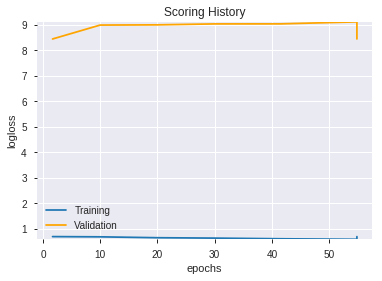

--2019-07-25 00:32:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_002610_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_002610_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLXSIDEGAP3METHODS',
 'CDLMORNINGSTAR',
 'CDLTAKURI',
 'is_quarter_start',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLINNECK',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDLSTALLEDPATTERN',
 'TANH',
 'CDLRICKSHAWMAN',
 'CDL2CROWS',
 'CDLUPSIDEGAP2CROWS',
 'days_in_month',
 'CORREL_14',
 'is_month_end',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'is_quarter_end',
 'CDLGAPSIDESIDEWHITE',
 'TAN',
 'aroonup_8',
 'SINH',
 'dayofweek',
 'weekday',
 'CDLGRAVESTONEDOJI',
 'CDLONNECK',
 'CDL3INSIDE',
 'VAR_12',
 'CDLLONGLEGGEDDOJI',
 'EXP',
 'CDLSTICKSANDWICH',
 'CDLDOJI',
 'VAR_8',
 'CDLDARKCLOUDCOVER',
 'CDLHANGINGMAN',
 'is_month_start',
 'COSH']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_003239_model_1  0.5  17.618971                   0.5  0.714228  0.510121

variable  relative_importance  scaled_importance  percentage
0               weekday             0.008707           1.000000    0.056246
1             dayofweek             0.008689           0.997839    0.056124
2             aroonup_8             0.007908           0.908219    0.051084
3                   EXP             0.007562           0.868441    0.048846
4                  SINH             0.007555           0.867614    0.048800
5                  COSH             0.007553           0.867434    0.048790
6     CDLSTALLEDPATTERN             0.005277           0.606056    0.034088
7             CDLINNECK             0.004823           0.553922    0.031156
8   CDLXSIDEGAP3METHODS             0.004659           0.535036    0.030094
9       CDLLADDERBOTTOM             0.004657           0.534865    0.030084
10                 TANH             0.004258           0.488949    0.027501
11    CDLINVERTEDHAMMER             0.003961           0.454847    0.025583
12         CDLTHRUSTING             0.003808           0.437306    0.024597
13     is_quarter_start             0.003604           0.413918    0.023281
14    CDLGRAVESTONEDOJI             0.003572           0.410278    0.023076
15           CDL3INSIDE             0.003496           0.401443    0.022580
16        CDLHIKKAKEMOD             0.003392           0.389518    0.021909
17       is_month_start             0.003377           0.387857    0.021815
18      CDLSHOOTINGSTAR             0.003166           0.363558    0.020449
19       CDLMORNINGSTAR             0.003141           0.360757    0.020291
20   CDLMORNINGDOJISTAR             0.003136           0.360122    0.020255
21            CDL2CROWS             0.003083           0.354034    0.019913
22               VAR_12             0.003064           0.351907    0.019793
23    CDL3WHITESOLDIERS             0.003060           0.351437    0.019767
24            CORREL_14             0.002741           0.314792    0.017706
25  CDLGAPSIDESIDEWHITE             0.002715           0.311818    0.017539
26    CDLLONGLEGGEDDOJI             0.002712           0.311483    0.017520
27              CDLDOJI             0.002710           0.311220    0.017505
28   CDLEVENINGDOJISTAR             0.002700           0.310105    0.017442
29        CDLHANGINGMAN             0.002611           0.299856    0.016866
30                  TAN             0.002548           0.292580    0.016456
31       CDLRICKSHAWMAN             0.002243           0.257575    0.014488
32        days_in_month             0.002232           0.256374    0.014420
33       CDLMATCHINGLOW             0.002224           0.255421    0.014366
34   CDLUPSIDEGAP2CROWS             0.002201           0.252785    0.014218
35            CDLHAMMER             0.002095           0.240579    0.013532
36    CDLDARKCLOUDCOVER             0.001704           0.195653    0.011005
37      CDLHOMINGPIGEON             0.001230           0.141206    0.007942
38       CDLEVENINGSTAR             0.001186           0.136153    0.007658
39          CDLPIERCING             0.001093           0.125514    0.007060
40      CDLADVANCEBLOCK             0.000730           0.083836    0.004715
41                VAR_8             0.000725           0.083268    0.004683
42         HT_TRENDMODE             0.000554           0.063618    0.003578
43       is_quarter_end             0.000518           0.059449    0.003344
44            CDLTAKURI             0.000406           0.046574    0.002620
45            CDLONNECK             0.000351           0.040332    0.002269
46     CDLDRAGONFLYDOJI             0.000313           0.035947    0.002022
47      CDLUNIQUE3RIVER             0.000265           0.030412    0.001711
48         is_month_end             0.000255           0.029266    0.001646
49     CDLSTICKSANDWICH             0.000243           0.027851    0.001567

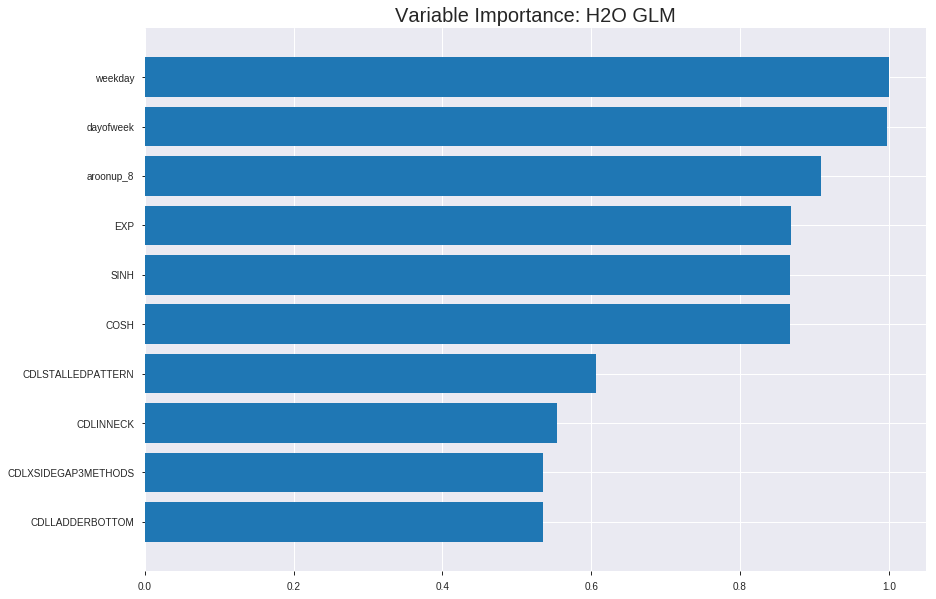

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_003239_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24783075562699075
RMSE: 0.49782602947916527
LogLoss: 0.6887963646697028
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2385.6729106355115
Residual deviance: 2376.3474581104747
AIC: 2478.3474581104747
AUC: 0.5803729418873136
pr_auc: 0.6065952654975323
Gini: 0.16074588377462717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5122306332433035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      30   783   0.9631   (783.0/813.0)
1      5    907   0.0055   (5.0/912.0)
Total  35   1690  0.4568   (788.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512231     0.697156  370
max f2                       0.504671     0.851064  385
max f0point5                 0.521002     0.596526  310
max accuracy                 0.526564     0.55942   233
max precision                0.567352     1         0
max recall                   0.504671     1         385
max specificity              0.567352     1         0
max absolute_mcc             0.532128     0.130493  145
max min_per_class_accuracy   0.529093     0.548585  192
max mean_per_class_accuracy  0.532128     0.561371  145

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.549159           1.57621   1.57621            0.833333         0.555905  0.833333                    0.555905            0.0164474       0.0164474                  57.6206   57.6206
    2        0.0202899                   0.542353           1.22388   1.40508            0.647059         0.545208  0.742857                    0.550709            0.0120614       0.0285088                  22.3878   40.5075
    3        0.0301449                   0.540405           1.33514   1.38221            0.705882         0.541313  0.730769                    0.547637            0.0131579       0.0416667                  33.5139   38.2212
    4        0.04                        0.539264           1.4464    1.39803            0.764706         0.539746  0.73913                     0.545693            0.0142544       0.0559211                  44.6401   39.8026
    5        0.0504348                   0.538627           0.945724  1.30445            0.5              0.538986  0.689655                    0.544305            0.00986842      0.0657895                  -5.42763  30.4446
    6        0.10029                     0.536879           1.27563   1.29012            0.674419         0.537835  0.682081                    0.541089            0.0635965       0.129386                   27.5627   29.012
    7        0.150145                    0.535533           1.18765   1.2561             0.627907         0.536189  0.664093                    0.539462            0.0592105       0.188596                   18.7653   25.6096
    8        0.2                         0.53442            1.12167   1.22259            0.593023         0.534988  0.646377                    0.538346            0.0559211       0.244518                   12.1672   22.2588
    9        0.30029                     0.532626           1.08239   1.17576            0.572254         0.53345   0.621622                    0.536711            0.108553        0.35307                    8.2389    17.5765
    10       0.4                         0.530906           0.989711  1.12939            0.523256         0.531731  0.597101                    0.53547             0.0986842       0.451754                   -1.02892  12.9386
    11       0.50029                     0.5291             0.940257  1.09147            0.49711          0.530006  0.577057                    0.534374            0.0942982       0.546053                   -5.97429  9.14725
    12       0.6                         0.527584           0.989711  1.07456            0.523256         0.528378  0.568116                    0.533378            0.0986842       0.644737                   -1.02892  7.45614
    13       0.69971                     0.525808           0.989711  1.06247            0.523256         0.526605  0.561723                    0.532413            0.0986842       0.743421                   -1.02892  6.247
    14       0.8                         0.523729           0.841858  1.03481            0.445087         0.524869  0.547101                    0.531467            0.0844298       0.827851                   -15.8142  3.48136
    15       0.89971                     0.520615           1.0227    1.03347            0.540698         0.5222    0.546392                    0.53044             0.101974        0.929825                   2.27012   3.34712
    16       1                           0.380332           0.699726  1                  0.369942         0.513046  0.528696                    0.528696            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38292114221810053
RMSE: 0.6188062234804208
LogLoss: 8.660796714698645
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 679.8987251155328
Residual deviance: 157117.5761601873
AIC: 157219.5761601873
AUC: 0.5010621348911312
pr_auc: 0.5432858726163489
Gini: 0.0021242697822623224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.288118859815988e-78: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       8.28812e-78  0.706037   278
max f2                       8.28812e-78  0.857234   278
max f0point5                 8.28812e-78  0.600178   278
max accuracy                 8.28812e-78  0.545639   278
max precision                0.538319     0.666667   8
max recall                   8.28812e-78  1          278
max specificity              0.561404     0.995536   0
max absolute_mcc             0.529784     0.0608548  134
max min_per_class_accuracy   0.519849     0.5        246
max mean_per_class_accuracy  1.73051e-14  0.515783   276

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 28.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.541677           0.733086  0.733086           0.4              0.549462   0.4                         0.549462            0.00743494      0.00743494                 -26.6914   -26.6914
    2        0.020284                    0.538094           1.46617   1.09963            0.8              0.539608   0.6                         0.544535            0.0148699       0.0223048                  46.6171    9.96283
    3        0.030426                    0.537684           0.733086  0.977447           0.4              0.537918   0.533333                    0.542329            0.00743494      0.0297398                  -26.6914   -2.25527
    4        0.040568                    0.537233           0.733086  0.916357           0.4              0.537485   0.5                         0.541118            0.00743494      0.0371747                  -26.6914   -8.36431
    5        0.0507099                   0.536596           1.83271   1.09963            1                0.536931   0.6                         0.540281            0.0185874       0.0557621                  83.2714    9.96283
    6        0.10142                     0.534935           0.879703  0.989665           0.48             0.535772   0.54                        0.538026            0.0446097       0.100372                   -12.0297   -1.03346
    7        0.150101                    0.533337           0.99272   0.990656           0.541667         0.534259   0.540541                    0.536805            0.0483271       0.148699                   -0.728005  -0.934392
    8        0.200811                    0.531924           0.953011  0.98115            0.52             0.532667   0.535354                    0.53576             0.0483271       0.197026                   -4.69888   -1.88502
    9        0.300203                    0.528484           0.935058  0.96589            0.510204         0.530261   0.527027                    0.533939            0.0929368       0.289963                   -6.4942    -3.41103
    10       0.399594                    0.525433           1.04727   0.98613            0.571429         0.527178   0.538071                    0.532257            0.104089        0.394052                   4.7265     -1.38698
    11       0.501014                    0.519849           1.06297   1.00169            0.58             0.523177   0.546559                    0.530419            0.107807        0.501859                   6.2974     0.168566
    12       1                           0                  0.998307  1                  0.544715         0.0426712  0.545639                    0.28704             0.498141        1                          -0.169251  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 00:32:39  0.000 sec   2            3.5       51            1.37759           318.697
    2019-07-25 00:32:39  0.012 sec   4            2.2       51            1.3751            322.212
    2019-07-25 00:32:39  0.024 sec   6            1.3       51            1.37189           325.576
    2019-07-25 00:32:39  0.038 sec   8            0.83      51            1.3681            328.6
    2019-07-25 00:32:39  0.051 sec   10           0.52      51            1.36401           330.233

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

glm prediction progress: |████████████████████████████████████████████████| 100%


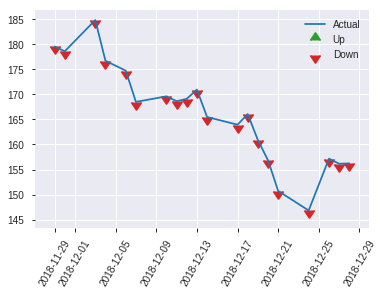


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 342.65506474663505
Residual deviance: 178515.89747013059
AIC: 178617.89747013059
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

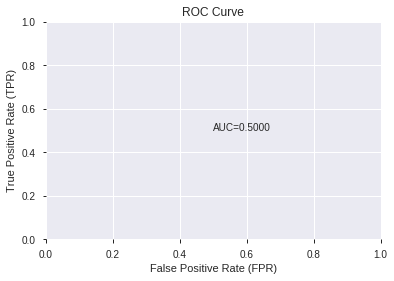

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


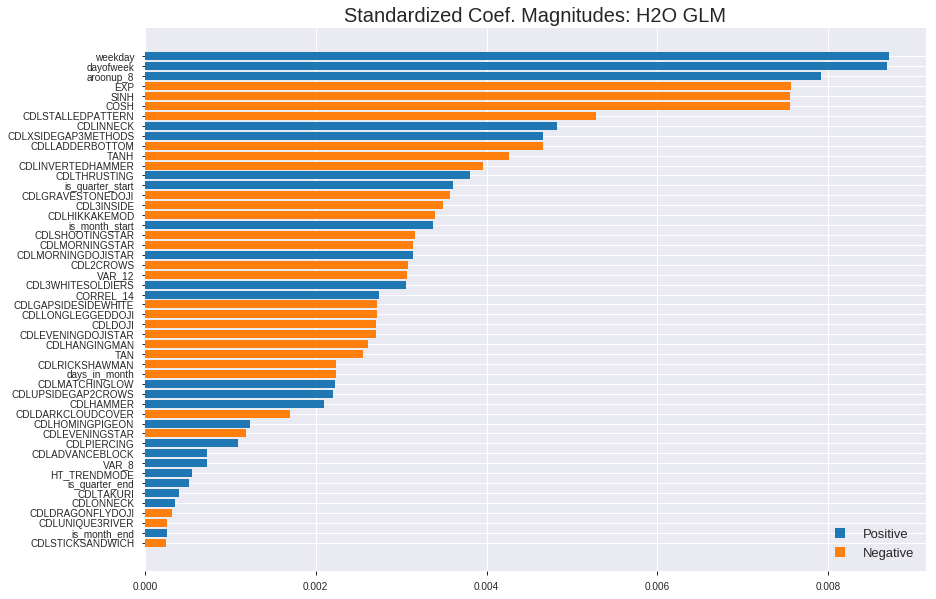

'log_likelihood'
--2019-07-25 00:32:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_003239_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_003239_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['weekday',
 'dayofweek',
 'aroonup_8',
 'EXP',
 'SINH',
 'COSH',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'TANH',
 'CDLINVERTEDHAMMER',
 'CDLTHRUSTING',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CDLHIKKAKEMOD',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDL2CROWS',
 'VAR_12',
 'CDL3WHITESOLDIERS',
 'CORREL_14',
 'CDLGAPSIDESIDEWHITE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLHANGINGMAN',
 'TAN',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLUPSIDEGAP2CROWS',
 'CDLHAMMER',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'VAR_8',
 'HT_TRENDMODE',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLUNIQUE3RIVER',
 'is_month_end',
 'CDLSTICKSANDWICH']

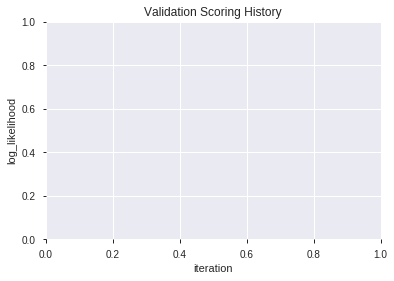

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_003258_model_5  0.481241  0.850424              0.500000  0.560012  0.313613
1  XGBoost_grid_1_AutoML_20190725_003258_model_6  0.480454  0.756893              0.500000  0.528426  0.279234
2  XGBoost_grid_1_AutoML_20190725_003258_model_3  0.479273  0.744590              0.491736  0.523455  0.274005
3               XGBoost_3_AutoML_20190725_003258  0.478289  0.743973              0.500000  0.523066  0.273598
4  XGBoost_grid_1_AutoML_20190725_003258_model_2  0.476453  0.709964              0.500000  0.508127  0.258193
5  XGBoost_grid_1_AutoML_20190725_003258_model_1  0.473140  0.726247              0.500000  0.515478  0.265718
6               XGBoost_2_AutoML_20190725_003258  0.457431  0.723676              0.500000  0.514457  0.264666
7  XGBoost_grid_1_AutoML_20190725_003258_model_7  0.457104  0.734626              0.500000  0.519103  0.269468
8  XGBoost_grid_1_AutoML_20190725_003258_model_4  0.454545  0.715190              0.500000  0.510635  0.260748
9               XGBoost_1_AutoML_20190725_003258  0.451331  0.728651              0.500000  0.516564  0.266838

variable  relative_importance  scaled_importance  percentage
0             CORREL_14          4111.833496           1.000000    0.203442
1                   TAN          3767.242920           0.916195    0.186392
2                VAR_12          3313.143799           0.805758    0.163925
3                 VAR_8          3193.685059           0.776706    0.158014
4             aroonup_8          1309.017822           0.318354    0.064766
5             dayofweek          1026.709839           0.249696    0.050799
6         days_in_month           609.298401           0.148182    0.030146
7               weekday           530.263977           0.128960    0.026236
8          HT_TRENDMODE           367.681427           0.089420    0.018192
9               CDLDOJI           274.280609           0.066705    0.013571
10       is_month_start           167.719284           0.040789    0.008298
11         is_month_end           133.671707           0.032509    0.006614
12       CDLRICKSHAWMAN           131.009857           0.031862    0.006482
13    CDLLONGLEGGEDDOJI           108.004211           0.026267    0.005344
14    CDLDARKCLOUDCOVER           107.116852           0.026051    0.005300
15                 TANH           100.328514           0.024400    0.004964
16        CDLHANGINGMAN            88.039635           0.021411    0.004356
17     CDLDRAGONFLYDOJI            70.765129           0.017210    0.003501
18      CDLHOMINGPIGEON            62.661320           0.015239    0.003100
19            CDLHAMMER            62.568039           0.015217    0.003096
20                 COSH            58.614788           0.014255    0.002900
21           CDL3INSIDE            55.302040           0.013449    0.002736
22     is_quarter_start            53.318123           0.012967    0.002638
23         CDLTHRUSTING            49.765625           0.012103    0.002462
24                  EXP            47.897873           0.011649    0.002370
25    CDLGRAVESTONEDOJI            39.740471           0.009665    0.001966
26      CDLADVANCEBLOCK            39.262951           0.009549    0.001943
27    CDLINVERTEDHAMMER            35.973099           0.008749    0.001780
28       CDLMORNINGSTAR            34.803898           0.008464    0.001722
29       CDLEVENINGSTAR            33.834908           0.008229    0.001674
30                 SINH            33.476204           0.008141    0.001656
31      CDLSHOOTINGSTAR            31.749939           0.007722    0.001571
32       CDLMATCHINGLOW            28.171188           0.006851    0.001394
33  CDLXSIDEGAP3METHODS            26.157145           0.006361    0.001294
34       is_quarter_end            23.512075           0.005718    0.001163
35            CDLTAKURI            19.262634           0.004685    0.000953
36            CDLONNECK            13.539381           0.003293    0.000670
37      CDLLADDERBOTTOM            10.077319           0.002451    0.000499
38  CDLGAPSIDESIDEWHITE             9.339795           0.002271    0.000462
39   CDLEVENINGDOJISTAR             6.701955           0.001630    0.000332
40          CDLPIERCING             5.504892           0.001339    0.000272
41            CDLINNECK             5.381056           0.001309    0.000266
42      CDLUNIQUE3RIVER             4.835206           0.001176    0.000239
43   CDLUPSIDEGAP2CROWS             2.878862           0.000700    0.000142
44    CDLSTALLEDPATTERN             2.762006           0.000672    0.000137
45        CDLHIKKAKEMOD             2.347239           0.000571    0.000116
46     CDLSTICKSANDWICH             2.126527           0.000517    0.000105

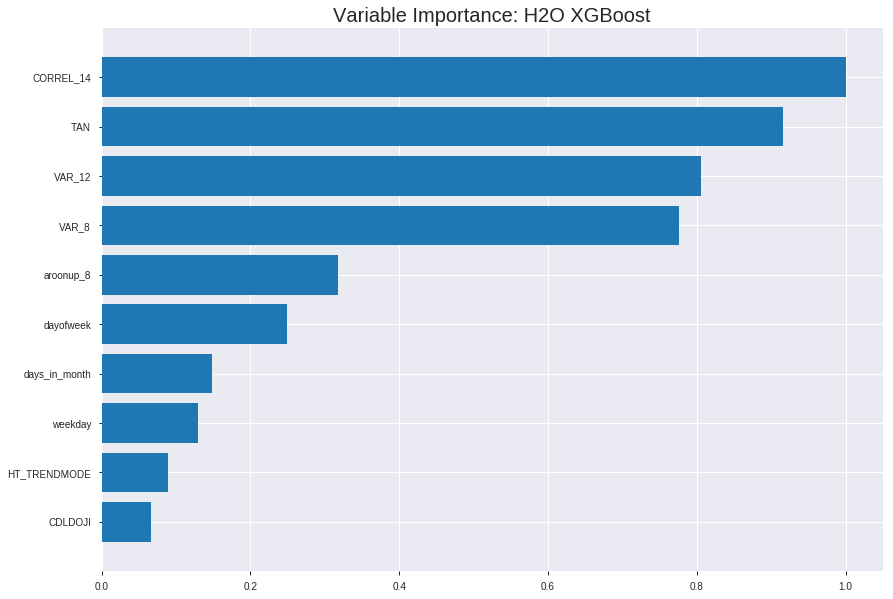

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_003258_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07925872022147193
RMSE: 0.2815292528698784
LogLoss: 0.3212631437938351
Mean Per-Class Error: 0.005749498284456589
AUC: 0.9998799659049222
pr_auc: 0.9977001779016021
Gini: 0.9997599318098445
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5165755152702332: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      808  5    0.0062   (5.0/813.0)
1      5    907  0.0055   (5.0/912.0)
Total  813  912  0.0058   (10.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516576     0.994518  205
max f2                       0.472698     0.997375  213
max f0point5                 0.550434     0.996232  197
max accuracy                 0.527736     0.994203  203
max precision                0.914499     1         0
max recall                   0.472698     1         213
max specificity              0.914499     1         0
max absolute_mcc             0.527736     0.988372  203
max min_per_class_accuracy   0.516576     0.99385   205
max mean_per_class_accuracy  0.527736     0.994251  203

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.881805           1.89145   1.89145            1                0.890781  1                           0.890781            0.0197368       0.0197368                  89.1447   89.1447
    2        0.0202899                   0.870282           1.89145   1.89145            1                0.876319  1                           0.883756            0.0186404       0.0383772                  89.1447   89.1447
    3        0.0301449                   0.857082           1.89145   1.89145            1                0.864116  1                           0.877336            0.0186404       0.0570175                  89.1447   89.1447
    4        0.04                        0.847683           1.89145   1.89145            1                0.853124  1                           0.87137             0.0186404       0.0756579                  89.1447   89.1447
    5        0.0504348                   0.839747           1.89145   1.89145            1                0.843013  1                           0.865503            0.0197368       0.0953947                  89.1447   89.1447
    6        0.10029                     0.813382           1.89145   1.89145            1                0.825657  1                           0.845695            0.0942982       0.189693                   89.1447   89.1447
    7        0.150145                    0.792657           1.89145   1.89145            1                0.803719  1                           0.831757            0.0942982       0.283991                   89.1447   89.1447
    8        0.2                         0.773006           1.89145   1.89145            1                0.783399  1                           0.819703            0.0942982       0.378289                   89.1447   89.1447
    9        0.30029                     0.733236           1.89145   1.89145            1                0.75311   1                           0.797462            0.189693        0.567982                   89.1447   89.1447
    10       0.4                         0.683611           1.89145   1.89145            1                0.709827  1                           0.775617            0.188596        0.756579                   89.1447   89.1447
    11       0.50029                     0.608314           1.89145   1.89145            1                0.650302  1                           0.750496            0.189693        0.946272                   89.1447   89.1447
    12       0.6                         0.358204           0.538843  1.66667            0.284884         0.450951  0.881159                    0.700716            0.0537281       1                          -46.1157  66.6667
    13       0.69971                     0.306309           0         1.42916            0                0.329916  0.755592                    0.647877            0               1                          -100      42.9163
    14       0.8                         0.262053           0         1.25               0                0.28398   0.66087                     0.602258            0               1                          -100      25
    15       0.89971                     0.221171           0         1.11147            0                0.242565  0.587629                    0.562395            0               1                          -100      11.1469
    16       1                           0.0973452          0         1                  0                0.186015  0.528696                    0.524648            0 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.29849182035214644
RMSE: 0.546344049434188
LogLoss: 0.815546419282815
Mean Per-Class Error: 0.4569918348380244
AUC: 0.5205041821561338
pr_auc: 0.5578788037464482
Gini: 0.04100836431226762
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11812207102775574: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    221  0.9866   (221.0/224.0)
1      1    268  0.0037   (1.0/269.0)
Total  4    489  0.4503   (222.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.118122     0.707124   395
max f2                       0.10039      0.857234   399
max f0point5                 0.118122     0.602247   395
max accuracy                 0.118122     0.549696   395
max precision                0.732561     0.692308   24
max recall                   0.10039      1          399
max specificity              0.899378     0.995536   0
max absolute_mcc             0.477116     0.0898567  138
max min_per_class_accuracy   0.384844     0.509294   205
max mean_per_class_accuracy  0.463224     0.543008   147

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 39.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.830648           0.366543  0.366543           0.2              0.875282  0.2                         0.875282            0.00371747      0.00371747                 -63.3457  -63.3457
    2        0.020284                    0.793653           1.09963   0.733086           0.6              0.817235  0.4                         0.846258            0.0111524       0.0148699                  9.96283   -26.6914
    3        0.030426                    0.772805           1.46617   0.977447           0.8              0.783931  0.533333                    0.825483            0.0148699       0.0297398                  46.6171   -2.25527
    4        0.040568                    0.755423           1.46617   1.09963            0.8              0.761528  0.6                         0.809494            0.0148699       0.0446097                  46.6171   9.96283
    5        0.0507099                   0.735141           1.83271   1.24625            1                0.744915  0.68                        0.796578            0.0185874       0.063197                   83.2714   24.6245
    6        0.10142                     0.668572           0.806394  1.02632            0.44             0.704662  0.56                        0.75062             0.0408922       0.104089                   -19.3606  2.63197
    7        0.150101                    0.619417           0.839994  0.96589            0.458333         0.640672  0.527027                    0.714961            0.0408922       0.144981                   -16.0006  -3.41103
    8        0.200811                    0.571681           1.02632   0.98115            0.56             0.599168  0.535354                    0.685721            0.0520446       0.197026                   2.63197   -1.88502
    9        0.300203                    0.501156           1.34648   1.1021             0.734694         0.533134  0.601351                    0.635202            0.133829        0.330855                   34.6484   10.2105
    10       0.399594                    0.43662            0.97246   1.06986            0.530612         0.466411  0.583756                    0.593219            0.0966543       0.427509                   -2.75396  6.98583
    11       0.501014                    0.383144           0.806394  1.01653            0.44             0.408346  0.554656                    0.555795            0.0817844       0.509294                   -19.3606  1.65254
    12       0.600406                    0.304933           1.15947   1.04019            0.632653         0.349152  0.567568                    0.521587            0.115242        0.624535                   15.9472   4.01889
    13       0.699797                    0.266117           0.860253  1.01463            0.469388         0.284858  0.553623                    0.487965            0.0855019       0.710037                   -13.9747  1.46328
    14       0.799189                    0.209527           0.822851  0.990782           0.44898          0.238828  0.540609                    0.456981            0.0817844       0.791822                   -17.7149  -0.92182
    15       0.89858                     0.169627           1.00986   0.992892           0.55102          0.188988  0.541761                    0.427338            0.100372        0.892193                   0.986268  -0.710767
    16       1                           0.10039            1.06297   1                  0.58             0.147741  0.545639                    0.398982 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:33:04  2.419 sec   0                  0.5              0.693147            0.5             0                  1                0.471304                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 00:33:04  2.732 sec   5                  0.460219         0.616263            0.948457        0.952167           1.89145          0.125797                         0.502671           0.698576              0.511683          0.542425             0.733086           0.454361
    2019-07-25 00:33:04  2.960 sec   10                 0.431519         0.563661            0.977597        0.97708            1.89145          0.0794203                        0.506428           0.706476              0.515442          0.543795             0.305452           0.450304
    2019-07-25 00:33:05  3.178 sec   15                 0.406149         0.518942            0.989225        0.989992           1.89145          0.0510145                        0.513249           0.721727              0.520529          0.553619             0                  0.454361
    2019-07-25 00:33:05  3.369 sec   20                 0.385832         0.484233            0.994401        0.993994           1.89145          0.04                             0.518038           0.732986              0.517467          0.552587             0                  0.454361
    2019-07-25 00:33:05  3.613 sec   25                 0.361746         0.444322            0.997124        0.995196           1.89145          0.0226087                        0.525783           0.752547              0.518148          0.553896             0                  0.454361
    2019-07-25 00:33:05  3.848 sec   30                 0.34212          0.41296             0.998808        0.997861           1.89145          0.0150725                        0.529223           0.763011              0.522222          0.557784             0                  0.454361
    2019-07-25 00:33:05  4.072 sec   35                 0.324624         0.385655            0.999398        0.997271           1.89145          0.00985507                       0.538669           0.789648              0.518894          0.55564              0.366543           0.454361
    2019-07-25 00:33:06  4.285 sec   40                 0.310248         0.363562            0.999666        0.997509           1.89145          0.00811594                       0.540558           0.795601              0.519442          0.557247             0.366543           0.448276
    2019-07-25 00:33:06  4.520 sec   45                 0.296005         0.342347            0.999854        0.998774           1.89145          0.00637681                       0.543438           0.805587              0.519143          0.557256             0.366543           0.452333
    2019-07-25 00:33:06  4.849 sec   50                 0.281529         0.321263            0.99988         0.9977             1.89145          0.0057971                        0.546344           0.815546              0.520504          0.557879             0.366543           0.450304

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
CORREL_14           4111.83349609375       1.0                    0.2034415106856163
TAN                 3767.242919921875      0.9161953964091112     0.18639217552867668
VAR_12              3313.143798828125      0.8057582589313547     0.16392467744440678
VAR_8               3193.68505859375       0.7767058324778368     0.15801420791762033
aroonup_8           1309.017822265625      0.3183538009282707     0.06476637819335535
---                 ---                    ---                    ---
CDLUNIQUE3RIVER     4.835205554962158      0.0011759244530586204  0.00023923184718240286
CDLUPSIDEGAP2CROWS  2.8788623809814453     0.0007001407969744811  0.00014243770142911982
CDLSTALLEDPATTERN   2.7620058059692383     0.0006717212184280198  0.0001366559794365792
CDLHIKKAKEMOD       2.347238540649414      0.0005708496083023049  0.00011613450668731324
CDLSTICKSANDWICH    2.1265270709991455     0.000517172466496844   0.00010521434786912421


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5384615384615384)

('F1', 0.675603217158177)

('auc', 0.48124098124098125)

('logloss', 0.8504235615630744)

('mean_per_class_error', 0.46812278630460447)

('rmse', 0.5600117177748808)

('mse', 0.3136131240451728)

xgboost prediction progress: |████████████████████████████████████████████| 100%


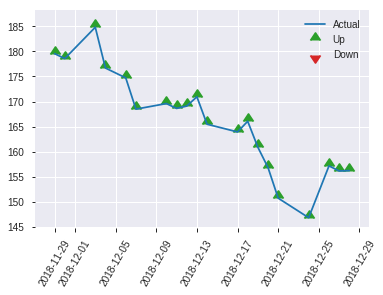


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3136131240451728
RMSE: 0.5600117177748808
LogLoss: 0.8504235615630744
Mean Per-Class Error: 0.46812278630460447
AUC: 0.48124098124098125
pr_auc: 0.4988932923407729
Gini: -0.037518037518037506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09237360954284668: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0923736    0.675603  246
max f2                       0.0923736    0.838881  246
max f0point5                 0.173453     0.574949  211
max accuracy                 0.17894      0.538462  203
max precision                0.565921     0.666667  5
max recall                   0.0923736    1         246
max specificity              0.759628     0.991736  0
max absolute_mcc             0.38827      0.109783  51
max min_per_class_accuracy   0.280566     0.46281   123
max mean_per_class_accuracy  0.17894      0.531877  203

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 29.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.590796           0.653439  0.653439           0.333333         0.666683  0.333333                    0.666683            0.00793651      0.00793651                 -34.6561  -34.6561
    2        0.0202429                   0.567217           1.96032   1.17619            1                0.58548   0.6                         0.634202            0.015873        0.0238095                  96.0317   17.619
    3        0.0323887                   0.54403            1.30688   1.2252             0.666667         0.553535  0.625                       0.603952            0.015873        0.0396825                  30.6878   22.5198
    4        0.0404858                   0.538058           0.980159  1.17619            0.5              0.543346  0.6                         0.591831            0.00793651      0.047619                   -1.98413  17.619
    5        0.0526316                   0.523728           0.653439  1.05556            0.333333         0.531879  0.538462                    0.577996            0.00793651      0.0555556                  -34.6561  5.55556
    6        0.101215                    0.465521           1.14352   1.09778            0.583333         0.494909  0.56                        0.538114            0.0555556       0.111111                   14.3519   9.77778
    7        0.149798                    0.407839           0.490079  0.900686           0.25             0.437644  0.459459                    0.505529            0.0238095       0.134921                   -50.9921  -9.93136
    8        0.202429                    0.38878            0.603175  0.823333           0.307692         0.398313  0.42                        0.477653            0.031746        0.166667                   -39.6825  -17.6667
    9        0.299595                    0.342756           1.2252    0.953668           0.625            0.367021  0.486486                    0.441772            0.119048        0.285714                   22.5198   -4.6332
    10       0.40081                     0.30984            1.01937   0.970258           0.52             0.324049  0.494949                    0.412044            0.103175        0.388889                   1.93651   -2.97419
    11       0.502024                    0.280566           0.784127  0.932732           0.4              0.294551  0.475806                    0.388356            0.0793651       0.468254                   -21.5873  -6.72683
    12       0.59919                     0.242633           1.06184   0.953668           0.541667         0.261721  0.486486                    0.367821            0.103175        0.571429                   6.18386   -4.6332
    13       0.700405                    0.21974            1.17619   0.985824           0.6              0.230457  0.50289                     0.34797             0.119048        0.690476                   17.619    -1.41756
    14       0.797571                    0.188199           1.30688   1.02494            0.666667         0.201075  0.522843                    0.330075            0.126984        0.81746                    30.6878   2.49376
    15       0.898785                    0.159564           0.940952  1.01548            0.48             0.174464  0.518018                    0.312551            0.0952381       0.912698                   -5.90476  1.54798
    16       1                           0.0923736          0.86254   1                  0.44             0.138101  0.510121                    0.294894     

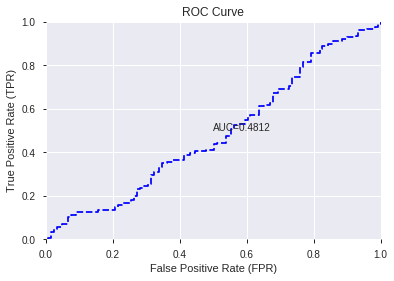

This function is available for GLM models only


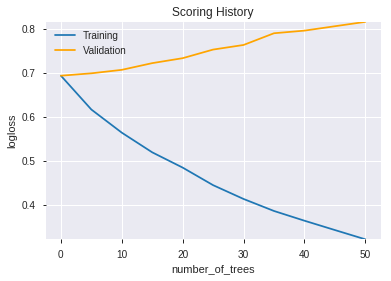

--2019-07-25 00:33:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_003258_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_003258_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_14',
 'TAN',
 'VAR_12',
 'VAR_8',
 'aroonup_8',
 'dayofweek',
 'days_in_month',
 'weekday',
 'HT_TRENDMODE',
 'CDLDOJI',
 'is_month_start',
 'is_month_end',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDARKCLOUDCOVER',
 'TANH',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLHAMMER',
 'COSH',
 'CDL3INSIDE',
 'is_quarter_start',
 'CDLTHRUSTING',
 'EXP',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'SINH',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLINNECK',
 'CDLUNIQUE3RIVER',
 'CDLUPSIDEGAP2CROWS',
 'CDLSTALLEDPATTERN',
 'CDLHIKKAKEMOD',
 'CDLSTICKSANDWICH']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [930] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_003326_model_7  0.5  16.919805                   0.5  0.699913  0.489879
1  DeepLearning_grid_1_AutoML_20190725_003326_model_4  0.5  16.919805                   0.5  0.699913  0.489879
2  DeepLearning_grid_1_AutoML_20190725_003326_model_8  0.5   0.695166                   0.5  0.501003  0.251004
3  DeepLearning_grid_1_AutoML_20190725_003326_model_2  0.5  17.618971                   0.5  0.714228  0.510121
4  DeepLearning_grid_1_AutoML_20190725_003326_model_9  0.5   0.693519                   0.5  0.500185  0.250185
5  DeepLearning_grid_1_AutoML_20190725_003326_model_1  0.5  16.919805                   0.5  0.699913  0.489879
6  DeepLearning_grid_1_AutoML_20190725_003326_model_3  0.5  17.618971                   0.5  0.714228  0.510121
7  DeepLearning_grid_1_AutoML_20190725_003326_model_5  0.5   0.693169                   0.5  0.500011  0.250011
8  DeepLearning_grid_1_AutoML_20190725_003326_model_6  0.5   0.694143                   0.5  0.500496  0.250496
9               DeepLearning_1_AutoML_20190725_003326  0.5  16.919805                   0.5  0.699913  0.489879

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             1.000000           1.000000    0.001736
1                    dayofweek             0.805895           0.805895    0.001399
2                      weekday             0.787632           0.787632    0.001368
3                          BOP             0.701595           0.701595    0.001218
4                  CDLLONGLINE             0.680549           0.680549    0.001182
...                        ...                  ...                ...         ...
1038   BBANDS_lowerband_30_2_3             0.505695           0.505695    0.000878
1039  BBANDS_middleband_20_2_2             0.503248           0.503248    0.000874
1040   BBANDS_upperband_24_2_5             0.502461           0.502461    0.000873
1041  BBANDS_middleband_24_7_4             0.502124           0.502124    0.000872
1042  BBANDS_middleband_12_6_3             0.501745           0.501745    0.000871

[1043 rows x 4 columns]

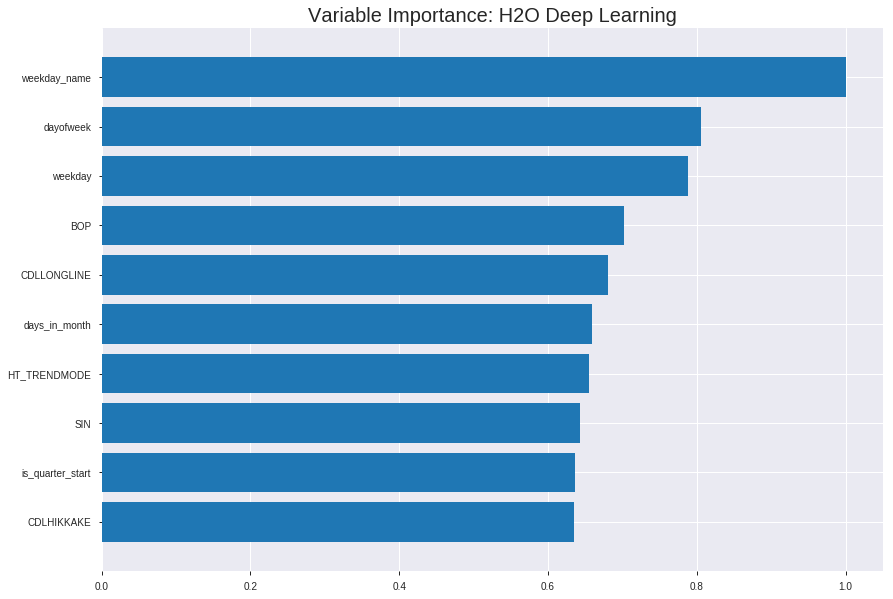

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_003326_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19980393507702185
RMSE: 0.4469943345021521
LogLoss: 0.563439483341777
Mean Per-Class Error: 0.35506489933320384
AUC: 0.7284693899570575
pr_auc: 0.7505375544013363
Gini: 0.4569387799141149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25309373905260424: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      227  586   0.7208   (586.0/813.0)
1      21   891   0.023    (21.0/912.0)
Total  248  1477  0.3519   (607.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.253094     0.745919  305
max f2                       0.088703     0.872664  351
max f0point5                 0.50115      0.664751  156
max accuracy                 0.373278     0.657971  243
max precision                0.999944     1         0
max recall                   0.0175366    1         382
max specificity              0.999944     1         0
max absolute_mcc             0.253094     0.364488  305
max min_per_class_accuracy   0.50115      0.528905  156
max mean_per_class_accuracy  0.50115      0.644935  156

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 47.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.999974           1.89145    1.89145            1                0.999996   1                           0.999996            0.0197368       0.0197368                  89.1447    89.1447
    2        0.0202899                   0.999354           1.89145    1.89145            1                0.999787   1                           0.999894            0.0186404       0.0383772                  89.1447    89.1447
    3        0.0301449                   0.997492           1.89145    1.89145            1                0.998519   1                           0.999445            0.0186404       0.0570175                  89.1447    89.1447
    4        0.04                        0.99506            1.89145    1.89145            1                0.996146   1                           0.998632            0.0186404       0.0756579                  89.1447    89.1447
    5        0.0504348                   0.99211            1.89145    1.89145            1                0.993649   1                           0.997601            0.0197368       0.0953947                  89.1447    89.1447
    6        0.10029                     0.847551           1.86945    1.88051            0.988372         0.948399   0.99422                     0.973142            0.0932018       0.188596                   86.9454    88.0514
    7        0.150145                    0.598051           1.3636     1.70888            0.72093          0.712136   0.903475                    0.886476            0.0679825       0.256579                   36.3602    70.8875
    8        0.624348                    0.501149           1.06365    1.21882            0.562347         0.504438   0.644383                    0.596311            0.504386        0.760965                   6.36501    21.8816
    9        0.69971                     0.446681           0.887525   1.18313            0.469231         0.472579   0.625518                    0.582985            0.066886        0.827851                   -11.2475   18.3134
    10       0.8                         0.344523           0.994923   1.15954            0.526012         0.399047   0.613043                    0.559926            0.0997807       0.927632                   -0.507682  15.9539
    11       0.89971                     0.0689873          0.659807   1.10416            0.348837         0.242226   0.583763                    0.524717            0.0657895       0.993421                   -34.0193   10.4157
    12       1                           1.18341e-08        0.0655993  1                  0.0346821        0.0152175  0.528696                    0.473619            0.00657895      1                          -93.4401   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35141781538072964
RMSE: 0.5928050399420788
LogLoss: 7.546743419616792
Mean Per-Class Error: 0.48250796601168344
AUC: 0.4958427376526819
pr_auc: 0.3033014176538672
Gini: -0.008314524694636227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2615343191891553: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    217  0.9688   (217.0/224.0)
1      1    268  0.0037   (1.0/269.0)
Total  8    485  0.4422   (218.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261534     0.710875  109
max f2                       0.261534     0.858424  109
max f0point5                 0.300397     0.607455  100
max accuracy                 0.300397     0.559838  100
max precision                0.300397     0.554622  100
max recall                   0.0282664    1         117
max specificity              1            0.544643  0
max absolute_mcc             0.261534     0.1085    109
max min_per_class_accuracy   0.51355      0.453532  5
max mean_per_class_accuracy  0.300397     0.517492  100

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 69.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.448276                    1                  0.986846  0.986846           0.538462         1         0.538462                    1                   0.442379        0.442379                   -1.31541  -1.31541
    2        0.774848                    0.501149           1.00173   0.99312            0.546584         0.507437  0.541885                    0.792401            0.327138        0.769517                   0.173174  -0.688024
    3        0.799189                    0.477444           1.06908   0.995433           0.583333         0.488544  0.543147                    0.783147            0.0260223       0.795539                   6.9083    -0.456664
    4        0.89858                     0.375903           1.12207   1.00944            0.612245         0.427611  0.55079                     0.743821            0.111524        0.907063                   12.207    0.944053
    5        1                           0.0282664          0.916357  1                  0.5              0.30835   0.545639                    0.699656            0.0929368       1                          -8.36431  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 00:49:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 00:49:45  7.526 sec         130 obs/sec       0.34087   1             588        0.659154         2.62951             -0.743682      0.546208        0.568876           1.15588          0.471304                         0.721738           9.95948               -1.10113         0.51643           0.560693             1.46617            0.454361
    2019-07-25 00:50:15  37.490 sec        200 obs/sec       3.61159   11            6230       0.608765         1.03358             -0.487278      0.580204        0.609456           1.57621          0.451014                         0.661357           7.80092               -0.764273        0.496996          0.303975             0.975205           0.454361
    2019-07-25 00:50:49  1 min 10.866 sec  244 obs/sec       8.73449   27            15067      0.602613         1.33738             -0.457369      0.619515        0.664439           1.89145          0.44                             0.707502           8.5011                -1.01906         0.501095          0.304869             0.983001           0.450304
    2019-07-25 00:51:18  1 min 40.116 sec  258 obs/sec       13.2168   41            22799      0.495236         0.68538             0.0157251      0.660779        0.703352           1.89145          0.386087                         0.601805           7.58158               -0.460849        0.481977          0.29878              0.986846           0.454361
    2019-07-25 00:51:48  2 min 10.346 sec  270 obs/sec       18.1287   56            31272      0.52899          0.758287            -0.123021      0.704334        0.758072           1.89145          0.361739                         0.631326           7.66178               -0.607687        0.497162          0.303739             0.986846           0.454361
    2019-07-25 00:52:18  2 min 40.069 sec  279 obs/sec       23.0238   71            39716      0.446994         0.563439            0.198143       0.728469        0.750538           1.89145          0.351884                         0.592805           7.54674               -0.417481        0.495843          0.303301             0.986846           0.442191
    2019-07-25 00:52:47  3 min  9.332 sec  285 obs/sec       27.9188   86            48160      0.446787         0.559337            0.198887       0.73586         0.745801           1.89145          0.34087                          0.594534           7.55469               -0.425763        0.495154          0.303237             0.986846           0.454361
    2019-07-25 00:53:16  3 min 38.396 sec  290 obs/sec       32.8023   101           56584      0.484426         0.677463            0.0582223      0.760811        0.751597           1.89145          0.33971                          0.662561           7.82882               -0.770702        0.497112          0.30426              0.986846           0.454361
    2019-07-25 00:53:46

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday_name              1.0                    1.0                  0.001736474891602173
dayofweek                 0.8058946132659912     0.8058946132659912   0.0013994157612138372
weekday                   0.7876318693161011     0.7876318693161011   0.0013677029648930935
BOP                       0.7015952467918396     0.7015952467918396   0.0012183025301214594
CDLLONGLINE               0.6805486083030701     0.6805486083030701   0.0011817555708330833
---                       ---                    ---                  ---
BBANDS_lowerband_30_2_3   0.5056949853897095     0.5056949853897095   0.0008781266449383583
BBANDS_middleband_20_2_2  0.503248393535614      0.503248393535614    0.000873878199613723
BBANDS_upperband_24_2_5   0.502461314201355      0.502461314201355    0.0008725114561120833
BBANDS_middleband_24_7_4  0.5021238923072815     0.5021238923072815   0.0008719255314651478
BBANDS_middleband_12_6_3  0.5017448663711548     0.5017448663711548   0.0008712673624437977


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 16.919805440421822)

('mean_per_class_error', 0.5)

('rmse', 0.6999132392733556)

('mse', 0.4898785425101215)

deeplearning prediction progress: |███████████████████████████████████████| 100%


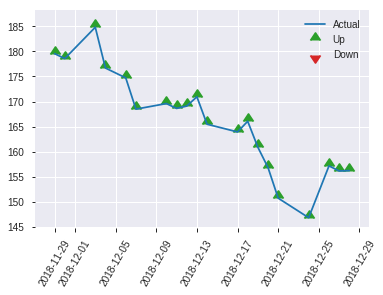


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4898785425101215
RMSE: 0.6999132392733556
LogLoss: 16.919805440421822
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.675603  0
max f2                       1            0.838881  0
max f0point5                 1            0.56553   0
max accuracy                 1            0.510121  0
max precision                1            0.510121  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.510121         1        0.510121                    1                   1               1                          0       0

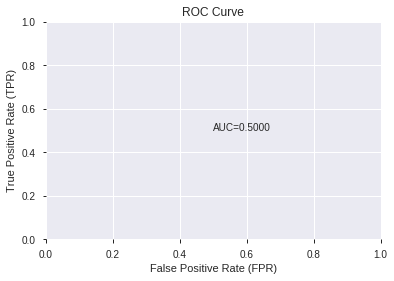

This function is available for GLM models only


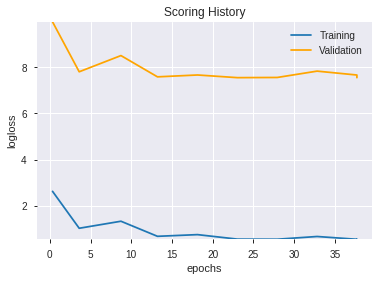

['weekday_name',
 'dayofweek',
 'weekday',
 'BOP',
 'CDLLONGLINE',
 'days_in_month',
 'HT_TRENDMODE',
 'SIN',
 'is_quarter_start',
 'CDLHIKKAKE',
 'CDLHIGHWAVE',
 'CDLDOJI',
 'day',
 'CORREL_12',
 'CORREL_8',
 'CDLTHRUSTING',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'AROONOSC_20',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'SUB',
 'CDLINNECK',
 'is_month_end',
 'aroonup_20',
 'HT_PHASOR_inphase',
 'OBV',
 'aroonup_8',
 'CDLCLOSINGMARUBOZU',
 'CDLSTALLEDPATTERN',
 'aroondown_12',
 'aroonup_14',
 'CDLHANGINGMAN',
 'CDLLADDERBOTTOM',
 'BETA_12',
 'STOCHF_fastk',
 'CDLLONGLEGGEDDOJI',
 'MACDEXT_hist',
 'CDLDARKCLOUDCOVER',
 'CORREL_14',
 'TAN',
 'STOCH_slowk',
 'MFI_24',
 'HT_DCPERIOD',
 'DX_12',
 'ADXR_14',
 'is_month_start',
 'CDLDOJISTAR',
 'CDLBELTHOLD',
 'BBANDS_upperband_8_8_5',
 'COS',
 'BBANDS_upperband_8_6_4',
 'TRANGE',
 'DX_20',
 'MFI_20',
 'ADXR_8',
 'BBANDS_upperband_12_2_4',
 'STOCHF_fastd',
 'STOCHRSI_fastd',
 'AD',
 'CDLMARUBOZU',
 'CDLHOMINGPIGEON',
 'CCI_8',
 'MAVP_14_7',
 'B

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_010216_model_1  0.5  17.618971                   0.5  0.714228  0.510121

variable  relative_importance  scaled_importance    percentage
0                 weekday_name         9.514869e-03           1.000000  1.614819e-02
1                      weekday         7.052485e-03           0.741207  1.196914e-02
2                    dayofweek         7.048235e-03           0.740760  1.196193e-02
3                         SINH         5.363361e-03           0.563682  9.102443e-03
4                          EXP         5.362999e-03           0.563644  9.101828e-03
...                        ...                  ...                ...           ...
1038   BBANDS_middleband_8_1_4         5.184798e-07           0.000054  8.799395e-07
1039   BBANDS_upperband_20_3_2         4.779191e-07           0.000050  8.111017e-07
1040   BBANDS_middleband_8_2_3         4.704846e-07           0.000049  7.984842e-07
1041                  MAVP_8_2         2.906653e-07           0.000031  4.933034e-07
1042  BBANDS_middleband_24_3_5         4.051123e-08           0.000004  6.875374e-08

[1043 rows x 4 columns]

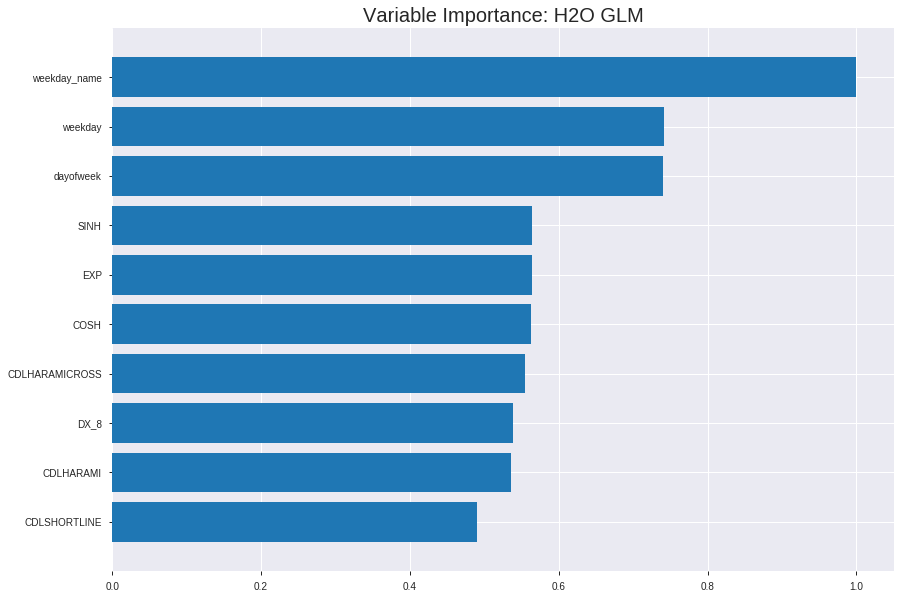

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_010216_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24497428016608094
RMSE: 0.49494876519300557
LogLoss: 0.6830330218077137
Null degrees of freedom: 1724
Residual degrees of freedom: 681
Null deviance: 2385.6729106355115
Residual deviance: 2356.4639252366123
AIC: 4444.463925236612
AUC: 0.5798644828553549
pr_auc: 0.5929111426150313
Gini: 0.1597289657107097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44535919278037306: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   788   0.9692   (788.0/813.0)
1      6    906   0.0066   (6.0/912.0)
Total  31   1694  0.4603   (794.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445359     0.695318  381
max f2                       0.434927     0.850112  392
max f0point5                 0.478892     0.597636  318
max accuracy                 0.524658     0.563478  210
max precision                0.622111     1         0
max recall                   0.434927     1         392
max specificity              0.622111     1         0
max absolute_mcc             0.55677      0.133618  117
max min_per_class_accuracy   0.531057     0.554825  190
max mean_per_class_accuracy  0.524658     0.560133  210

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104348                   0.608131           1.26096   1.26096            0.666667         0.611985  0.666667                    0.611985            0.0131579       0.0131579                  26.0965    26.0965
    2        0.0202899                   0.602973           1.22388   1.24295            0.647059         0.605049  0.657143                    0.608616            0.0120614       0.0252193                  22.3878    24.2951
    3        0.0301449                   0.600506           0.890093  1.12759            0.470588         0.601878  0.596154                    0.606413            0.00877193      0.0339912                  -10.9907   12.7594
    4        0.04                        0.596625           1.22388   1.15132            0.647059         0.598425  0.608696                    0.604445            0.0120614       0.0460526                  22.3878    15.1316
    5        0.0504348                   0.594164           1.68129   1.26096            0.888889         0.595433  0.666667                    0.602581            0.0175439       0.0635965                  68.1287    26.0965
    6        0.10029                     0.581872           1.12167   1.19172            0.593023         0.587178  0.630058                    0.594924            0.0559211       0.119518                   12.1672    19.1721
    7        0.150145                    0.572147           1.18765   1.19037            0.627907         0.576617  0.629344                    0.588845            0.0592105       0.178728                   18.7653    19.037
    8        0.2                         0.565429           1.16566   1.18421            0.616279         0.568873  0.626087                    0.583866            0.058114        0.236842                   16.5659    18.4211
    9        0.30029                     0.552527           1.09332   1.15386            0.578035         0.558467  0.610039                    0.575384            0.109649        0.346491                   9.33222    15.3856
    10       0.4                         0.541989           1.05569   1.12939            0.55814          0.547522  0.597101                    0.568438            0.105263        0.451754                   5.56916    12.9386
    11       0.50029                     0.53136            0.994923  1.10243            0.526012         0.535988  0.582851                    0.561933            0.0997807       0.551535                   -0.507682  10.2431
    12       0.6                         0.519876           0.978714  1.08187            0.517442         0.525623  0.571981                    0.555899            0.0975877       0.649123                   -2.1286    8.18713
    13       0.69971                     0.508362           0.92373   1.05934            0.488372         0.514462  0.560066                    0.549994            0.0921053       0.741228                   -7.62699   5.93359
    14       0.8                         0.491934           0.929324  1.04304            0.491329         0.500829  0.551449                    0.543831            0.0932018       0.83443                    -7.06761   4.30373
    15       0.89971                     0.470714           0.934727  1.03103            0.494186         0.481392  0.545103                    0.536911            0.0932018       0.927632                   -6.52731   3.10338
    16       1                           0.396972           0.721593  1                  0.381503         0.454995  0.528696                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38441648380114685
RMSE: 0.6200132932455132
LogLoss: 8.578927880245645
Null degrees of freedom: 492
Residual degrees of freedom: -551
Null deviance: 679.8987251155328
Residual deviance: 155628.35466432944
AIC: 157716.35466432944
AUC: 0.500431492299522
pr_auc: 0.5312825520962094
Gini: 0.0008629845990439922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.429118359615254e-56: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.42912e-56  0.706037  278
max f2                       3.42912e-56  0.857234  278
max f0point5                 3.42912e-56  0.600178  278
max accuracy                 3.42912e-56  0.545639  278
max precision                0.53826      1         0
max recall                   3.42912e-56  1         278
max specificity              0.53826      1         0
max absolute_mcc             0.511925     0.142619  29
max min_per_class_accuracy   0.466118     0.508929  246
max mean_per_class_accuracy  0.464078     0.520264  252

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 26.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.52698            1.46617   1.46617            0.8              0.533511   0.8                         0.533511            0.0148699       0.0148699                  46.6171   46.6171
    2        0.020284                    0.521671           0.366543  0.916357           0.2              0.523901   0.5                         0.528706            0.00371747      0.0185874                  -63.3457  -8.36431
    3        0.030426                    0.515885           0         0.610905           0                0.518919   0.333333                    0.525444            0               0.0185874                  -100      -38.9095
    4        0.040568                    0.514267           0.366543  0.549814           0.2              0.515445   0.3                         0.522944            0.00371747      0.0223048                  -63.3457  -45.0186
    5        0.0507099                   0.513279           0.366543  0.51316            0.2              0.51363    0.28                        0.521081            0.00371747      0.0260223                  -63.3457  -48.684
    6        0.10142                     0.505103           1.24625   0.879703           0.68             0.508925   0.48                        0.515003            0.063197        0.0892193                  24.6245   -12.0297
    7        0.150101                    0.498535           0.763631  0.842058           0.416667         0.501879   0.459459                    0.510746            0.0371747       0.126394                   -23.6369  -15.7942
    8        0.200811                    0.495328           1.09963   0.907101           0.6              0.497112   0.494949                    0.507303            0.0557621       0.182156                   9.96283   -9.28993
    9        0.300203                    0.487321           1.15947   0.990656           0.632653         0.491038   0.540541                    0.501918            0.115242        0.297398                   15.9472   -0.934392
    10       0.399594                    0.479738           1.15947   1.03265            0.632653         0.483829   0.563452                    0.497419            0.115242        0.412639                   15.9472   3.26458
    11       0.501014                    0.466118           0.953011  1.01653            0.52             0.475138   0.554656                    0.492909            0.0966543       0.509294                   -4.69888  1.65254
    12       1                           0                  0.983407  1                  0.536585         0.0390994  0.545639                    0.266464            0.490706        1                          -1.65926  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:02:20  0.000 sec   2            4.4       1044          1.36607           315.676
    2019-07-25 01:02:21  1.811 sec   4            3.2       1044          1.36286           318.029
    2019-07-25 01:02:23  3.699 sec   6            2.3       1044          1.35895           320.689
    2019-07-25 01:02:25  5.485 sec   8            1.7       1044          1.35432           322.779
    2019-07-25 01:02:27  7.268 sec   10           1.2       1044          1.34897           325.085

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5101214574898786)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.675603217158177)

('auc', 0.5)

('logloss', 17.61897095448884)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7142278750440076)

('mse', 0.5101214574898786)

glm prediction progress: |████████████████████████████████████████████████| 100%


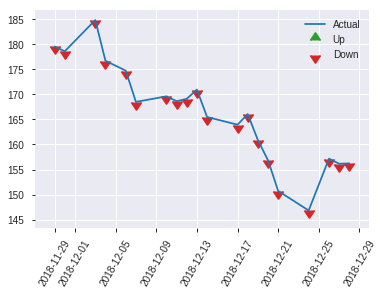


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5101214574898786
RMSE: 0.7142278750440076
LogLoss: 17.61897095448884
Null degrees of freedom: 246
Residual degrees of freedom: -797
Null deviance: 342.65506474663505
Residual deviance: 178515.89747013059
AIC: 180603.89747013059
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    126  0        (0.0/126.0)
Total  0    247  0.4899   (121.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.675603  0
max f2                       0            0.838881  0
max f0point5                 0            0.56553   0
max accuracy                 0            0.510121  0
max precision                0            0.510121  0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 51.01 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.510121         0        0.510121                    0                   1               1                          0       0

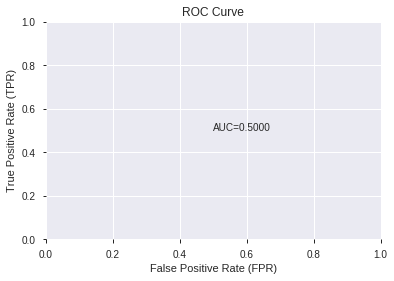

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


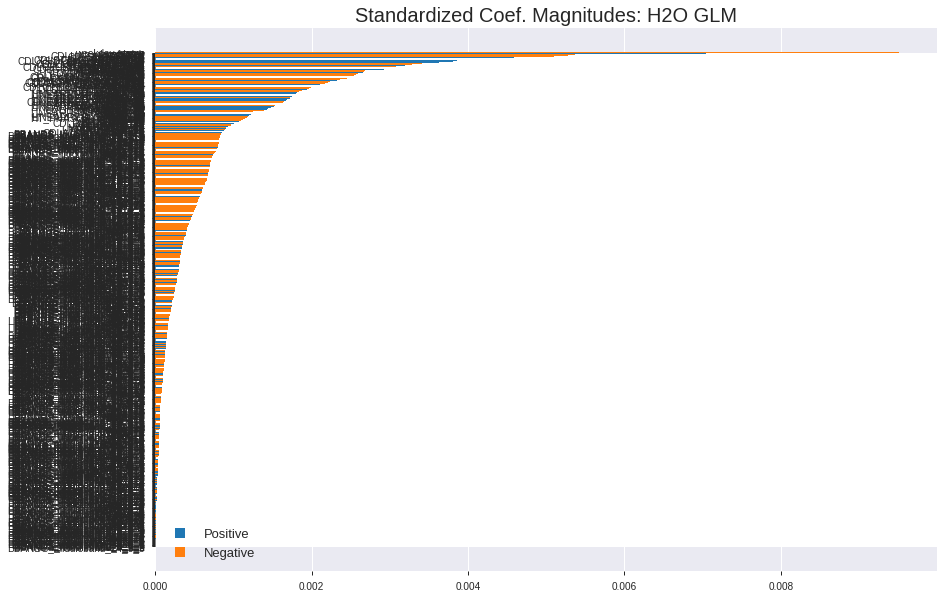

'log_likelihood'
--2019-07-25 01:02:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.224.240
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.224.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_010216_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_010216_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['weekday_name',
 'weekday',
 'dayofweek',
 'SINH',
 'EXP',
 'COSH',
 'CDLHARAMICROSS',
 'DX_8',
 'CDLHARAMI',
 'CDLSHORTLINE',
 'DX_12',
 'CORREL_8',
 'aroonup_8',
 'DX_14',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDLXSIDEGAP3METHODS',
 'DX_20',
 'STOCHRSI_fastk',
 'CDLENGULFING',
 'VAR_8',
 'CDLINNECK',
 'CDLLADDERBOTTOM',
 'CDLCOUNTERATTACK',
 'STOCHRSI_fastd',
 'CDL3INSIDE',
 'CCI_8',
 'DX_24',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowk',
 'STOCHF_fastd',
 'STDDEV_8',
 'CDLGRAVESTONEDOJI',
 'is_quarter_start',
 'HT_PHASOR_inphase',
 'aroonup_20',
 'aroondown_8',
 'CDL2CROWS',
 'is_month_start',
 'MOM_8',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'ADX_24',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'TANH',
 'AD',
 'MACDEXT_signal',
 'CDLINVERTEDHAMMER',
 'TAN',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'OBV',
 'aroondown_12',
 'dayofyear',
 'CDL3WHITESOLDIERS',
 'aroonup_24',
 'CDLMORNINGDOJISTAR',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'month',
 'CDLGAPSIDESIDEWHITE',
 'CD

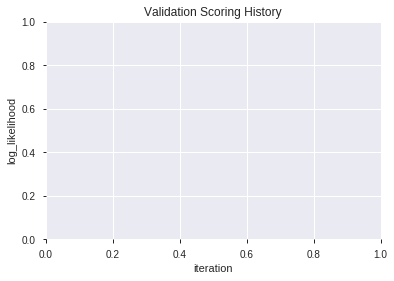

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190725_010301  0.546307  0.701769              0.444805  0.504116  0.254133
1               XGBoost_2_AutoML_20190725_010301  0.520464  0.710003              0.500000  0.507851  0.257913
2  XGBoost_grid_1_AutoML_20190725_010301_model_4  0.516398  0.709869              0.470746  0.508095  0.258160
3  XGBoost_grid_1_AutoML_20190725_010301_model_7  0.515873  0.709698              0.482979  0.507892  0.257954
4  XGBoost_grid_1_AutoML_20190725_010301_model_1  0.515283  0.750714              0.457202  0.526129  0.276812
5  XGBoost_grid_1_AutoML_20190725_010301_model_2  0.512659  0.707459              0.491736  0.506878  0.256925
6               XGBoost_3_AutoML_20190725_010301  0.509445  0.720648              0.478519  0.512939  0.263107
7  XGBoost_grid_1_AutoML_20190725_010301_model_5  0.492785  0.749172              0.483307  0.524611  0.275217
8  XGBoost_grid_1_AutoML_20190725_010301_model_3  0.491670  0.746119              0.500000  0.523978  0.274553
9  XGBoost_grid_1_AutoML_20190725_010301_model_6  0.455529  0.772370              0.487603  0.534902  0.286120

variable  relative_importance  scaled_importance    percentage
0               STOCHF_fastk           141.003845           1.000000  1.614163e-02
1                        TAN           135.630035           0.961889  1.552645e-02
2       HT_PHASOR_quadrature           132.385529           0.938879  1.515503e-02
3                  dayofweek           121.216011           0.859665  1.387638e-02
4                  CORREL_30           118.623978           0.841282  1.357966e-02
..                       ...                  ...                ...           ...
293   BBANDS_lowerband_8_1_5             1.232623           0.008742  1.411064e-04
294  BBANDS_upperband_12_0_4             1.050007           0.007447  1.202011e-04
295                    VAR_8             1.012764           0.007183  1.159377e-04
296  BBANDS_lowerband_30_0_2             0.975512           0.006918  1.116731e-04
297   BBANDS_lowerband_8_0_5             0.004335           0.000031  4.963018e-07

[298 rows x 4 columns]

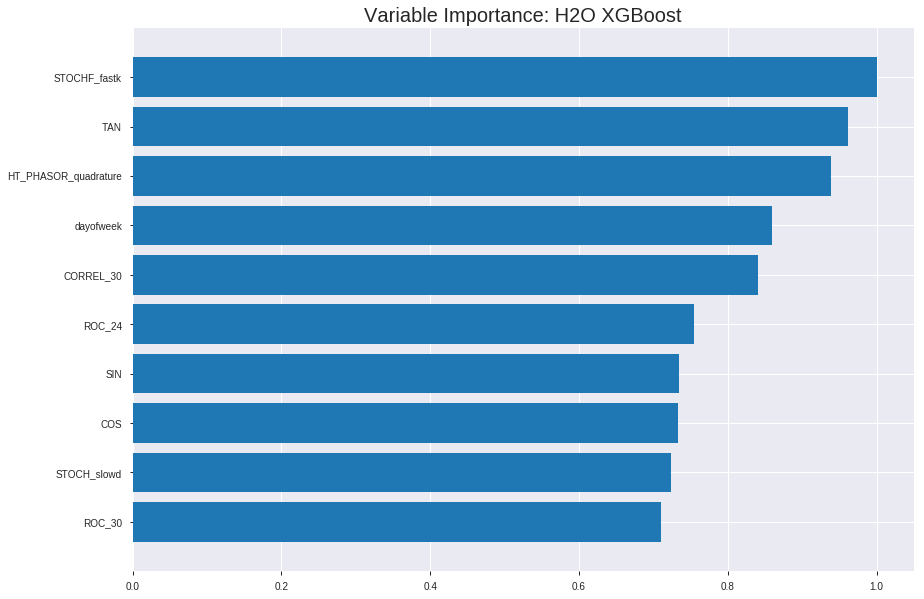

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190725_010301


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13651291349933065
RMSE: 0.36947653984973206
LogLoss: 0.4541350065685518
Mean Per-Class Error: 0.06497013983297728
AUC: 0.981267263330528
pr_auc: 0.9834752735971414
Gini: 0.9625345266610561
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5415639281272888: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      775  38   0.0467   (38.0/813.0)
1      76   836  0.0833   (76.0/912.0)
Total  851  874  0.0661   (114.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.541564     0.93617   186
max f2                       0.489257     0.949299  215
max f0point5                 0.543287     0.948864  185
max accuracy                 0.543287     0.933913  185
max precision                0.848614     1         0
max recall                   0.369889     1         292
max specificity              0.848614     1         0
max absolute_mcc             0.543287     0.868678  185
max min_per_class_accuracy   0.526357     0.932018  194
max mean_per_class_accuracy  0.543287     0.93503   185

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.803711           1.89145    1.89145            1                0.816926  1                           0.816926            0.0197368       0.0197368                  89.1447   89.1447
    2        0.0202899                   0.788              1.89145    1.89145            1                0.795531  1                           0.806534            0.0186404       0.0383772                  89.1447   89.1447
    3        0.0301449                   0.772992           1.89145    1.89145            1                0.780287  1                           0.797953            0.0186404       0.0570175                  89.1447   89.1447
    4        0.04                        0.766422           1.89145    1.89145            1                0.769866  1                           0.791033            0.0186404       0.0756579                  89.1447   89.1447
    5        0.0504348                   0.761709           1.89145    1.89145            1                0.764012  1                           0.785442            0.0197368       0.0953947                  89.1447   89.1447
    6        0.10029                     0.726762           1.89145    1.89145            1                0.742098  1                           0.763895            0.0942982       0.189693                   89.1447   89.1447
    7        0.150145                    0.707388           1.89145    1.89145            1                0.715899  1                           0.747958            0.0942982       0.283991                   89.1447   89.1447
    8        0.2                         0.687327           1.89145    1.89145            1                0.69755   1                           0.735393            0.0942982       0.378289                   89.1447   89.1447
    9        0.30029                     0.653194           1.88051    1.8878             0.99422          0.670122  0.998069                    0.713594            0.188596        0.566886                   88.0514   88.7796
    10       0.4                         0.603633           1.84746    1.87774            0.976744         0.63109   0.992754                    0.693028            0.184211        0.751096                   84.746    87.7741
    11       0.50029                     0.545234           1.55252    1.81255            0.820809         0.575038  0.958285                    0.669375            0.155702        0.906798                   55.2517   81.2546
    12       0.6                         0.467121           0.61582    1.61367            0.325581         0.505278  0.85314                     0.642105            0.0614035       0.968202                   -38.418   61.367
    13       0.69971                     0.406987           0.252926   1.41976            0.133721         0.435496  0.750621                    0.612663            0.0252193       0.993421                   -74.7074  41.9761
    14       0.8                         0.342712           0.0655993  1.25               0.0346821        0.375621  0.66087                     0.582947            0.00657895      1                          -93.4401  25
    15       0.89971                     0.287528           0          1.11147            0                0.316763  0.587629                    0.553447            0               1                          -100      11.1469
    16       1                           0.152421           0          1                  0                0.248944  0.528696                    0.522



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2683731300046561
RMSE: 0.5180474206138431
LogLoss: 0.7322144943850547
Mean Per-Class Error: 0.46493295273499735
AUC: 0.5016097981943707
pr_auc: 0.5387605526068368
Gini: 0.0032195963887413637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19566334784030914: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.195663     0.706037   399
max f2                       0.195663     0.857234   399
max f0point5                 0.314614     0.60643    359
max accuracy                 0.314614     0.559838   359
max precision                0.691215     0.727273   10
max recall                   0.195663     1          399
max specificity              0.771795     0.995536   0
max absolute_mcc             0.756624     0.0857462  2
max min_per_class_accuracy   0.450437     0.491071   204
max mean_per_class_accuracy  0.387449     0.535067   280

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.723478           0.733086  0.733086           0.4              0.750952  0.4                         0.750952            0.00743494      0.00743494                 -26.6914  -26.6914
    2        0.020284                    0.691557           1.83271   1.2829             1                0.705157  0.7                         0.728055            0.0185874       0.0260223                  83.2714   28.29
    3        0.030426                    0.675335           0.733086  1.09963            0.4              0.686783  0.6                         0.714297            0.00743494      0.0334572                  -26.6914  9.96283
    4        0.040568                    0.661743           1.46617   1.19126            0.8              0.668107  0.65                        0.70275             0.0148699       0.0483271                  46.6171   19.1264
    5        0.0507099                   0.652223           0.366543  1.02632            0.2              0.656766  0.56                        0.693553            0.00371747      0.0520446                  -63.3457  2.63197
    6        0.10142                     0.610705           0.733086  0.879703           0.4              0.631016  0.48                        0.662285            0.0371747       0.0892193                  -26.6914  -12.0297
    7        0.150101                    0.584197           1.06908   0.941123           0.583333         0.59845   0.513514                    0.641582            0.0520446       0.141264                   6.9083    -5.88767
    8        0.200811                    0.557993           0.733086  0.888588           0.4              0.572115  0.484848                    0.624039            0.0371747       0.178439                   -26.6914  -11.1412
    9        0.300203                    0.515451           0.935058  0.903974           0.510204         0.535573  0.493243                    0.59475             0.0929368       0.271375                   -6.4942   -9.60263
    10       0.399594                    0.48304            1.23428   0.98613            0.673469         0.500217  0.538071                    0.571237            0.122677        0.394052                   23.4277   -1.38698
    11       0.501014                    0.450401           0.989665  0.986846           0.54             0.467702  0.538462                    0.550278            0.100372        0.494424                   -1.03346  -1.31541
    12       0.600406                    0.422594           1.19687   1.02161            0.653061         0.43634   0.557432                    0.531417            0.118959        0.613383                   19.6874   2.16141
    13       0.699797                    0.389699           1.12207   1.03588            0.612245         0.404868  0.565217                    0.513443            0.111524        0.724907                   12.207    3.58817
    14       0.799189                    0.356557           0.860253  1.01404            0.469388         0.372739  0.553299                    0.495944            0.0855019       0.810409                   -13.9747  1.40396
    15       0.89858                     0.317277           1.04727   1.01771            0.571429         0.338185  0.555305                    0.478495            0.104089        0.914498                   4.7265    1.77146
    16       1                           0.195663           0.843048  1                  0.46             0.277271  0.545639                    0.458087    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:03:01  0.008 sec   0                  0.5              0.693147            0.5             0                  1                0.471304                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 01:03:02  0.834 sec   5                  0.480839         0.655435            0.83507         0.835911           1.68129          0.250435                         0.501362           0.695886              0.500224          0.555496             1.09963            0.454361
    2019-07-25 01:03:02  1.098 sec   10                 0.465037         0.625112            0.877337        0.88132            1.78637          0.213913                         0.504102           0.701454              0.484201          0.545643             0.733086           0.454361
    2019-07-25 01:03:03  1.361 sec   15                 0.449113         0.595184            0.913297        0.921563           1.89145          0.171014                         0.503858           0.701024              0.513434          0.557109             0.733086           0.452333
    2019-07-25 01:03:03  1.591 sec   20                 0.434196         0.567768            0.936194        0.942003           1.89145          0.13913                          0.507332           0.708308              0.50785           0.546338             0.733086           0.452333
    2019-07-25 01:03:03  1.801 sec   25                 0.421864         0.545371            0.947199        0.952834           1.89145          0.129275                         0.50717            0.70803               0.509161          0.549216             1.09963            0.452333
    2019-07-25 01:03:03  2.012 sec   30                 0.409475         0.523181            0.955681        0.961206           1.89145          0.113043                         0.507613           0.709027              0.511094          0.547678             1.09963            0.452333
    2019-07-25 01:03:04  2.229 sec   35                 0.399139         0.504976            0.963133        0.967309           1.89145          0.108986                         0.510711           0.715674              0.512381          0.546598             1.09963            0.454361
    2019-07-25 01:03:04  2.462 sec   40                 0.388639         0.486713            0.970474        0.974448           1.89145          0.0898551                        0.51261            0.719949              0.510978          0.549688             0.733086           0.452333
    2019-07-25 01:03:04  2.676 sec   45                 0.379342         0.470766            0.976382        0.979495           1.89145          0.0776812                        0.515783           0.727065              0.504838          0.544488             0.733086           0.450304
    2019-07-25 01:03:04  2.900 sec   50                 0.369477         0.454135            0.981267        0.983475           1.89145          0.066087                         0.518047           0.732214              0.50161           0.538761             0.733086           0.454361

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
STOCHF_fastk             141.00384521484375     1.0                    0.01614162568773765
TAN                      135.63003540039062     0.9618889129848537     0.015526450786586363
HT_PHASOR_quadrature     132.38552856445312     0.9388788537131089     0.015155031022769199
dayofweek                121.21601104736328     0.8596645776763727     0.013876383829859078
CORREL_30                118.62397766113281     0.8412818634866919     0.013579656938284586
---                      ---                    ---                    ---
BBANDS_lowerband_8_1_5   1.2326233386993408     0.008741771097243667   0.00014110639689959094
BBANDS_upperband_12_0_4  1.0500068664550781     0.007446654130993456   0.00012020110360854168
VAR_8                    1.0127639770507812     0.007182527366595288   0.00011593766824351318
BBANDS_lowerband_30_0_2  0.9755115509033203     0.006918332967565244   0.0001116731411455734
BBANDS_lowerband_8_0_5   0.0043354034423828125  3.074670365036553e-05  4.963017814559972e-07


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6842105263157894)

('auc', 0.54630722812541)

('logloss', 0.7017689542885338)

('mean_per_class_error', 0.44480519480519476)

('rmse', 0.5041156741856685)

('mse', 0.2541326129596711)

xgboost prediction progress: |████████████████████████████████████████████| 100%


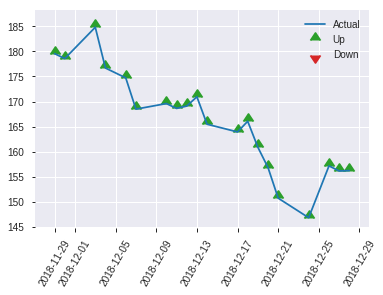


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541326129596711
RMSE: 0.5041156741856685
LogLoss: 0.7017689542885338
Mean Per-Class Error: 0.44480519480519476
AUC: 0.54630722812541
pr_auc: 0.5386558404419272
Gini: 0.09261445625081999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34878790378570557: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   99   0.8182   (99.0/121.0)
1      9    117  0.0714   (9.0/126.0)
Total  31   216  0.4372   (108.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348788     0.684211  215
max f2                       0.260309     0.84      245
max f0point5                 0.348788     0.590909  215
max accuracy                 0.348788     0.562753  215
max precision                0.68094      1         0
max recall                   0.260309     1         245
max specificity              0.68094      1         0
max absolute_mcc             0.348788     0.166571  215
max min_per_class_accuracy   0.456316     0.52381   120
max mean_per_class_accuracy  0.348788     0.555195  215

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.664922           1.30688   1.30688            0.666667         0.676403  0.666667                    0.676403            0.015873        0.015873                   30.6878   30.6878
    2        0.0202429                   0.64916            0.980159  1.17619            0.5              0.653322  0.6                         0.66717             0.00793651      0.0238095                  -1.98413  17.619
    3        0.0323887                   0.641466           0.653439  0.980159           0.333333         0.645921  0.5                         0.659202            0.00793651      0.031746                   -34.6561  -1.98413
    4        0.0404858                   0.6383             0.980159  0.980159           0.5              0.63871   0.5                         0.655104            0.00793651      0.0396825                  -1.98413  -1.98413
    5        0.0526316                   0.634117           1.30688   1.05556            0.666667         0.636357  0.538462                    0.650777            0.015873        0.0555556                  30.6878   5.55556
    6        0.101215                    0.591708           1.47024   1.2546             0.75             0.613014  0.64                        0.632651            0.0714286       0.126984                   47.0238   25.4603
    7        0.149798                    0.552243           0.816799  1.11261            0.416667         0.573668  0.567568                    0.613521            0.0396825       0.166667                   -18.3201  11.2613
    8        0.202429                    0.538727           0.904762  1.05857            0.461538         0.544645  0.54                        0.595613            0.047619        0.214286                   -9.52381  5.85714
    9        0.299595                    0.504759           1.06184   1.05963            0.541667         0.519581  0.540541                    0.570954            0.103175        0.31746                    6.18386   5.96311
    10       0.40081                     0.475947           1.09778   1.06926            0.56             0.487617  0.545455                    0.549909            0.111111        0.428571                   9.77778   6.92641
    11       0.502024                    0.454924           0.940952  1.04339            0.48             0.464175  0.532258                    0.532624            0.0952381       0.52381                    -5.90476  4.33948
    12       0.59919                     0.42452            0.898479  1.01989            0.458333         0.44213   0.52027                     0.51795             0.0873016       0.611111                   -10.1521  1.98949
    13       0.700405                    0.395006           1.2546    1.05381            0.64             0.408731  0.537572                    0.502167            0.126984        0.738095                   25.4603   5.38123
    14       0.797571                    0.363908           0.980159  1.04484            0.5              0.377828  0.532995                    0.487019            0.0952381       0.833333                   -1.98413  4.48393
    15       0.898785                    0.337419           1.01937   1.04197            0.52             0.35439   0.531532                    0.472083            0.103175        0.936508                   1.93651   4.19705
    16       1                           0.252739           0.627302  1                  0.32             0.308981  0.510121                    0.455575        

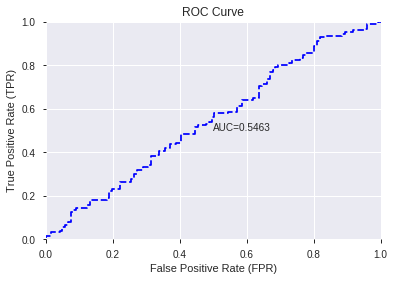

This function is available for GLM models only


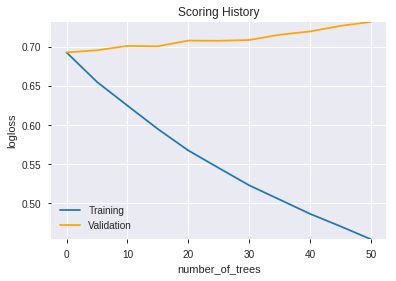

--2019-07-25 01:03:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190725_010301',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190725_010301',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_b977',
   'type

['STOCHF_fastk',
 'TAN',
 'HT_PHASOR_quadrature',
 'dayofweek',
 'CORREL_30',
 'ROC_24',
 'SIN',
 'COS',
 'STOCH_slowd',
 'ROC_30',
 'BOP',
 'DIV',
 'dayofyear',
 'WILLR_12',
 'ADX_8',
 'weekday_name',
 'MOM_8',
 'CCI_8',
 'CORREL_14',
 'Volume',
 'WILLR_8',
 'CORREL_8',
 'ADOSC',
 'BETA_14',
 'BETA_30',
 'STOCHRSI_fastd',
 'CORREL_12',
 'CCI_20',
 'CCI_24',
 'STDDEV_14',
 'MFI_14',
 'CCI_14',
 'CMO_8',
 'MACDFIX_hist_8',
 'STOCH_slowk',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'AD',
 'ULTOSC',
 'CORREL_20',
 'MOM_12',
 'weekday',
 'DX_20',
 'BETA_12',
 'LINEARREG_ANGLE_12',
 'day',
 'LINEARREG_ANGLE_24',
 'MINUS_DI_30',
 'DX_8',
 'STDDEV_8',
 'MACDEXT_hist',
 'MFI_20',
 'MOM_20',
 'WILLR_14',
 'SUB',
 'LINEARREG_ANGLE_14',
 'MOM_14',
 'BETA_24',
 'MFI_12',
 'ADXR_12',
 'ADXR_14',
 'ROC_8',
 'SAREXT',
 'MFI_24',
 'STDDEV_20',
 'MFI_8',
 'OBV',
 'MINUS_DI_12',
 'MINUS_DM_8',
 'TRANGE',
 'BETA_8',
 'ADXR_8',
 'PLUS_DI_14',
 'ADX_24',
 'ATR_20',
 'MACDFIX_hist_12',
 'RSI_8',
 'MFI_30',
 'DX_12

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

64

['BBANDS_upperband_14_6_3',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_20_1_2',
 'BOP',
 'ADX_8',
 'aroonup_8',
 'CCI_8',
 'MINUS_DI_8',
 'MOM_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROCP_8',
 'aroonup_12',
 'AROONOSC_12',
 'CCI_12',
 'CMO_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ADX_14',
 'aroonup_14',
 'DX_14',
 'MACDFIX_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'MACDFIX_hist_20',
 'MFI_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROC_20',
 'ADX_24',
 'CCI_24',
 'MINUS_DI_24',
 'MINUS_DM_24',
 'MOM_24',
 'PLUS_DM_24',
 'MINUS_DI_30',
 'ROCP_30',
 'APO',
 'MACD',
 'MACD_hist',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'NATR_8',
 'NATR_14',
 'ATR_20',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'CORREL_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'BETA_12',
 'CORREL_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_010505_model_3  0.520071  1.401182              0.483143  0.629422  0.396172
1  DeepLearning_grid_1_AutoML_20190725_010505_model_9  0.496589  0.695092              0.491736  0.500965  0.250966
2  DeepLearning_grid_1_AutoML_20190725_010505_model_4  0.489833  1.066715              0.495704  0.601403  0.361686
3  DeepLearning_grid_1_AutoML_20190725_010505_model_1  0.486128  1.804615              0.491408  0.639365  0.408788
4  DeepLearning_grid_1_AutoML_20190725_010505_model_5  0.474944  0.743240              0.495868  0.521347  0.271802
5  DeepLearning_grid_1_AutoML_20190725_010505_model_2  0.470091  2.673539              0.500000  0.679634  0.461903
6  DeepLearning_grid_1_AutoML_20190725_010505_model_8  0.466942  0.708465              0.495704  0.507454  0.257510
7  DeepLearning_grid_1_AutoML_20190725_010505_model_7  0.465696  0.960227              0.500000  0.577084  0.333026
8  DeepLearning_grid_1_AutoML_20190725_010505_model_6  0.460350  0.728342              0.500000  0.514417  0.264624
9               DeepLearning_1_AutoML_20190725_010505  0.443985  1.185707              0.500000  0.619187  0.383393

variable  relative_importance  scaled_importance  percentage
0        CORREL_12             1.000000           1.000000    0.021390
1   STOCHRSI_fastk             0.997479           0.997479    0.021336
2        aroonup_8             0.992242           0.992242    0.021224
3              BOP             0.949466           0.949466    0.020309
4      HT_DCPERIOD             0.943080           0.943080    0.020172
..             ...                  ...                ...         ...
59             APO             0.617194           0.617194    0.013202
60          CMO_12             0.615867           0.615867    0.013173
61      MINUS_DI_8             0.601057           0.601057    0.012857
62          RSI_14             0.596090           0.596090    0.012750
63       MACD_hist             0.588148           0.588148    0.012580

[64 rows x 4 columns]

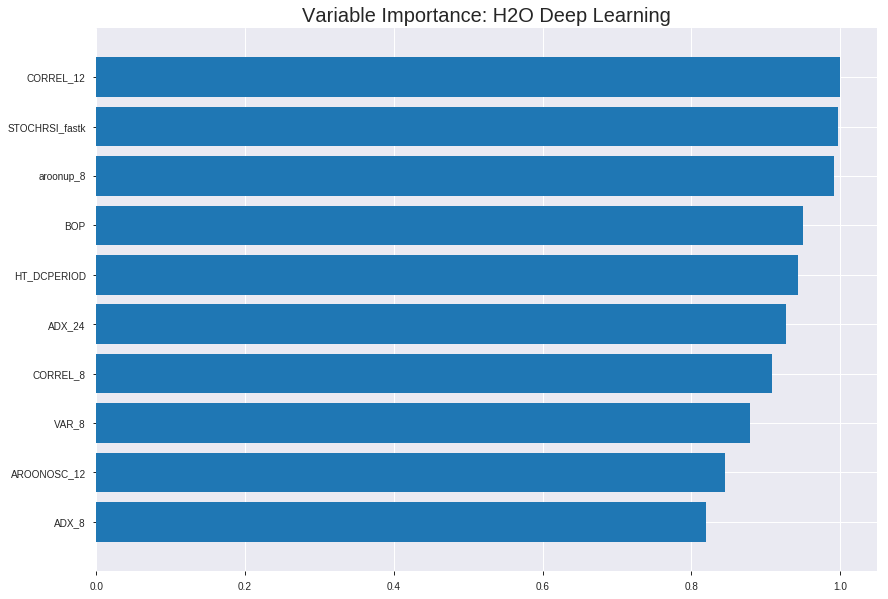

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_010505_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26785233230111394
RMSE: 0.5175445220472475
LogLoss: 0.767745688964253
Mean Per-Class Error: 0.4028087978248204
AUC: 0.6202640480352172
pr_auc: 0.6292845801469467
Gini: 0.24052809607043435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.010108375915670435: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    811   0.9975   (811.0/813.0)
1      0    912   0        (0.0/912.0)
Total  2    1723  0.4701   (811.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0101084    0.69222   398
max f2                       0.0101084    0.849004  398
max f0point5                 0.410672     0.618056  220
max accuracy                 0.410672     0.596522  220
max precision                0.995641     1         0
max recall                   0.0101084    1         398
max specificity              0.995641     1         0
max absolute_mcc             0.410672     0.194076  220
max min_per_class_accuracy   0.401727     0.592866  224
max mean_per_class_accuracy  0.410672     0.597191  220

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 42.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.954466           1.36605   1.36605            0.722222         0.97445    0.722222                    0.97445             0.0142544       0.0142544                  36.6045   36.6045
    2        0.0202899                   0.923265           1.22388   1.29699            0.647059         0.937535   0.685714                    0.95652             0.0120614       0.0263158                  22.3878   29.6992
    3        0.0301449                   0.900879           0.890093  1.16397            0.470588         0.910894   0.615385                    0.941604            0.00877193      0.0350877                  -10.9907  16.3968
    4        0.04                        0.880708           1.22388   1.17873            0.647059         0.890174   0.623188                    0.928933            0.0120614       0.0471491                  22.3878   17.8728
    5        0.0504348                   0.864553           1.78637   1.30445            0.944444         0.871918   0.689655                    0.917136            0.0186404       0.0657895                  78.6367   30.4446
    6        0.10029                     0.789202           1.34161   1.32292            0.709302         0.824529   0.699422                    0.871101            0.066886        0.132675                   34.1608   32.292
    7        0.150145                    0.719159           1.20965   1.28531            0.639535         0.752763   0.679537                    0.831807            0.060307        0.192982                   20.9647   28.5308
    8        0.2                         0.654853           1.3636    1.30482            0.72093          0.686573   0.689855                    0.795604            0.0679825       0.260965                   36.3602   30.4825
    9        0.30029                     0.557547           1.10426   1.23784            0.583815         0.604335   0.65444                     0.731725            0.110746        0.371711                   10.4255   23.7839
    10       0.4                         0.477645           1.13267   1.21162            0.598837         0.5175     0.64058                     0.678324            0.112939        0.484649                   13.2669   21.1623
    11       0.50029                     0.404487           1.03866   1.17695            0.549133         0.440425   0.622248                    0.630634            0.104167        0.588816                   3.86561   17.6949
    12       0.6                         0.328917           0.89074   1.12939            0.47093          0.367085   0.597101                    0.586836            0.0888158       0.677632                   -10.926   12.9386
    13       0.69971                     0.266764           0.978714  1.10791            0.517442         0.297808   0.58575                     0.545649            0.0975877       0.775219                   -2.1286   10.7915
    14       0.8                         0.19642            0.754392  1.0636             0.398844         0.234032   0.562319                    0.506584            0.0756579       0.850877                   -24.5608  6.35965
    15       0.89971                     0.116812           0.769775  1.03103            0.406977         0.159303   0.545103                    0.468097            0.0767544       0.927632                   -23.0225  3.10338
    16       1                           0.00643165         0.721593  1                  0.381503         0.0767809  0.528696                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.33670262637252246
RMSE: 0.580260826157102
LogLoss: 0.9665147987641485
Mean Per-Class Error: 0.47564557886351566
AUC: 0.49863084174190125
pr_auc: 0.5492458590484874
Gini: -0.002738316516197492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.018564478980906806: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    222  0.9911   (222.0/224.0)
1      1    268  0.0037   (1.0/269.0)
Total  3    490  0.4523   (223.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0185645    0.706192   396
max f2                       0.0124057    0.857234   399
max f0point5                 0.0290003    0.602082   391
max accuracy                 0.0290003    0.549696   391
max precision                0.885288     0.692308   11
max recall                   0.0124057    1          399
max specificity              0.978129     0.995536   0
max absolute_mcc             0.155111     0.0780798  313
max min_per_class_accuracy   0.325953     0.513393   210
max mean_per_class_accuracy  0.318695     0.524354   213

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 36.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.937808           1.09963   1.09963            0.6              0.969329  0.6                         0.969329            0.0111524       0.0111524                  9.96283    9.96283
    2        0.020284                    0.911876           1.09963   1.09963            0.6              0.929358  0.6                         0.949343            0.0111524       0.0223048                  9.96283    9.96283
    3        0.030426                    0.870626           1.09963   1.09963            0.6              0.890338  0.6                         0.929675            0.0111524       0.0334572                  9.96283    9.96283
    4        0.040568                    0.856388           1.09963   1.09963            0.6              0.863889  0.6                         0.913229            0.0111524       0.0446097                  9.96283    9.96283
    5        0.0507099                   0.829059           0.366543  0.953011           0.2              0.845181  0.52                        0.899619            0.00371747      0.0483271                  -63.3457   -4.69888
    6        0.10142                     0.714357           1.09963   1.02632            0.6              0.767906  0.56                        0.833763            0.0557621       0.104089                   9.96283    2.63197
    7        0.150101                    0.6505             0.99272   1.01542            0.541667         0.685276  0.554054                    0.785605            0.0483271       0.152416                   -0.728005  1.54225
    8        0.200811                    0.599182           0.953011  0.999662           0.52             0.628144  0.545455                    0.745842            0.0483271       0.200743                   -4.69888   -0.0337952
    9        0.300203                    0.483251           1.00986   1.00304            0.55102          0.533924  0.547297                    0.67568             0.100372        0.301115                   0.986268   0.303928
    10       0.399594                    0.395634           1.04727   1.01404            0.571429         0.439969  0.553299                    0.617051            0.104089        0.405204                   4.7265     1.40396
    11       0.501014                    0.326044           1.06297   1.02395            0.58             0.359686  0.558704                    0.564953            0.107807        0.513011                   6.2974     2.39453
    12       0.600406                    0.248908           0.785449  0.984464           0.428571         0.285926  0.537162                    0.518763            0.0780669       0.591078                   -21.4551   -1.55355
    13       0.699797                    0.199099           1.00986   0.988072           0.55102          0.223738  0.53913                     0.476861            0.100372        0.69145                    0.986268   -1.19282
    14       0.799189                    0.14171            0.860253  0.972176           0.469388         0.169146  0.530457                    0.438592            0.0855019       0.776952                   -13.9747   -2.78244
    15       0.89858                     0.0809507          1.23428   1.00117            0.673469         0.114523  0.546275                    0.402747            0.122677        0.899628                   23.4277    0.116643
    16       1                           0.0124057          0.989665  1                  0.54             0.050699  0.545639           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:06:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 01:06:33  1 min 26.736 sec  6037 obs/sec      10        1             17250      0.553517         0.897055            -0.229573      0.580614        0.592537           1.0508           0.464928                         0.613941           1.19504               -0.520361        0.493835          0.549502             0.733086           0.454361
    2019-07-25 01:06:40  1 min 33.386 sec  7325 obs/sec      40        4             69000      0.517545         0.767746            -0.07495       0.620264        0.629285           1.36605          0.470145                         0.580261           0.966515              -0.358126        0.498631          0.549246             1.09963            0.452333
    2019-07-25 01:06:45  1 min 38.768 sec  8206 obs/sec      70        7             120750     0.500322         0.719564            -0.00459701    0.658167        0.664712           1.57621          0.427246                         0.583298           0.999496              -0.372381        0.504821          0.55589              1.09963            0.454361
    2019-07-25 01:06:51  1 min 44.798 sec  9185 obs/sec      110       11            189750     0.484339         0.688501            0.0585628      0.710991        0.720473           1.78637          0.37913                          0.606283           1.13478               -0.48267         0.490499          0.539747             1.09963            0.454361
    2019-07-25 01:06:57  1 min 50.282 sec  9932 obs/sec      150       15            258750     0.466383         0.638908            0.127072       0.749336        0.760707           1.89145          0.321739                         0.605437           1.13206               -0.478534        0.497618          0.548332             1.46617            0.454361
    2019-07-25 01:07:02  1 min 55.391 sec  10547 obs/sec     190       19            327750     0.442135         0.590351            0.215484       0.789859        0.806495           1.89145          0.302029                         0.61631            1.2265                -0.532116        0.494241          0.542196             1.09963            0.454361
    2019-07-25 01:07:02  1 min 55.482 sec  10546 obs/sec     190       19            327750     0.517545         0.767746            -0.07495       0.620264        0.629285           1.36605          0.470145                         0.580261           0.966515              -0.358126        0.498631          0.549246             1.09963            0.452333

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
CORREL_12       1.0                    1.0                  0.021389995012129535
STOCHRSI_fastk  0.9974787831306458     0.9974787831306458   0.02133606619586955
aroonup_8       0.9922424554824829     0.9922424554824829   0.021224061173593472
BOP             0.9494662880897522     0.9494662880897522   0.020309079166424944
HT_DCPERIOD     0.9430795907974243     0.9430795907974243   0.02017246774319807
---             ---                    ---                  ---
APO             0.617193877696991      0.617193877696991    0.013201773965455523
CMO_12          0.6158674359321594     0.6158674359321594   0.013173401382721895
MINUS_DI_8      0.6010568737983704     0.6010568737983704   0.012856603532553313
RSI_14          0.5960898995399475     0.5960898995399475   0.012750359977940271
MACD_hist       0.5881484746932983     0.5881484746932983   0.012580492940081244


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5344129554655871)

('F1', 0.6794520547945206)

('auc', 0.5200708382526564)

('logloss', 1.4011816277954883)

('mean_per_class_error', 0.46687655778564874)

('rmse', 0.6294219678017218)

('mse', 0.3961720135513917)

deeplearning prediction progress: |███████████████████████████████████████| 100%


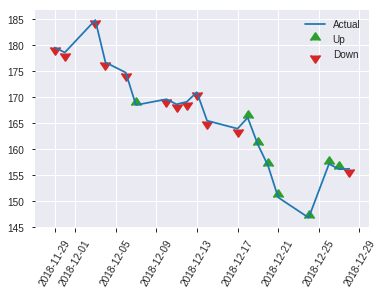


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3961720135513917
RMSE: 0.6294219678017218
LogLoss: 1.4011816277954883
Mean Per-Class Error: 0.46687655778564874
AUC: 0.5200708382526564
pr_auc: 0.5284168502249711
Gini: 0.04014167650531286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004585957378043462: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    115  0.9504   (115.0/121.0)
1      2    124  0.0159   (2.0/126.0)
Total  8    239  0.4737   (117.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00458596   0.679452   238
max f2                       0.00124249   0.84       245
max f0point5                 0.0112675    0.574257   220
max accuracy                 0.0209767    0.534413   190
max precision                0.999262     1          0
max recall                   0.00124249   1          245
max specificity              0.999262     1          0
max absolute_mcc             0.00458596   0.0952009  238
max min_per_class_accuracy   0.111362     0.507937   122
max mean_per_class_accuracy  0.216048     0.533123   89

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 23.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.988467           1.30688   1.30688            0.666667         0.99644    0.666667                    0.99644             0.015873        0.015873                   30.6878   30.6878
    2        0.0202429                   0.954001           1.96032   1.56825            1                0.974589   0.8                         0.987699            0.015873        0.031746                   96.0317   56.8254
    3        0.0323887                   0.929407           0.653439  1.2252             0.333333         0.945184   0.625                       0.971756            0.00793651      0.0396825                  -34.6561  22.5198
    4        0.0404858                   0.914811           0.980159  1.17619            0.5              0.92096    0.6                         0.961597            0.00793651      0.047619                   -1.98413  17.619
    5        0.0526316                   0.887146           0.653439  1.05556            0.333333         0.903717   0.538462                    0.94824             0.00793651      0.0555556                  -34.6561  5.55556
    6        0.101215                    0.702948           0.980159  1.01937            0.5              0.789108   0.52                        0.871857            0.047619        0.103175                   -1.98413  1.93651
    7        0.149798                    0.538379           0.816799  0.953668           0.416667         0.615562   0.486486                    0.788734            0.0396825       0.142857                   -18.3201  -4.6332
    8        0.202429                    0.408753           1.35714   1.05857            0.692308         0.478695   0.54                        0.708124            0.0714286       0.214286                   35.7143   5.85714
    9        0.299595                    0.266976           1.06184   1.05963            0.541667         0.348379   0.540541                    0.59145             0.103175        0.31746                    6.18386   5.96311
    10       0.40081                     0.178626           0.940952  1.02966            0.48             0.223152   0.525253                    0.498446            0.0952381       0.412698                   -5.90476  2.96617
    11       0.502024                    0.105629           0.940952  1.01178            0.48             0.138395   0.516129                    0.425855            0.0952381       0.507937                   -5.90476  1.17768
    12       0.59919                     0.0635825          0.980159  1.00665            0.5              0.0803686  0.513514                    0.36983             0.0952381       0.603175                   -1.98413  0.664951
    13       0.700405                    0.0331042          1.01937   1.00849            0.52             0.0497636  0.514451                    0.323578            0.103175        0.706349                   1.93651   0.848702
    14       0.797571                    0.0190615          1.14352   1.02494            0.583333         0.0239019  0.522843                    0.287069            0.111111        0.81746                    14.3519   2.49376
    15       0.898785                    0.0108192          1.01937   1.02431            0.52             0.0140517  0.522523                    0.256324            0.103175        0.920635                   1.93651   2.431
    16       1                           0.000834455        0.784127  1                  0.4              0.0061851  0.510121                    

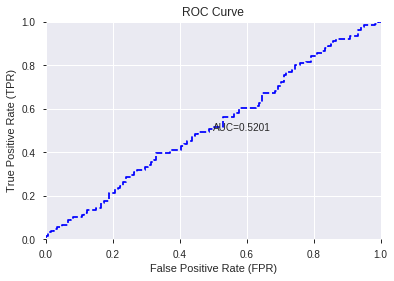

This function is available for GLM models only


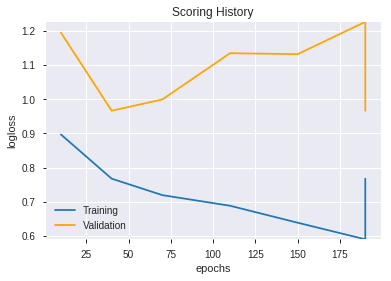

--2019-07-25 01:13:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_010505_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_010505_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_12',
 'STOCHRSI_fastk',
 'aroonup_8',
 'BOP',
 'HT_DCPERIOD',
 'ADX_24',
 'CORREL_8',
 'VAR_8',
 'AROONOSC_12',
 'ADX_8',
 'aroondown_20',
 'ADX_14',
 'CDLSPINNINGTOP',
 'aroonup_12',
 'DX_14',
 'BETA_12',
 'NATR_8',
 'NATR_14',
 'STOCHRSI_fastd',
 'MINUS_DI_30',
 'PLUS_DM_24',
 'MACDEXT_hist',
 'MINUS_DM_24',
 'STOCH_slowd',
 'MFI_20',
 'STOCHF_fastk',
 'WILLR_14',
 'aroonup_14',
 'CCI_8',
 'ROCP_30',
 'PLUS_DM_8',
 'STOCH_slowk',
 'STOCHF_fastd',
 'ULTOSC',
 'PLUS_DM_14',
 'MOM_24',
 'PLUS_DI_8',
 'MOM_20',
 'BBANDS_upperband_14_6_3',
 'ROC_14',
 'ATR_20',
 'ROCR100_14',
 'ROC_20',
 'MACD',
 'BBANDS_lowerband_20_1_2',
 'MACDFIX_14',
 'PLUS_DI_20',
 'ROCP_8',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'CCI_24',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_20',
 'BBANDS_lowerband_14_7_4',
 'MINUS_DI_24',
 'ROC_12',
 'ROCP_12',
 'PLUS_DI_12',
 'CCI_12',
 'APO',
 'CMO_12',
 'MINUS_DI_8',
 'RSI_14',
 'MACD_hist']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_011351_model_1  0.535222  0.692667              0.491572  0.499761  0.249761

variable  relative_importance  scaled_importance  percentage
0   BBANDS_lowerband_20_1_2             0.006800           1.000000    0.042625
1   BBANDS_lowerband_14_7_4             0.006793           0.998980    0.042582
2   BBANDS_upperband_14_6_3             0.006652           0.978157    0.041694
3                PLUS_DM_24             0.006553           0.963727    0.041079
4                    ATR_20             0.006331           0.930975    0.039683
..                      ...                  ...                ...         ...
59          MACDFIX_hist_20             0.000226           0.033242    0.001417
60               ROCR100_14             0.000156           0.022974    0.000979
61                   ROC_14             0.000153           0.022548    0.000961
62              AROONOSC_12             0.000030           0.004442    0.000189
63                   ADX_14             0.000004           0.000519    0.000022

[64 rows x 4 columns]

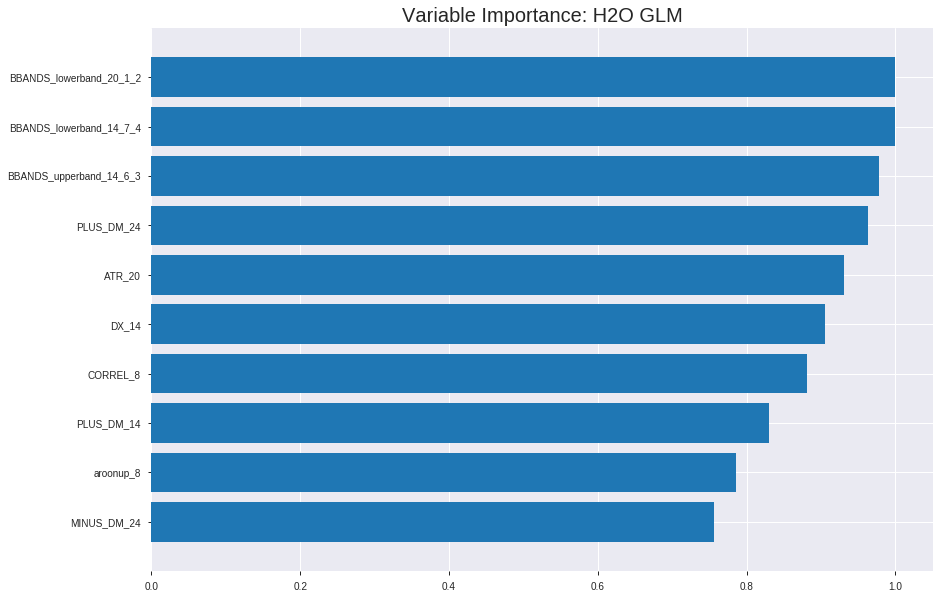

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_011351_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24768139293797403
RMSE: 0.49767599192443873
LogLoss: 0.6884962067321552
Null degrees of freedom: 1724
Residual degrees of freedom: 1660
Null deviance: 2385.6729106355115
Residual deviance: 2375.3119132259353
AIC: 2505.3119132259353
AUC: 0.5625788988153039
pr_auc: 0.5759791173880073
Gini: 0.12515779763060775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49366752279576276: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    810   0.9963   (810.0/813.0)
1      1    911   0.0011   (1.0/912.0)
Total  4    1721  0.4701   (811.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493668     0.691986  395
max f2                       0.490701     0.848846  398
max f0point5                 0.516938     0.592194  281
max accuracy                 0.522591     0.562899  247
max precision                0.55089      0.648241  68
max recall                   0.490701     1         398
max specificity              0.56897      0.99754   0
max absolute_mcc             0.522591     0.115365  247
max min_per_class_accuracy   0.528558     0.548585  207
max mean_per_class_accuracy  0.522591     0.55598   247

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.563099           0.945724  0.945724           0.5              0.565475  0.5                         0.565475            0.00986842      0.00986842                 -5.42763  -5.42763
    2        0.0202899                   0.561998           1.11262   1.02679            0.588235         0.562407  0.542857                    0.563985            0.0109649       0.0208333                  11.2616   2.67857
    3        0.0301449                   0.560881           1.33514   1.12759            0.705882         0.561492  0.596154                    0.56317             0.0131579       0.0339912                  33.5139   12.7594
    4        0.04                        0.559526           1.22388   1.15132            0.647059         0.560438  0.608696                    0.562497            0.0120614       0.0460526                  22.3878   15.1316
    5        0.0504348                   0.558028           1.26096   1.174              0.666667         0.558674  0.62069                     0.561706            0.0131579       0.0592105                  26.0965   17.4002
    6        0.10029                     0.552176           1.23164   1.20265            0.651163         0.555315  0.635838                    0.558529            0.0614035       0.120614                   23.164    20.2654
    7        0.150145                    0.547105           1.14367   1.18307            0.604651         0.549525  0.625483                    0.555539            0.0570175       0.177632                   14.3666   18.3067
    8        0.2                         0.542983           1.0337    1.14583            0.546512         0.544865  0.605797                    0.552879            0.0515351       0.229167                   3.3698    14.5833
    9        0.30029                     0.537628           1.06052   1.11734            0.560694         0.540144  0.590734                    0.548625            0.10636         0.335526                   6.05225   11.7341
    10       0.4                         0.532875           0.978714  1.08279            0.517442         0.535152  0.572464                    0.545267            0.0975877       0.433114                   -2.1286   8.27851
    11       0.50029                     0.528711           1.12612   1.09147            0.595376         0.530848  0.577057                    0.542376            0.112939        0.546053                   12.6122   9.14725
    12       0.6                         0.523564           1.0227    1.08004            0.540698         0.526096  0.571014                    0.539671            0.101974        0.648026                   2.27012   8.00439
    13       0.69971                     0.518586           0.912733  1.0562             0.482558         0.521231  0.558409                    0.537043            0.0910088       0.739035                   -8.72667  5.62018
    14       0.8                         0.513143           0.874658  1.03344            0.462428         0.51581   0.546377                    0.534381            0.0877193       0.826754                   -12.5342  3.3443
    15       0.89971                     0.506889           0.802765  1.00788            0.424419         0.510058  0.532861                    0.531686            0.0800439       0.906798                   -19.7235  0.78782
    16       1                           0.48884            0.929324  1                  0.491329         0.501872  0.528696                    0.528696         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24910849377720373
RMSE: 0.49910769757358353
LogLoss: 0.691363476071516
Null degrees of freedom: 492
Residual degrees of freedom: 428
Null deviance: 679.8987251155328
Residual deviance: 681.6843874065147
AIC: 811.6843874065147
AUC: 0.4976848778544875
pr_auc: 0.5359416940905943
Gini: -0.0046302442910249875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4866070791158138: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.486607     0.706037   399
max f2                       0.486607     0.857234   399
max f0point5                 0.486607     0.600178   399
max accuracy                 0.496971     0.545639   371
max precision                0.529391     0.573171   69
max recall                   0.486607     1          399
max specificity              0.542339     0.995536   0
max absolute_mcc             0.537236     0.0885743  8
max min_per_class_accuracy   0.513839     0.491071   203
max mean_per_class_accuracy  0.516992     0.517326   169

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.538608           0.366543  0.366543           0.2              0.540434  0.2                         0.540434            0.00371747      0.00371747                 -63.3457  -63.3457
    2        0.020284                    0.536819           0.733086  0.549814           0.4              0.537565  0.3                         0.538999            0.00743494      0.0111524                  -26.6914  -45.0186
    3        0.030426                    0.536529           1.09963   0.733086           0.6              0.536681  0.4                         0.538226            0.0111524       0.0223048                  9.96283   -26.6914
    4        0.040568                    0.535819           1.46617   0.916357           0.8              0.536188  0.5                         0.537717            0.0148699       0.0371747                  46.6171   -8.36431
    5        0.0507099                   0.535539           1.09963   0.953011           0.6              0.535677  0.52                        0.537309            0.0111524       0.0483271                  9.96283   -4.69888
    6        0.10142                     0.53291            0.953011  0.953011           0.52             0.534201  0.52                        0.535755            0.0483271       0.0966543                  -4.69888  -4.69888
    7        0.150101                    0.530128           1.06908   0.990656           0.583333         0.531451  0.540541                    0.534359            0.0520446       0.148699                   6.9083    -0.934392
    8        0.200811                    0.52768            1.09963   1.01817            0.6              0.529005  0.555556                    0.533007            0.0557621       0.204461                   9.96283   1.81743
    9        0.300203                    0.521531           0.897656  0.978273           0.489796         0.524596  0.533784                    0.530222            0.0892193       0.29368                    -10.2344  -2.17271
    10       0.399594                    0.517689           1.15947   1.02334            0.632653         0.519561  0.558376                    0.527571            0.115242        0.408922                   15.9472   2.33427
    11       0.501014                    0.513839           0.843048  0.986846           0.46             0.515508  0.538462                    0.525129            0.0855019       0.494424                   -15.6952  -1.31541
    12       0.600406                    0.510664           1.08467   1.00304            0.591837         0.51235   0.547297                    0.523013            0.107807        0.60223                    8.46673   0.303928
    13       0.699797                    0.507954           0.935058  0.993384           0.510204         0.509137  0.542029                    0.521043            0.0929368       0.695167                   -6.4942   -0.661602
    14       0.799189                    0.503559           0.935058  0.98613            0.510204         0.505503  0.538071                    0.51911             0.0929368       0.788104                   -6.4942   -1.38698
    15       0.89858                     0.499324           1.08467   0.997029           0.591837         0.501292  0.544018                    0.517139            0.107807        0.895911                   8.46673   -0.297062
    16       1                           0.486607           1.02632   1                  0.56             0.495269  0.545639                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 01:13:52  0.000 sec   2            3.8       65            1.37699           1.38273
    2019-07-25 01:13:52  0.011 sec   4            2.4       65            1.37505           1.38525
    2019-07-25 01:13:52  0.021 sec   6            1.5       65            1.37277           1.38886
    2019-07-25 01:13:52  0.034 sec   8            0.92      65            1.37018           1.3935
    2019-07-25 01:13:52  0.045 sec   10           0.57      65            1.36726           1.39899

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6775067750677506)

('auc', 0.5352223534041716)

('logloss', 0.6926669327173356)

('mean_per_class_error', 0.4413944641217369)

('rmse', 0.49976068665479695)

('mse', 0.24976074392567416)

glm prediction progress: |████████████████████████████████████████████████| 100%


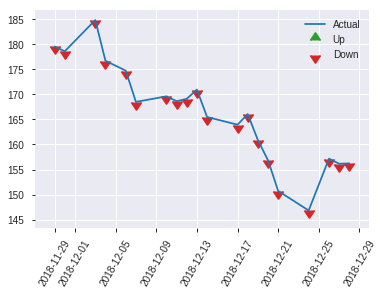


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24976074392567416
RMSE: 0.49976068665479695
LogLoss: 0.6926669327173356
Null degrees of freedom: 246
Residual degrees of freedom: 182
Null deviance: 342.65506474663505
Residual deviance: 342.1774647623638
AIC: 472.1774647623638
AUC: 0.5352223534041716
pr_auc: 0.5152327528305707
Gini: 0.07044470680834314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4592014929102739: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    118  0.9752   (118.0/121.0)
1      1    125  0.0079   (1.0/126.0)
Total  4    243  0.4818   (119.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459201     0.677507  242
max f2                       0.450831     0.838881  246
max f0point5                 0.476315     0.587912  195
max accuracy                 0.476315     0.562753  195
max precision                0.491838     0.576923  103
max recall                   0.450831     1         246
max specificity              0.514687     0.991736  0
max absolute_mcc             0.476315     0.140381  195
max min_per_class_accuracy   0.490057     0.553719  123
max mean_per_class_accuracy  0.48979      0.558606  124

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.512362           0.653439  0.653439           0.333333         0.513539  0.333333                    0.513539            0.00793651      0.00793651                 -34.6561  -34.6561
    2        0.0202429                   0.511111           0         0.392063           0                0.511613  0.2                         0.512769            0               0.00793651                 -100      -60.7937
    3        0.0323887                   0.510387           1.30688   0.735119           0.666667         0.510685  0.375                       0.511988            0.015873        0.0238095                  30.6878   -26.4881
    4        0.0404858                   0.509927           0.980159  0.784127           0.5              0.51017   0.4                         0.511624            0.00793651      0.031746                   -1.98413  -21.5873
    5        0.0526316                   0.50891            1.30688   0.904762           0.666667         0.509502  0.461538                    0.511134            0.015873        0.047619                   30.6878   -9.52381
    6        0.101215                    0.505798           1.14352   1.01937            0.583333         0.507435  0.52                        0.509359            0.0555556       0.103175                   14.3519   1.93651
    7        0.149798                    0.502298           0.980159  1.00665            0.5              0.504134  0.513514                    0.507664            0.047619        0.150794                   -1.98413  0.664951
    8        0.202429                    0.500122           0.753968  0.940952           0.384615         0.501326  0.48                        0.506016            0.0396825       0.190476                   -24.6032  -5.90476
    9        0.299595                    0.495681           1.06184   0.980159           0.541667         0.497942  0.5                         0.503398            0.103175        0.293651                   6.18386   -1.98413
    10       0.40081                     0.492271           1.48984   1.10887            0.76             0.49402   0.565657                    0.50103             0.150794        0.444444                   48.9841   10.8866
    11       0.502024                    0.490057           1.09778   1.10663            0.56             0.491193  0.564516                    0.499046            0.111111        0.555556                   9.77778   10.6631
    12       0.59919                     0.486677           0.816799  1.05963            0.416667         0.488321  0.540541                    0.497307            0.0793651       0.634921                   -18.3201  5.96311
    13       0.700405                    0.483556           0.784127  1.01982            0.4              0.485072  0.520231                    0.495539            0.0793651       0.714286                   -21.5873  1.98183
    14       0.797571                    0.47528            1.38856   1.06474            0.708333         0.479318  0.543147                    0.493563            0.134921        0.849206                   38.8558   6.4741
    15       0.898785                    0.469057           0.548889  1.00665            0.28             0.47204   0.513514                    0.491139            0.0555556       0.904762                   -45.1111  0.664951
    16       1                           0.450831           0.940952  1                  0.48             0.463725  0.510121                    0.488364 

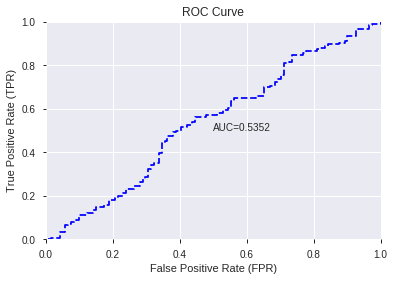

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


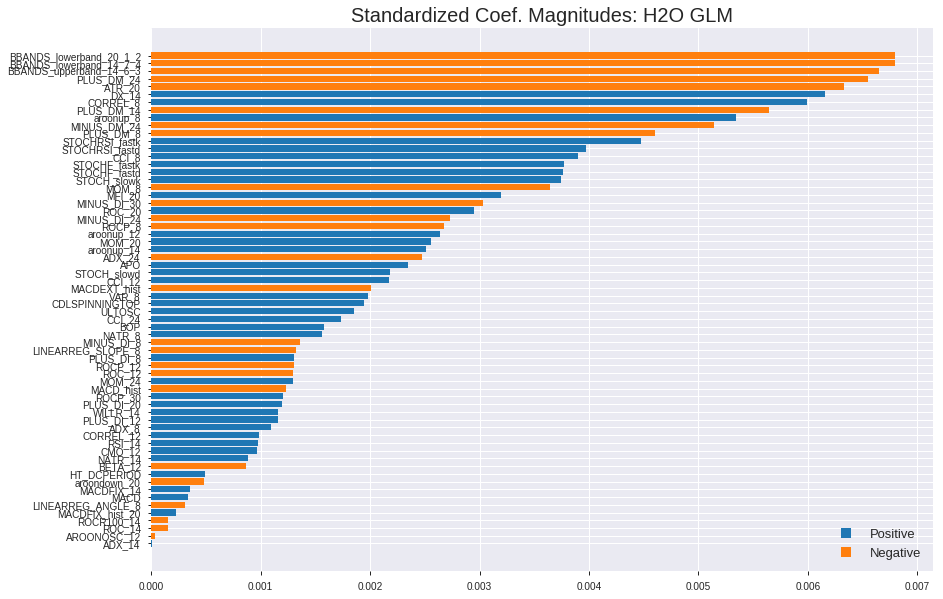

'log_likelihood'
--2019-07-25 01:14:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_011351_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_011351_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BBANDS_lowerband_20_1_2',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_upperband_14_6_3',
 'PLUS_DM_24',
 'ATR_20',
 'DX_14',
 'CORREL_8',
 'PLUS_DM_14',
 'aroonup_8',
 'MINUS_DM_24',
 'PLUS_DM_8',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CCI_8',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MOM_8',
 'MFI_20',
 'MINUS_DI_30',
 'ROC_20',
 'MINUS_DI_24',
 'ROCP_8',
 'aroonup_12',
 'MOM_20',
 'aroonup_14',
 'ADX_24',
 'APO',
 'STOCH_slowd',
 'CCI_12',
 'MACDEXT_hist',
 'VAR_8',
 'CDLSPINNINGTOP',
 'ULTOSC',
 'CCI_24',
 'BOP',
 'NATR_8',
 'MINUS_DI_8',
 'LINEARREG_SLOPE_8',
 'PLUS_DI_8',
 'ROCP_12',
 'ROC_12',
 'MOM_24',
 'MACD_hist',
 'ROCP_30',
 'PLUS_DI_20',
 'WILLR_14',
 'PLUS_DI_12',
 'ADX_8',
 'CORREL_12',
 'RSI_14',
 'CMO_12',
 'NATR_14',
 'BETA_12',
 'HT_DCPERIOD',
 'aroondown_20',
 'MACDFIX_14',
 'MACD',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_20',
 'ROCR100_14',
 'ROC_14',
 'AROONOSC_12',
 'ADX_14']

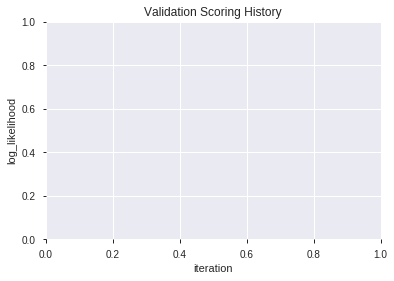

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_011416_model_4  0.499475  0.704544              0.475207  0.505659  0.255691
1  XGBoost_grid_1_AutoML_20190725_011416_model_5  0.492457  0.739590              0.500000  0.520584  0.271007
2               XGBoost_2_AutoML_20190725_011416  0.490620  0.712710              0.500000  0.509271  0.259357
3  XGBoost_grid_1_AutoML_20190725_011416_model_7  0.483996  0.720443              0.500000  0.512856  0.263022
4  XGBoost_grid_1_AutoML_20190725_011416_model_1  0.466417  0.729162              0.500000  0.516926  0.267213
5  XGBoost_grid_1_AutoML_20190725_011416_model_2  0.461564  0.708394              0.487603  0.507481  0.257537
6  XGBoost_grid_1_AutoML_20190725_011416_model_6  0.461367  0.736310              0.500000  0.519929  0.270326
7               XGBoost_3_AutoML_20190725_011416  0.457038  0.717226              0.487439  0.511609  0.261744
8               XGBoost_1_AutoML_20190725_011416  0.454480  0.729286              0.500000  0.517007  0.267296
9  XGBoost_grid_1_AutoML_20190725_011416_model_3  0.451069  0.738835              0.500000  0.521089  0.271533

variable  relative_importance  scaled_importance  percentage
0                  WILLR_14           152.282333           1.000000    0.053460
1                    ATR_20           126.506409           0.830736    0.044411
2                   ROCP_30           101.386681           0.665781    0.035593
3                    CCI_24            98.795776           0.648767    0.034683
4              MACDEXT_hist            89.496361           0.587700    0.031419
5              STOCHF_fastk            86.664909           0.569107    0.030425
6            STOCHRSI_fastd            81.150719           0.532896    0.028489
7                       BOP            75.017479           0.492621    0.026336
8                     ADX_8            73.511452           0.482731    0.025807
9                  CORREL_8            73.003769           0.479397    0.025629
10                   MFI_20            72.313339           0.474864    0.025386
11                    DX_14            68.206482           0.447895    0.023945
12                   CCI_12            67.663643           0.444330    0.023754
13              STOCH_slowd            67.661766           0.444318    0.023753
14               PLUS_DI_12            64.613747           0.424302    0.022683
15              HT_DCPERIOD            64.608315           0.424267    0.022681
16                   ROCP_8            64.599350           0.424208    0.022678
17           STOCHRSI_fastk            64.451088           0.423234    0.022626
18                    VAR_8            63.933014           0.419832    0.022444
19               MINUS_DI_8            63.892574           0.419567    0.022430
20               PLUS_DI_20            60.516254           0.397395    0.021245
21                   ULTOSC            58.679661           0.385335    0.020600
22        LINEARREG_ANGLE_8            54.548981           0.358210    0.019150
23                   ADX_14            52.132645           0.342342    0.018302
24                CORREL_12            52.096077           0.342102    0.018289
25                   ROC_12            50.914612           0.334344    0.017874
26              STOCH_slowk            50.429375           0.331157    0.017704
27                    MOM_8            49.243149           0.323367    0.017287
28              MINUS_DI_30            47.757553           0.313612    0.016766
29  BBANDS_lowerband_20_1_2            46.536819           0.305596    0.016337
30  BBANDS_lowerband_14_7_4            46.370892           0.304506    0.016279
31                PLUS_DI_8            45.999557           0.302068    0.016149
32                   NATR_8            44.280067           0.290776    0.015545
33                  BETA_12            42.624310           0.279903    0.014964
34                   ADX_24            38.921539           0.255588    0.013664
35              MINUS_DI_24            37.555119           0.246615    0.013184
36              AROONOSC_12            37.270306           0.244745    0.013084
37                     MACD            36.168438           0.237509    0.012697
38                   RSI_14            32.737469           0.214979    0.011493
39               PLUS_DM_14            32.679199           0.214596    0.011472
40                PLUS_DM_8            32.130844           0.210995    0.011280
41                   CMO_12            27.937153           0.183456    0.009808
42                  NATR_14            26.926119           0.176817    0.009453
43                   MOM_24            23.685856           0.155539    0.008315
44                MACD_hist            23.321270           0.153145    0.008187
45                   ROC_20            22.027863           0.144651    0.007733
46                      APO            19.964252           0.131100    0.007009
47                   ROC_14            19.563978           0.128472    0.006868
48          MACDFIX_hist_20            18.941256           0.124382    0.006650
49                a

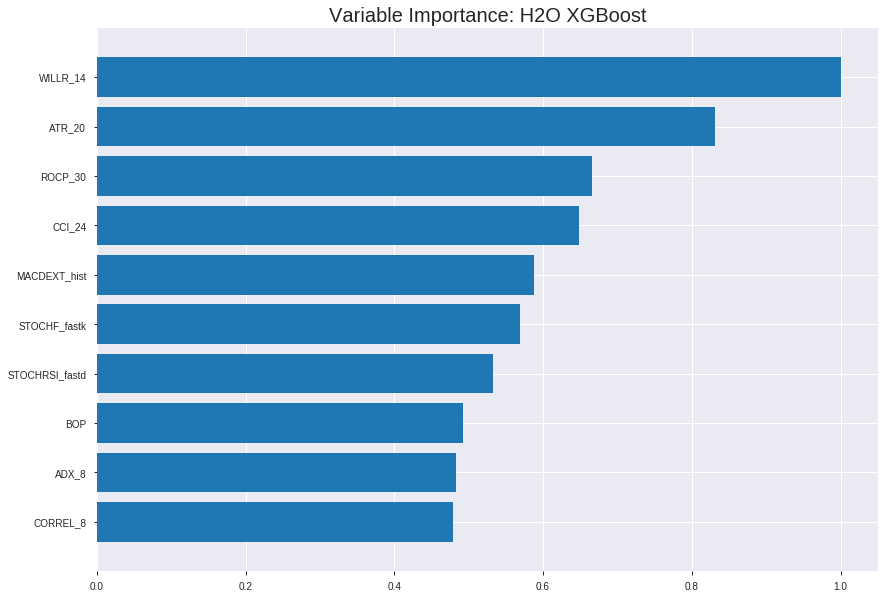

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_011416_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21644437322472337
RMSE: 0.4652358253882899
LogLoss: 0.6247308766279163
Mean Per-Class Error: 0.2873899462678837
AUC: 0.7814381433288018
pr_auc: 0.7761567519845075
Gini: 0.5628762866576036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.483142614364624: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      428  385   0.4736   (385.0/813.0)
1      118  794   0.1294   (118.0/912.0)
Total  546  1179  0.2916   (503.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483143     0.759445  260
max f2                       0.420043     0.864162  338
max f0point5                 0.541258     0.733073  180
max accuracy                 0.510663     0.714203  224
max precision                0.759969     1         0
max recall                   0.367535     1         382
max specificity              0.759969     1         0
max absolute_mcc             0.488804     0.431808  250
max min_per_class_accuracy   0.523538     0.70943   207
max mean_per_class_accuracy  0.520534     0.71261   212

Gains/Lift Table: Avg response rate: 52.87 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.701419           1.68129   1.68129            0.888889         0.718754  0.888889                    0.718754            0.0175439       0.0175439                  68.1287   68.1287
    2        0.0202899                   0.687251           1.78019   1.72932            0.941176         0.693569  0.914286                    0.706521            0.0175439       0.0350877                  78.0186   72.9323
    3        0.0301449                   0.679018           1.66892   1.70958            0.882353         0.68378   0.903846                    0.699087            0.0164474       0.0515351                  66.8924   70.9577
    4        0.04                        0.669648           1.66892   1.69956            0.882353         0.674422  0.898551                    0.69301             0.0164474       0.0679825                  66.8924   69.9561
    5        0.0504348                   0.659571           1.78637   1.71752            0.944444         0.664885  0.908046                    0.687191            0.0186404       0.0866228                  78.6367   71.7521
    6        0.10029                     0.63317            1.53955   1.62905            0.813953         0.645566  0.861272                    0.666499            0.0767544       0.163377                   53.955    62.905
    7        0.150145                    0.614214           1.58354   1.61394            0.837209         0.623688  0.853282                    0.652284            0.0789474       0.242325                   58.3537   61.3938
    8        0.2                         0.597128           1.45158   1.57346            0.767442         0.605997  0.831884                    0.640745            0.0723684       0.314693                   45.1576   57.3465
    9        0.30029                     0.572388           1.39945   1.51535            0.739884         0.58564   0.801158                    0.622341            0.140351        0.455044                   39.9452   51.5349
    10       0.4                         0.548001           1.29762   1.46107            0.686047         0.560061  0.772464                    0.606816            0.129386        0.58443                    29.7621   46.1075
    11       0.50029                     0.525875           1.12612   1.39393            0.595376         0.536068  0.736964                    0.592634            0.112939        0.697368                   12.6122   39.3929
    12       0.6                         0.503029           0.945724  1.31944            0.5              0.514726  0.697585                    0.579687            0.0942982       0.791667                   -5.42763  31.9444
    13       0.69971                     0.479296           0.89074   1.25835            0.47093          0.490867  0.665286                    0.56703             0.0888158       0.880482                   -10.926   25.8353
    14       0.8                         0.451763           0.634127  1.1801             0.33526          0.465398  0.623913                    0.554289            0.0635965       0.944079                   -36.5873  18.0099
    15       0.89971                     0.417894           0.395884  1.09319            0.209302         0.435126  0.577964                    0.541083            0.0394737       0.983553                   -60.4116  9.31883
    16       1                           0.315504           0.163998  1                  0.0867052        0.386894  0.528696                    0.525619          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2548960451634651
RMSE: 0.5048723057996597
LogLoss: 0.7032835685395129
Mean Per-Class Error: 0.4626593202336696
AUC: 0.521118228890069
pr_auc: 0.5542397016715754
Gini: 0.04223645778013796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31271207332611084: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    224  1        (224.0/224.0)
1      0    269  0        (0.0/269.0)
Total  0    493  0.4544   (224.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.312712     0.706037   399
max f2                       0.312712     0.857234   399
max f0point5                 0.408827     0.604368   334
max accuracy                 0.414879     0.557809   322
max precision                0.621966     0.666667   5
max recall                   0.312712     1          399
max specificity              0.6772       0.995536   0
max absolute_mcc             0.458173     0.0757292  230
max min_per_class_accuracy   0.47827      0.513011   195
max mean_per_class_accuracy  0.458173     0.537341   230

Gains/Lift Table: Avg response rate: 54.56 %, avg score: 47.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.622044           1.09963   1.09963            0.6              0.649189  0.6                         0.649189            0.0111524       0.0111524                  9.96283   9.96283
    2        0.020284                    0.616683           1.09963   1.09963            0.6              0.61991   0.6                         0.63455             0.0111524       0.0223048                  9.96283   9.96283
    3        0.030426                    0.609687           0.366543  0.855266           0.2              0.615691  0.466667                    0.628264            0.00371747      0.0260223                  -63.3457  -14.4734
    4        0.040568                    0.603206           1.09963   0.916357           0.6              0.606933  0.5                         0.622931            0.0111524       0.0371747                  9.96283   -8.36431
    5        0.0507099                   0.594136           1.09963   0.953011           0.6              0.598664  0.52                        0.618078            0.0111524       0.0483271                  9.96283   -4.69888
    6        0.10142                     0.568126           1.17294   1.06297            0.64             0.577181  0.58                        0.597629            0.0594796       0.107807                   17.2937   6.2974
    7        0.150101                    0.548521           0.916357  1.01542            0.5              0.558169  0.554054                    0.584831            0.0446097       0.152416                   -8.36431  1.54225
    8        0.200811                    0.538893           1.02632   1.01817            0.56             0.542996  0.555556                    0.574267            0.0520446       0.204461                   2.63197   1.81743
    9        0.300203                    0.517086           1.04727   1.02781            0.571429         0.529385  0.560811                    0.559407            0.104089        0.30855                    4.7265    2.78057
    10       0.401623                    0.49465            0.989665  1.01817            0.54             0.5069    0.555556                    0.546148            0.100372        0.408922                   -1.03346  1.81743
    11       0.501014                    0.47827            1.04727   1.02395            0.571429         0.486642  0.558704                    0.534343            0.104089        0.513011                   4.7265    2.39453
    12       0.600406                    0.457832           1.19687   1.05257            0.653061         0.468082  0.574324                    0.523374            0.118959        0.63197                    19.6874   5.25721
    13       0.699797                    0.443743           0.897656  1.03057            0.489796         0.450295  0.562319                    0.512995            0.0892193       0.72119                    -10.2344  3.05695
    14       0.799189                    0.422247           0.935058  1.01869            0.510204         0.434265  0.555838                    0.503204            0.0929368       0.814126                   -6.4942   1.86911
    15       0.89858                     0.39535            0.897656  1.0053             0.489796         0.410663  0.548533                    0.492968            0.0892193       0.903346                   -10.2344  0.530348
    16       1                           0.312712           0.953011  1                  0.52             0.363352  0.545639                    0.479822      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 01:14:21  1.870 sec   0                  0.5              0.693147            0.5             0                  1                0.471304                         0.5                0.693147              0.5               0                    1                  0.454361
    2019-07-25 01:14:21  1.939 sec   5                  0.494296         0.681789            0.668023        0.672942           1.49325          0.397101                         0.499951           0.69305               0.52545           0.56252              0.733086           0.454361
    2019-07-25 01:14:21  1.982 sec   10                 0.489732         0.672754            0.695331        0.698569           1.57621          0.364058                         0.500846           0.694848              0.513916          0.542264             0.366543           0.454361
    2019-07-25 01:14:21  2.031 sec   15                 0.486168         0.665721            0.710736        0.709602           1.47113          0.361159                         0.50109            0.695343              0.513916          0.544168             0.733086           0.450304
    2019-07-25 01:14:21  2.078 sec   20                 0.482691         0.658857            0.720625        0.722908           1.47113          0.354203                         0.501199           0.695584              0.517177          0.545208             0.366543           0.454361
    2019-07-25 01:14:21  2.125 sec   25                 0.479302         0.652181            0.732557        0.732963           1.68129          0.324638                         0.501501           0.69622               0.524885          0.553377             0.733086           0.454361
    2019-07-25 01:14:21  2.172 sec   30                 0.476318         0.646304            0.739731        0.739121           1.57621          0.321739                         0.501648           0.696547              0.5293            0.560717             0.733086           0.454361
    2019-07-25 01:14:21  2.222 sec   35                 0.473544         0.64088             0.7499          0.748325           1.57621          0.329275                         0.502675           0.698655              0.523633          0.555635             0.733086           0.454361
    2019-07-25 01:14:21  2.273 sec   40                 0.470963         0.63584             0.759259        0.751831           1.47113          0.329855                         0.5039             0.701195              0.518662          0.552545             1.09963            0.454361
    2019-07-25 01:14:21  2.330 sec   45                 0.468129         0.63034             0.770461        0.764771           1.68129          0.313623                         0.504426           0.702343              0.520139          0.555586             0.733086           0.454361
    2019-07-25 01:14:21  2.388 sec   50                 0.465236         0.624731            0.781438        0.776157           1.68129          0.291594                         0.504872           0.703284              0.521118          0.55424              1.09963            0.454361

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ---------------------
WILLR_14      152.28233337402344     1.0                  0.05346031813794744
ATR_20        126.50640869140625     0.8307359487373466   0.04441140810812814
ROCP_30       101.38668060302734     0.6657809764052515   0.03559286280881802
CCI_24        98.7957763671875       0.6487671562303513   0.034683298569526025
MACDEXT_hist  89.4963607788086       0.5877002196899291   0.03141864071436521
---           ---                    ---                  ---
aroonup_14    7.700067520141602      0.05056441774653744  0.002703189859189967
MOM_20        7.069466590881348      0.04642341914684155  0.0024818107566414297
PLUS_DM_24    6.286746025085449      0.04128348893659553  0.0022070284523948306
MINUS_DM_24   5.251314163208008      0.03448406684385482  0.0018435291841627237
aroonup_12    3.834524154663086      0.02518036117324943  0.001346150119150334


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6866485013623979)

('auc', 0.49947527220254495)

('logloss', 0.7045440006006093)

('mean_per_class_error', 0.4610061655516201)

('rmse', 0.505658665105415)

('mse', 0.25569068559619024)

xgboost prediction progress: |████████████████████████████████████████████| 100%


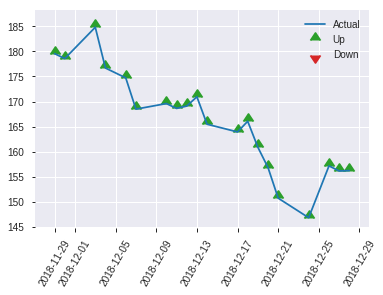


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25569068559619024
RMSE: 0.505658665105415
LogLoss: 0.7045440006006093
Mean Per-Class Error: 0.4610061655516201
AUC: 0.49947527220254495
pr_auc: 0.49288490718405503
Gini: -0.001049455594910098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3563554883003235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    115  0.9504   (115.0/121.0)
1      0    126  0        (0.0/126.0)
Total  6    241  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356355     0.686649  240
max f2                       0.356355     0.845638  240
max f0point5                 0.384278     0.581854  221
max accuracy                 0.38853      0.546559  215
max precision                0.495213     0.549296  70
max recall                   0.356355     1         240
max specificity              0.635528     0.991736  0
max absolute_mcc             0.356355     0.161013  240
max min_per_class_accuracy   0.460246     0.460317  121
max mean_per_class_accuracy  0.38853      0.538994  215

Gains/Lift Table: Avg response rate: 51.01 %, avg score: 45.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.601848           0.653439  0.653439           0.333333         0.618334  0.333333                    0.618334            0.00793651      0.00793651                 -34.6561  -34.6561
    2        0.0202429                   0.585106           0.980159  0.784127           0.5              0.591194  0.4                         0.607478            0.00793651      0.015873                   -1.98413  -21.5873
    3        0.0323887                   0.57426            0.653439  0.735119           0.333333         0.579978  0.375                       0.597165            0.00793651      0.0238095                  -34.6561  -26.4881
    4        0.0404858                   0.564483           0         0.588095           0                0.569872  0.3                         0.591707            0               0.0238095                  -100      -41.1905
    5        0.0526316                   0.55707            0         0.452381           0                0.560193  0.230769                    0.584434            0               0.0238095                  -100      -54.7619
    6        0.101215                    0.541112           1.14352   0.784127           0.583333         0.549856  0.4                         0.567837            0.0555556       0.0793651                  14.3519   -21.5873
    7        0.149798                    0.528211           1.14352   0.900686           0.583333         0.535573  0.459459                    0.557373            0.0555556       0.134921                   14.3519   -9.93136
    8        0.202429                    0.508226           1.50794   1.05857            0.769231         0.520512  0.54                        0.547789            0.0793651       0.214286                   50.7937   5.85714
    9        0.299595                    0.491735           0.980159  1.03314            0.5              0.501044  0.527027                    0.532629            0.0952381       0.309524                   -1.98413  3.31403
    10       0.40081                     0.473271           0.705714  0.950457           0.36             0.481456  0.484848                    0.519706            0.0714286       0.380952                   -29.4286  -4.9543
    11       0.502024                    0.459065           0.784127  0.916923           0.4              0.465842  0.467742                    0.508847            0.0793651       0.460317                   -21.5873  -8.30773
    12       0.59919                     0.438431           1.30688   0.980159           0.666667         0.44703   0.5                         0.498822            0.126984        0.587302                   30.6878   -1.98413
    13       0.700405                    0.425523           1.33302   1.03115            0.68             0.431311  0.526012                    0.489066            0.134921        0.722222                   33.3016   3.11496
    14       0.797571                    0.403514           1.06184   1.03489            0.541667         0.416056  0.527919                    0.480172            0.103175        0.825397                   6.18386   3.48884
    15       0.898785                    0.384267           1.09778   1.04197            0.56             0.393734  0.531532                    0.470438            0.111111        0.936508                   9.77778   4.19705
    16       1                           0.29667            0.627302  1                  0.32             0.359558  0.510121                    0.459215

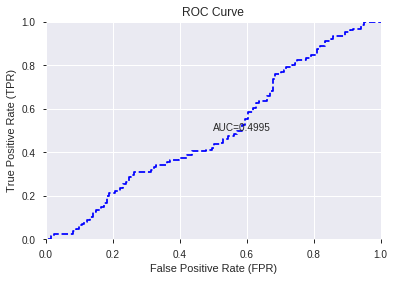

This function is available for GLM models only


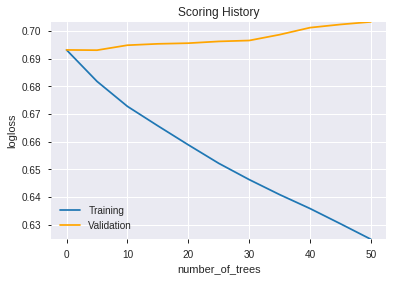

--2019-07-25 01:14:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_011416_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_011416_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b977',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['WILLR_14',
 'ATR_20',
 'ROCP_30',
 'CCI_24',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'BOP',
 'ADX_8',
 'CORREL_8',
 'MFI_20',
 'DX_14',
 'CCI_12',
 'STOCH_slowd',
 'PLUS_DI_12',
 'HT_DCPERIOD',
 'ROCP_8',
 'STOCHRSI_fastk',
 'VAR_8',
 'MINUS_DI_8',
 'PLUS_DI_20',
 'ULTOSC',
 'LINEARREG_ANGLE_8',
 'ADX_14',
 'CORREL_12',
 'ROC_12',
 'STOCH_slowk',
 'MOM_8',
 'MINUS_DI_30',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_lowerband_14_7_4',
 'PLUS_DI_8',
 'NATR_8',
 'BETA_12',
 'ADX_24',
 'MINUS_DI_24',
 'AROONOSC_12',
 'MACD',
 'RSI_14',
 'PLUS_DM_14',
 'PLUS_DM_8',
 'CMO_12',
 'NATR_14',
 'MOM_24',
 'MACD_hist',
 'ROC_20',
 'APO',
 'ROC_14',
 'MACDFIX_hist_20',
 'aroonup_8',
 'MACDFIX_14',
 'CCI_8',
 'aroondown_20',
 'BBANDS_upperband_14_6_3',
 'aroonup_14',
 'MOM_20',
 'PLUS_DM_24',
 'MINUS_DM_24',
 'aroonup_12']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.534
GLM             0.563
XGBoost         0.563
dtype: float64

DeepLearning    GLM  XGBoost
All          0.510  0.510    0.563
DLF          0.510  0.510    0.538
Fwe          0.510  0.510    0.563
RFE          0.534  0.563    0.547
XGBF         0.510  0.510    0.538





F1


DeepLearning    0.679
GLM             0.678
XGBoost         0.687
dtype: float64

DeepLearning    GLM  XGBoost
All          0.676  0.676    0.684
DLF          0.676  0.676    0.676
Fwe          0.676  0.676    0.684
RFE          0.679  0.678    0.687
XGBF         0.676  0.676    0.676





auc


DeepLearning    0.520
GLM             0.535
XGBoost         0.546
dtype: float64

DeepLearning    GLM  XGBoost
All           0.50  0.500    0.546
DLF           0.50  0.500    0.481
Fwe           0.50  0.500    0.546
RFE           0.52  0.535    0.499
XGBF          0.50  0.500    0.481





logloss


DeepLearning    17.619
GLM             17.619
XGBoost          0.850
dtype: float64

DeepLearning     GLM  XGBoost
All         17.619  17.619    0.702
DLF         16.920  17.619    0.850
Fwe         16.920  17.619    0.702
RFE          1.401   0.693    0.705
XGBF        17.619  17.619    0.850





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.468
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.445
DLF          0.500  0.500    0.468
Fwe          0.500  0.500    0.445
RFE          0.467  0.441    0.461
XGBF         0.500  0.500    0.468





rmse


DeepLearning    0.714
GLM             0.714
XGBoost         0.560
dtype: float64

DeepLearning    GLM  XGBoost
All          0.714  0.714    0.504
DLF          0.700  0.714    0.560
Fwe          0.700  0.714    0.504
RFE          0.629  0.500    0.506
XGBF         0.714  0.714    0.560





mse


DeepLearning    0.510
GLM             0.510
XGBoost         0.314
dtype: float64

DeepLearning   GLM  XGBoost
All          0.510  0.51    0.254
DLF          0.490  0.51    0.314
Fwe          0.490  0.51    0.254
RFE          0.396  0.25    0.256
XGBF         0.510  0.51    0.314

{'F1':       DeepLearning    GLM  XGBoost
 All          0.676    NaN      NaN
 DLF          0.676    NaN      NaN
 DLF            NaN  0.676      NaN
 DLF            NaN    NaN    0.676
 All            NaN  0.676      NaN
 All            NaN    NaN    0.684
 XGBF         0.676    NaN      NaN
 XGBF           NaN  0.676      NaN
 XGBF           NaN    NaN    0.676
 Fwe          0.676    NaN      NaN
 Fwe            NaN  0.676      NaN
 Fwe            NaN    NaN    0.684
 RFE          0.679    NaN      NaN
 RFE            NaN  0.678      NaN
 RFE            NaN    NaN    0.687,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.510    NaN      NaN
 DLF          0.510    NaN      NaN
 DLF            NaN  0.510      NaN
 DLF            NaN    NaN    0.538
 All            NaN  0.510      NaN
 All            NaN    NaN    0.563
 XGBF         0.510    NaN      NaN
 XGBF           NaN  0.510      NaN
 XGBF           NaN    NaN    0.538
 Fwe          0.510    NaN      NaN
 Fwe     